# Univariate Time Series Analysis

### Kevin Sheppard

* Forcasting
  * AR(1)
  * AR(1) direct
* Forecasting recursively
* Cross-validation
* Absolute forecast eval
* Relaitve forecast evaluation
* Seasonal DIfferencing
* Seasonal Summies + ARMA
* SARIMA
* Unit Root testing


In [1]:
import matplotlib.pyplot as plt
import mfe
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from pandas.plotting import scatter_matrix as pd_scatter_matrix
from scipy import stats
from statsmodels.tsa.api import SARIMAX

mfe.full_setup()
mfe.outputs["pres"]()
DEFAULT_FIGSIZE = (32, 15)
plt.rc("figure", figsize=DEFAULT_FIGSIZE)
plt.rc("font", size=48)


LAST_COLOR_INDEX = 0
MAX_COLOR_INDEX = 8


def figsize(x=DEFAULT_FIGSIZE[0], y=DEFAULT_FIGSIZE[1]):
    if x <= 0:
        x += DEFAULT_FIGSIZE[0]
    if y <= 0:
        y += DEFAULT_FIGSIZE[1]
    plt.rc("figure", figsize=(x, y))


def plot(s: pd.Series, y=DEFAULT_FIGSIZE[1]):
    global LAST_COLOR_INDEX
    figsize(y=y)
    fig, ax = plt.subplots(1, 1)
    if isinstance(s, pd.Series):
        s.plot(ax=ax, legend=False, color=mfe.colors[LAST_COLOR_INDEX])
    else:
        s.plot(ax=ax, legend=False)
        fig.legend(frameon=False)
    LAST_COLOR_INDEX += 1
    LAST_COLOR_INDEX = LAST_COLOR_INDEX % MAX_COLOR_INDEX
    ax.set_xlabel(None)
    ax.set_xlim(s.index[0], s.index[-1])
    sns.despine()
    fig.tight_layout(pad=1.0)
    figsize()


def pretty(s):
    from IPython.display import HTML, display

    if not isinstance(s, pd.Series):
        return display(HTML(f"<span>{s}</span>"))

    df = pd.DataFrame(s)
    if df.columns[0] == 0:
        df.columns = [""]
    return df


def summary(res, idx=(1,)):
    from IPython.display import HTML, display

    summ = res.summary()
    for i in idx:
        html = summ.tables[i]._repr_html_()
        if i == 0:
            html = html.split("</tr>")
            html = "</tr>".join(html[:-8] + html[-1:])
            html = html.replace("<caption>OLS Regression Results</caption>", "")
        display(HTML(html))
    return None


figsize()

with pd.HDFStore("time-series-data.h5", mode="r") as store:
    curve = store.get("curve")
    default = store.get("default")
    housing = store.get("housing")
    indpro = store.get("indpro")
    orig = store.get("orig")
    seasonal = store.get("seasonal")
    sim = store.get("sim")
    uscons = store.get("uscons")
    vwm = store.get("vwm")
housing_yoy = np.log(orig.HOUSTNSA).diff(12).dropna()
housing_raw = np.log(orig.HOUSTNSA).dropna()
housing_yoy = housing_yoy.reindex_like(housing)
housing_raw = housing_raw.reindex_like(housing)
m2_growth = np.log(orig.M2SL).diff().dropna().reindex_like(housing)
vix = np.log(orig.VXOCLSx).dropna()
series = {
    "curve": curve,
    "default": default,
    "housing": housing,
    "indpro": indpro,
    "orig": orig,
    "seasonal": seasonal,
    "sim": sim,
    "uscons": uscons,
    "vwm": vwm,
    "m2_growth": m2_growth,
}

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import acf, pacf


def acf_pacf_plot(y, lags, correct=False, title=None, size=DEFAULT_FIGSIZE[1]):
    figsize(y=size)
    a = acf(y, nlags=lags, fft=True)
    p = pacf(y, nlags=lags)
    fig, ax = plt.subplots(1, 2)
    x = np.arange(1, lags + 1)
    t = y.shape[0]
    ax[0].bar(x, a[1:])
    ax[1].bar(x, p[1:], color=mfe.colors[1])
    a_ci = p_ci = 1.96 * np.ones_like(a[1:]) / np.sqrt(t)
    if correct:
        a_ci = 1.96 * (1 + np.cumsum(a[:-1] ** 2)) / np.sqrt(t)
    x[0] = 0.5
    x[-1] = lags + 0.5
    ax[0].plot(x, a_ci, "k--", x, -a_ci, "k--")
    ax[1].plot(x, p_ci, "k--", x, -p_ci, "k--")
    ax[0].set_xlim(0.5, lags + 0.5)
    ax[1].set_xlim(0.5, lags + 0.5)
    ax[0].set_title("Autocorrelation")
    ax[1].set_title("Partial Autocorrelation")
    if title:
        plt.suptitle(title)
    sns.despine()
    fig.tight_layout(pad=1.0)
    figsize()

In [3]:
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox, acorr_lm


def lb_plot(x, lags, title=None):
    df = acorr_ljungbox(resid, lags, return_df=True)
    stat = df.iloc[:, 0]
    pval = df.iloc[:, 1]
    fig, ax = plt.subplots(1, 2)
    x = np.arange(1, lags + 1)
    ax[0].bar(x, stat)
    cv = stats.chi2.ppf(0.95, np.arange(1, lags + 1))
    ax[0].plot(x, cv, "k--")
    ax[1].bar(x, pval, color=mfe.colors[1])
    cv[:] = 0.05
    x[0] = 0.0
    x[-1] = lags + 1
    ax[1].plot(x, cv, "k--")
    ax[1].set_ylim(0, 1)
    ax[0].set_xlim(0.5, lags + 0.5)
    ax[1].set_xlim(0.5, lags + 0.5)
    ax[0].set_title("Q Stat")
    ax[1].set_title("P-value")
    if title:
        plt.suptitle(title)
    sns.despine()
    fig.tight_layout(pad=1.0)


def lm_plot(x, lags, title=None):
    d = {}
    for i in range(1, lags + 1):
        stat, pval, _, _ = acorr_lm(resid, nlags=i, cov_type="HC0", autolag=None)
        pval = float(pval)
        s = pd.Series([stat, pval], index=["stat", "pval"])
        d[i] = s
    df = pd.DataFrame(d).T

    stat = df.iloc[:, 0]
    pval = df.iloc[:, 1]
    fig, ax = plt.subplots(1, 2)
    x = np.arange(1, lags + 1)
    ax[0].bar(x, stat)
    cv = stats.chi2.ppf(0.95, np.arange(1, lags + 1))
    ax[0].plot(x, cv, "k--")
    ax[1].bar(x, pval, color=mfe.colors[1])
    cv[:] = 0.05
    x[0] = 0.0
    x[-1] = lags + 1
    ax[1].plot(x, cv, "k--")
    ax[1].set_ylim(0, 1)
    ax[0].set_xlim(0.5, lags + 0.5)
    ax[1].set_xlim(0.5, lags + 0.5)
    ax[0].set_title("LM Stat")
    ax[1].set_title("P-value")
    if title:
        plt.suptitle(title)
    sns.despine()
    fig.tight_layout(pad=1.0)

In [4]:
from pandas import IndexSlice


def ic_plot(aic, bic):
    figsize(y=DEFAULT_FIGSIZE[1] - 2)
    fig, ax = plt.subplots(1, 2)
    for i in range(3):
        aic.loc[(slice(None), i)].plot(
            ax=ax[0], linestyle="none", marker="s", markersize=24
        )
        xl = aic.loc[(slice(None), i)].index
    ax[0].plot(
        [aic.idxmin()[0]],
        [aic.min()],
        linestyle="none",
        marker="o",
        markersize=64,
        color=mfe.colors[7],
        zorder=-3,
        alpha=0.33,
    )
    for i in range(3):
        bic.loc[(slice(None), i)].plot(
            ax=ax[1], linestyle="none", marker="s", markersize=24, label=f"Q={i}"
        )
    ax[1].plot(
        [bic.idxmin()[0]],
        [bic.min()],
        linestyle="none",
        marker="o",
        markersize=64,
        color=mfe.colors[7],
        zorder=-3,
        alpha=0.33,
    )
    ax[1].legend(frameon=False, loc="lower right")
    ax[0].set_title("AIC")
    ax[0].set_xticks(xl)
    ax[1].set_xticks(xl)
    ax[1].set_title("BIC")
    yl = ax[0].get_ylim()
    ax[0].set_ylim(2 * aic.min() - aic.median(), 2 * aic.median() - aic.min())
    ax[1].set_ylim(2 * bic.min() - bic.median(), 2 * bic.median() - bic.min())
    ax[0].set_xlabel("P")
    ax[1].set_xlabel("P")
    sns.despine()
    fig.tight_layout(pad=1.0)
    figsize()

# Forecasting

* One-step forecast

$$ E_t[Y_{t+1}] $$

* Multi-step forecast

$$ E_t[Y_{t+h}] $$

* Forecasts are recursively computed
  * First compute $E_t[Y_{t+1}] $ which depends on the $\mathcal{F}_t$ information $Y_t, Y_{t-1}, \ldots, \hat{\epsilon}_{t}, \hat{\epsilon}_{t-1} \ldots$
  * Then compute $E_t[Y_{t+2}] $ which depends on $E_t[Y_{t+1}]$ and $\mathcal{F}_t$ information
  * Repeat until $E_t[Y_{t+h}] $

* Forecasts from covariance stationary time series are _mean reverting_

# AR(1) Model Fitting

$$ Y_t = \phi_0 + \phi_1 Y_{t-1} + \epsilon_t $$

In [5]:
res = SARIMAX(m2_growth, order=(1, 0, 0), trend="c").fit()
summary(res)

,coef,std err,z,P>|z|,[0.025,0.975]
intercept,0.0021,0.000,11.315,0.000,0.002,0.002
ar.L1,0.6326,0.010,62.755,0.000,0.613,0.652
sigma2,1.221e-05,1.85e-07,65.856,0.000,1.18e-05,1.26e-05


# Forecasts

$$ \mathrm{E}_t[Y_{t+h}] = \phi_0 + \phi_1 \mathrm{E}_t[Y_{t+h-1}] + \mathrm{E}_t[\epsilon_{t+h}] $$

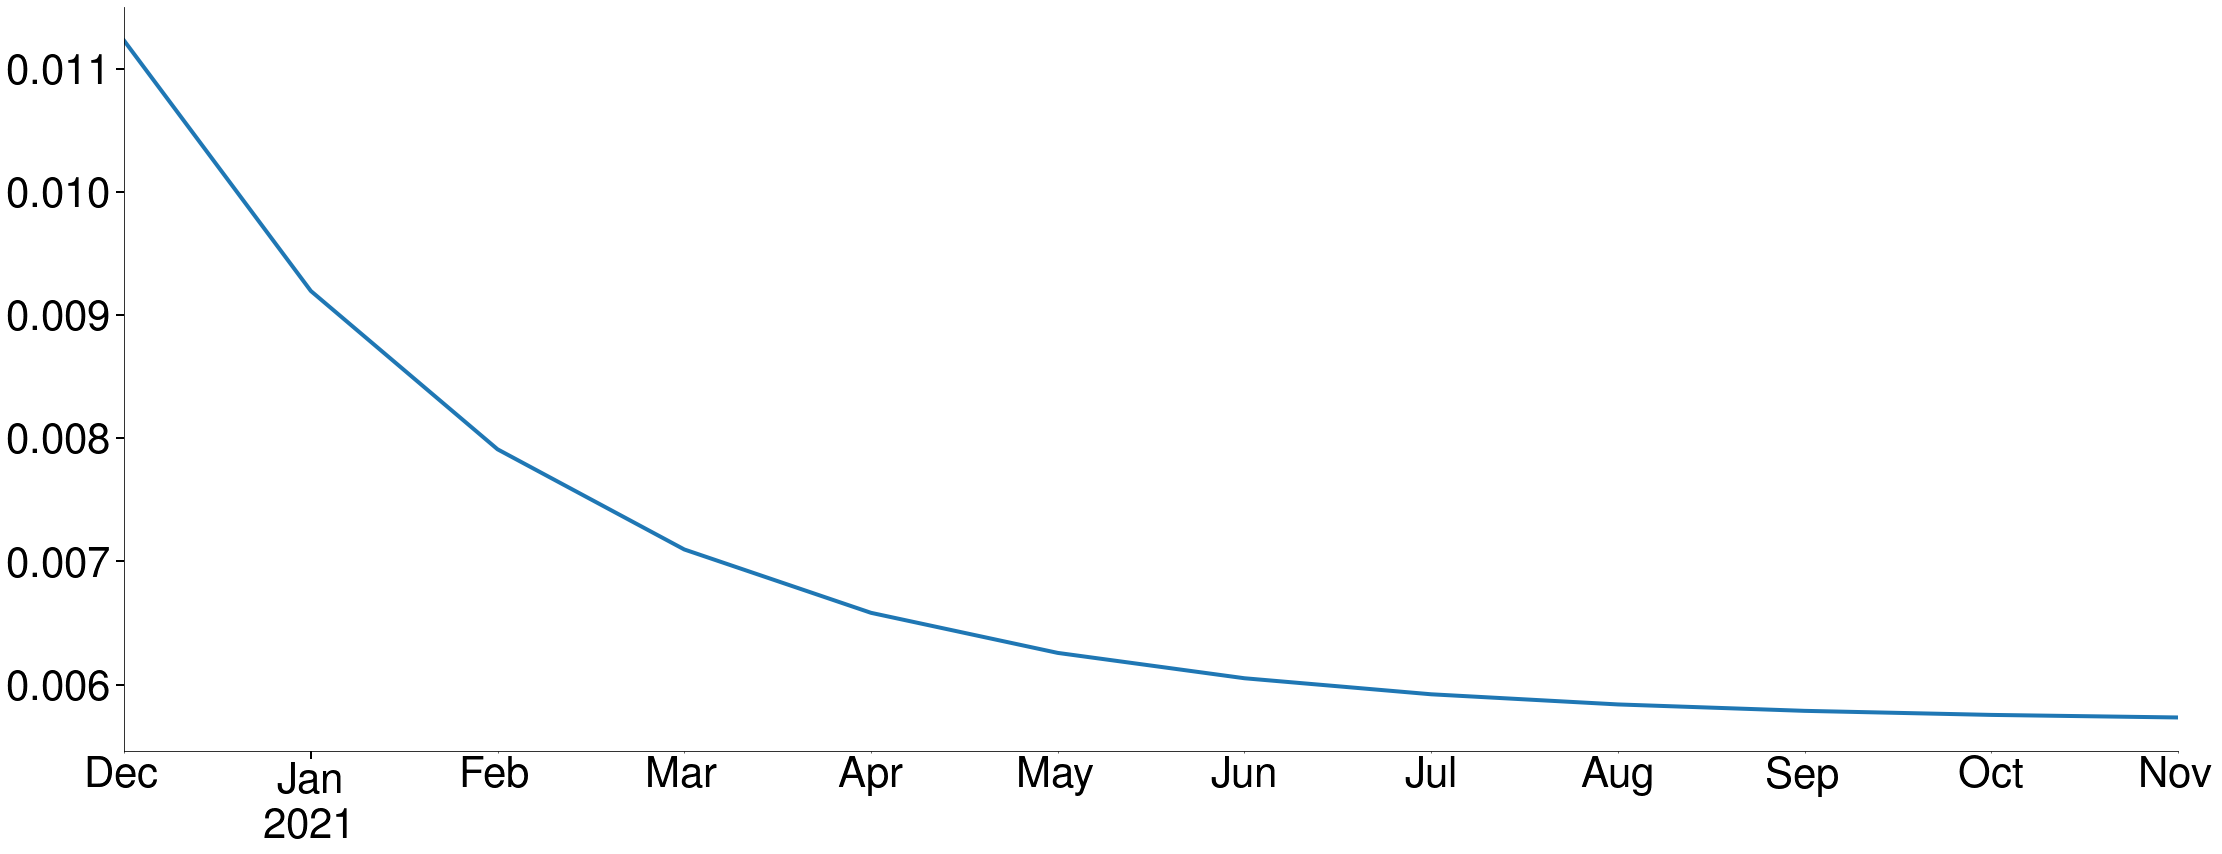

In [6]:
fcast = res.forecast(12)
plot(fcast, y=-2)

# Manually Constructing Forecasts

* Forecasts are directly computes using the recursive form

$$ \mathrm{E}_t[Y_{t+h}] = \phi_0 + \phi_1 \mathrm{E}_t[Y_{t+h-1}] + \mathrm{E}_t[\epsilon_{t+h}] $$

* Rules for computing $E_t[Y_{t+h}]$
  1. $\mathrm{E}_t[\epsilon_{t+h}]=0$ if $h>0$
  2. $\mathrm{E}_t[\epsilon_{t+h}]=\hat{\epsilon}_{t+h}$ if $h\leq 0$
  3. $\mathrm{E}_t[Y_{t+h}]=Y_{t+h}$ if $h\leq 0$
  4. Replace $\mathrm{E}_t[Y_{t+h-j}]$ with its value previously computed
  

In [7]:
p0 = res.params["intercept"]
p1 = res.params["ar.L1"]
direct = pd.Series(np.zeros(12), index=fcast.index)
for i in range(12):
    if i == 0:
        direct[i] = p0 + p1 * m2_growth.iloc[-1]
    else:
        direct[i] = p0 + p1 * direct[i - 1]

# Manual Forecasts

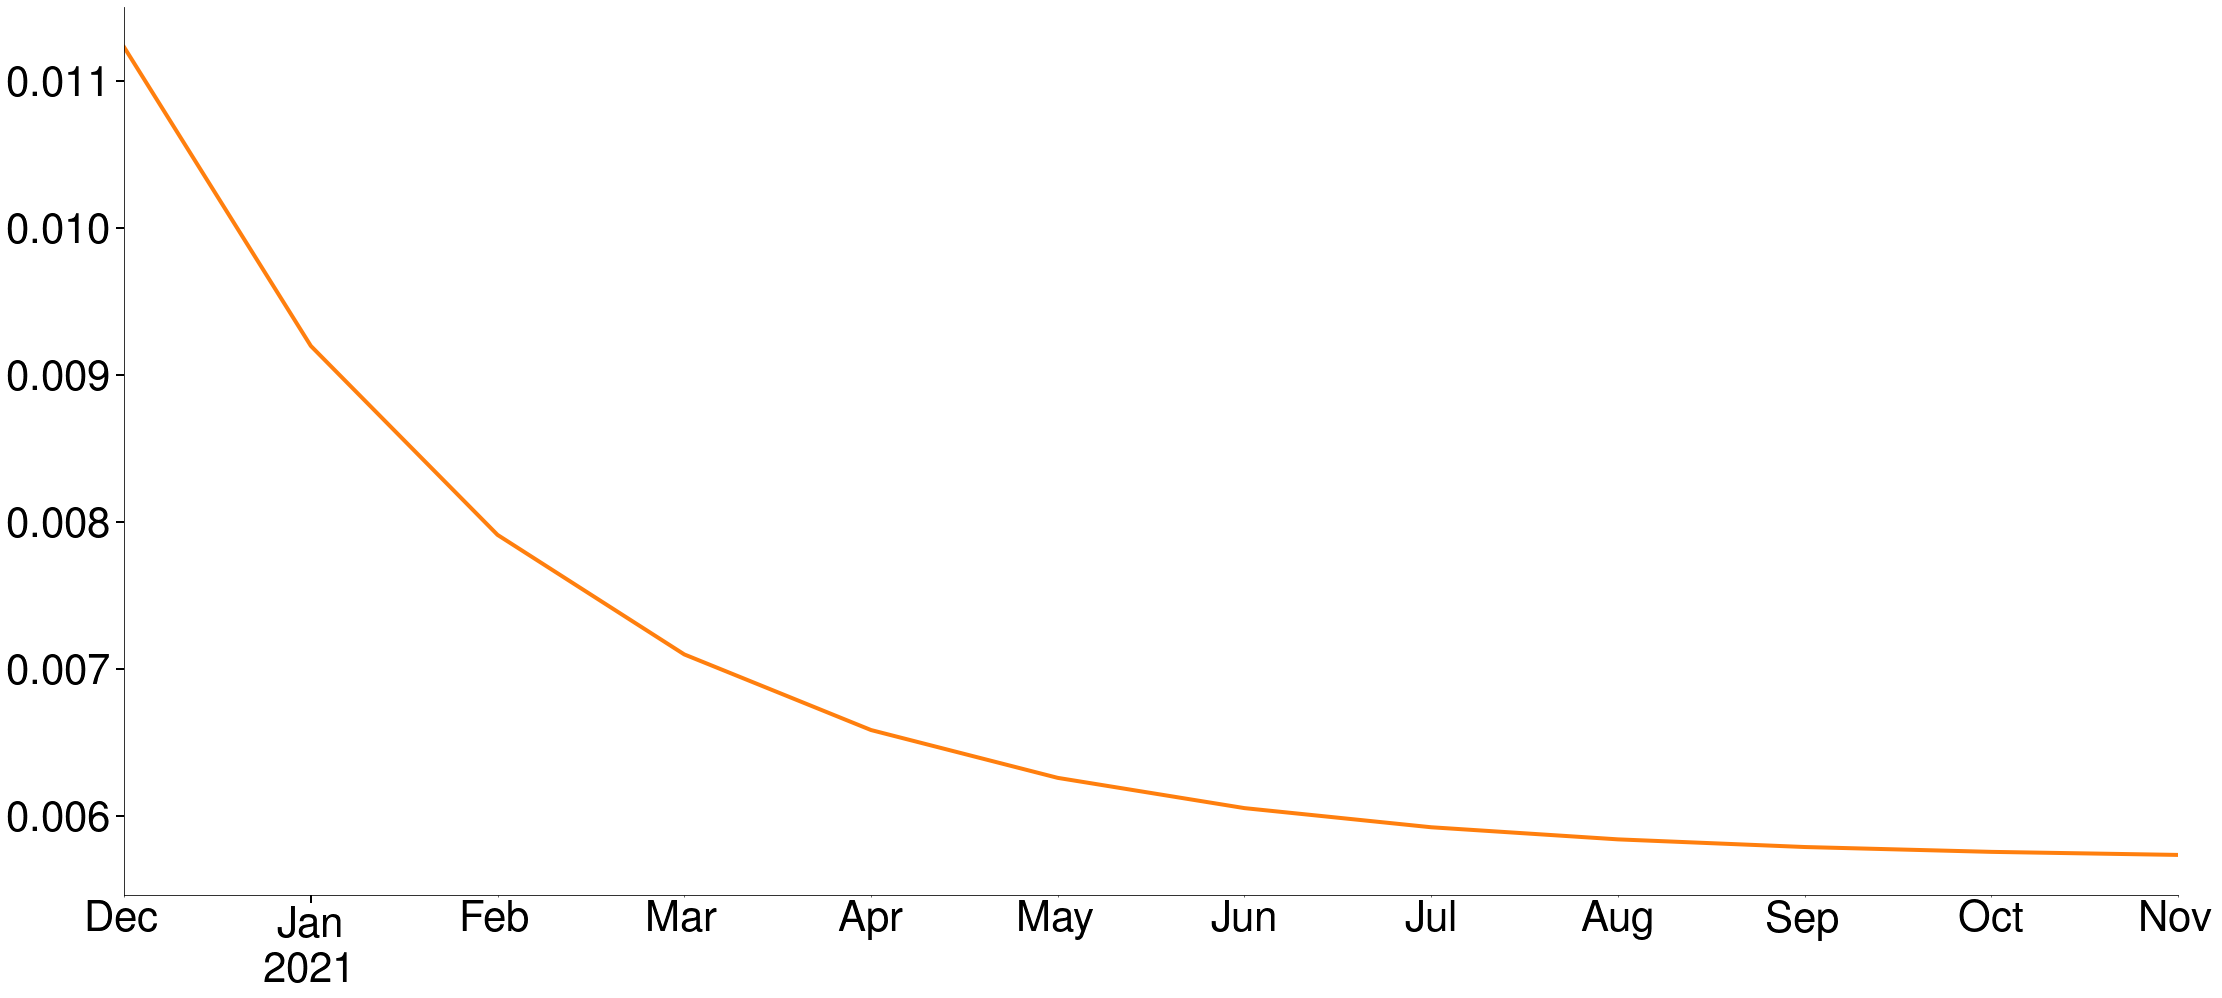

In [8]:
plot(direct)

# Recursive Forecast Construction

* Simple to construct forecasts recursively

In [9]:
t = m2_growth.shape[0]
half = t // 2

forecasts = []
res = SARIMAX(m2_growth.iloc[:half], order=(1, 0, 0), trend="c").fit()
forecasts.append(res.forecast(1))
for i in range(half, t):
    res = res.extend(m2_growth.iloc[i : i + 1])
    forecasts.append(res.forecast(1))
h1 = pd.concat(forecasts)
h1.name = "h1"

# Fast one-step forecast construction

* `extend` using second half and use `get_prediction()`

In [10]:
res2 = SARIMAX(m2_growth.iloc[:half], order=(1, 0, 0), trend="c").fit()
res2 = res2.extend(m2_growth.iloc[half:])
fast_h1 = res2.get_prediction().predicted_mean
fast_h1.name = "fast_h1"
pd.concat([h1, fast_h1], axis=1).head()

,h1,fast_h1
1990-06-01,0.001715,0.001715
1990-07-01,0.004789,0.004789
1990-08-01,0.004279,0.004279
1990-09-01,0.005718,0.005718
1990-10-01,0.004645,0.004645


# Forecasts and Realizations

In [11]:
realizations = m2_growth.loc[h1.index[:-1]]
figsize(y=-2)

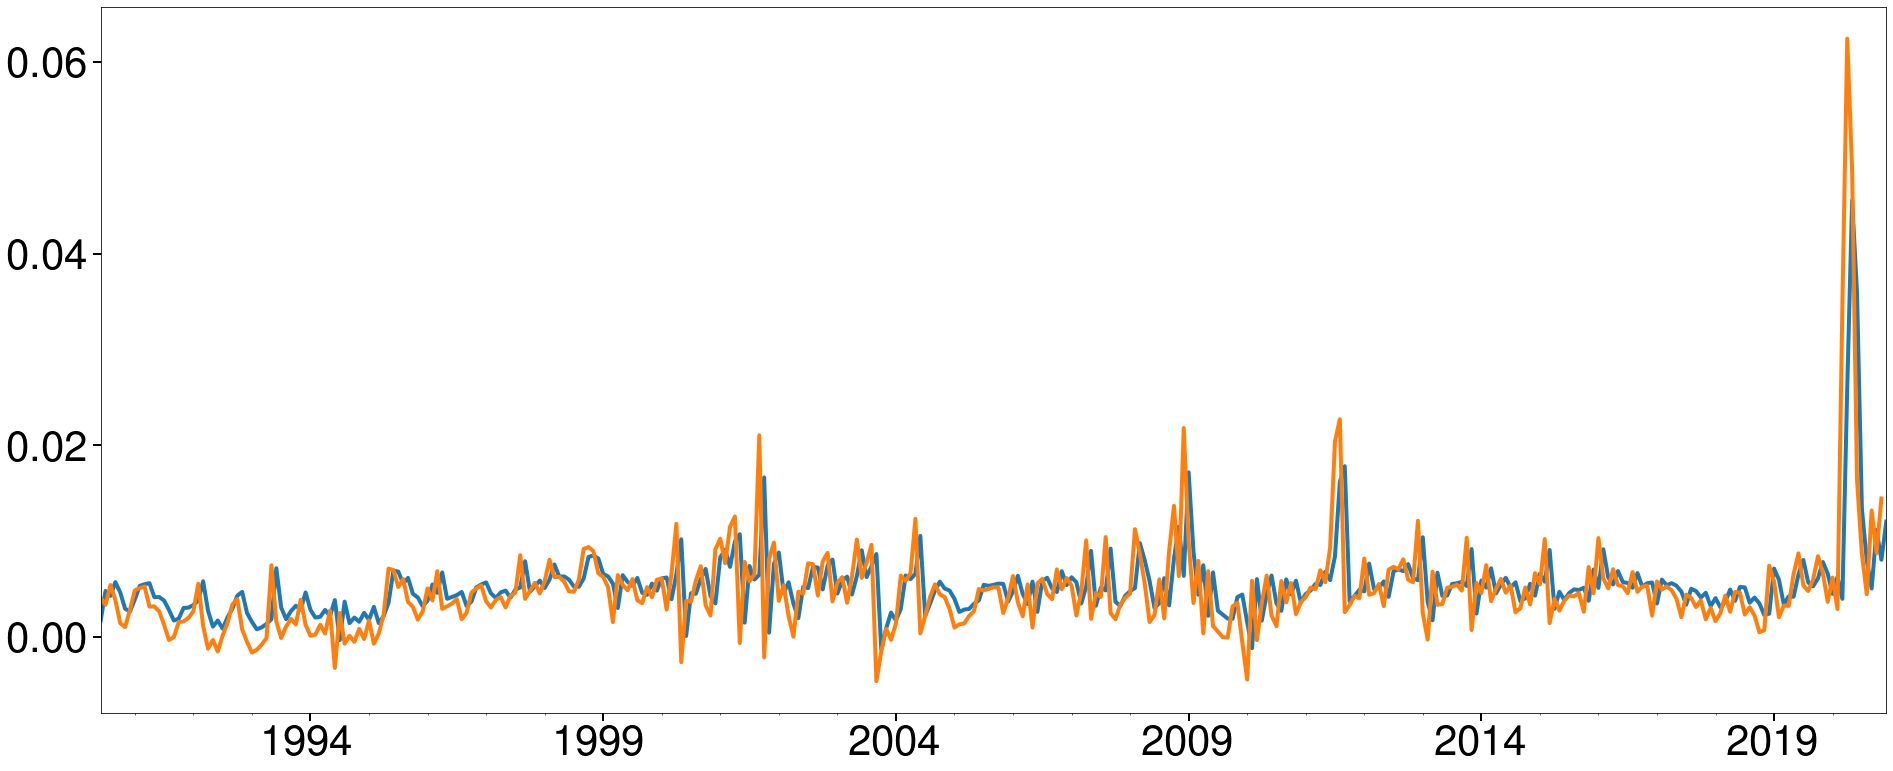

In [14]:
fig, ax = plt.subplots(1, 1)
h1.plot(ax=ax)
_ = realizations.plot(ax=ax)

# Forecast Errors

* 1-step should be a $WN$ process
* $h$-step should be at most a $MA(h-1)$

In [15]:
figsize(y=-2)

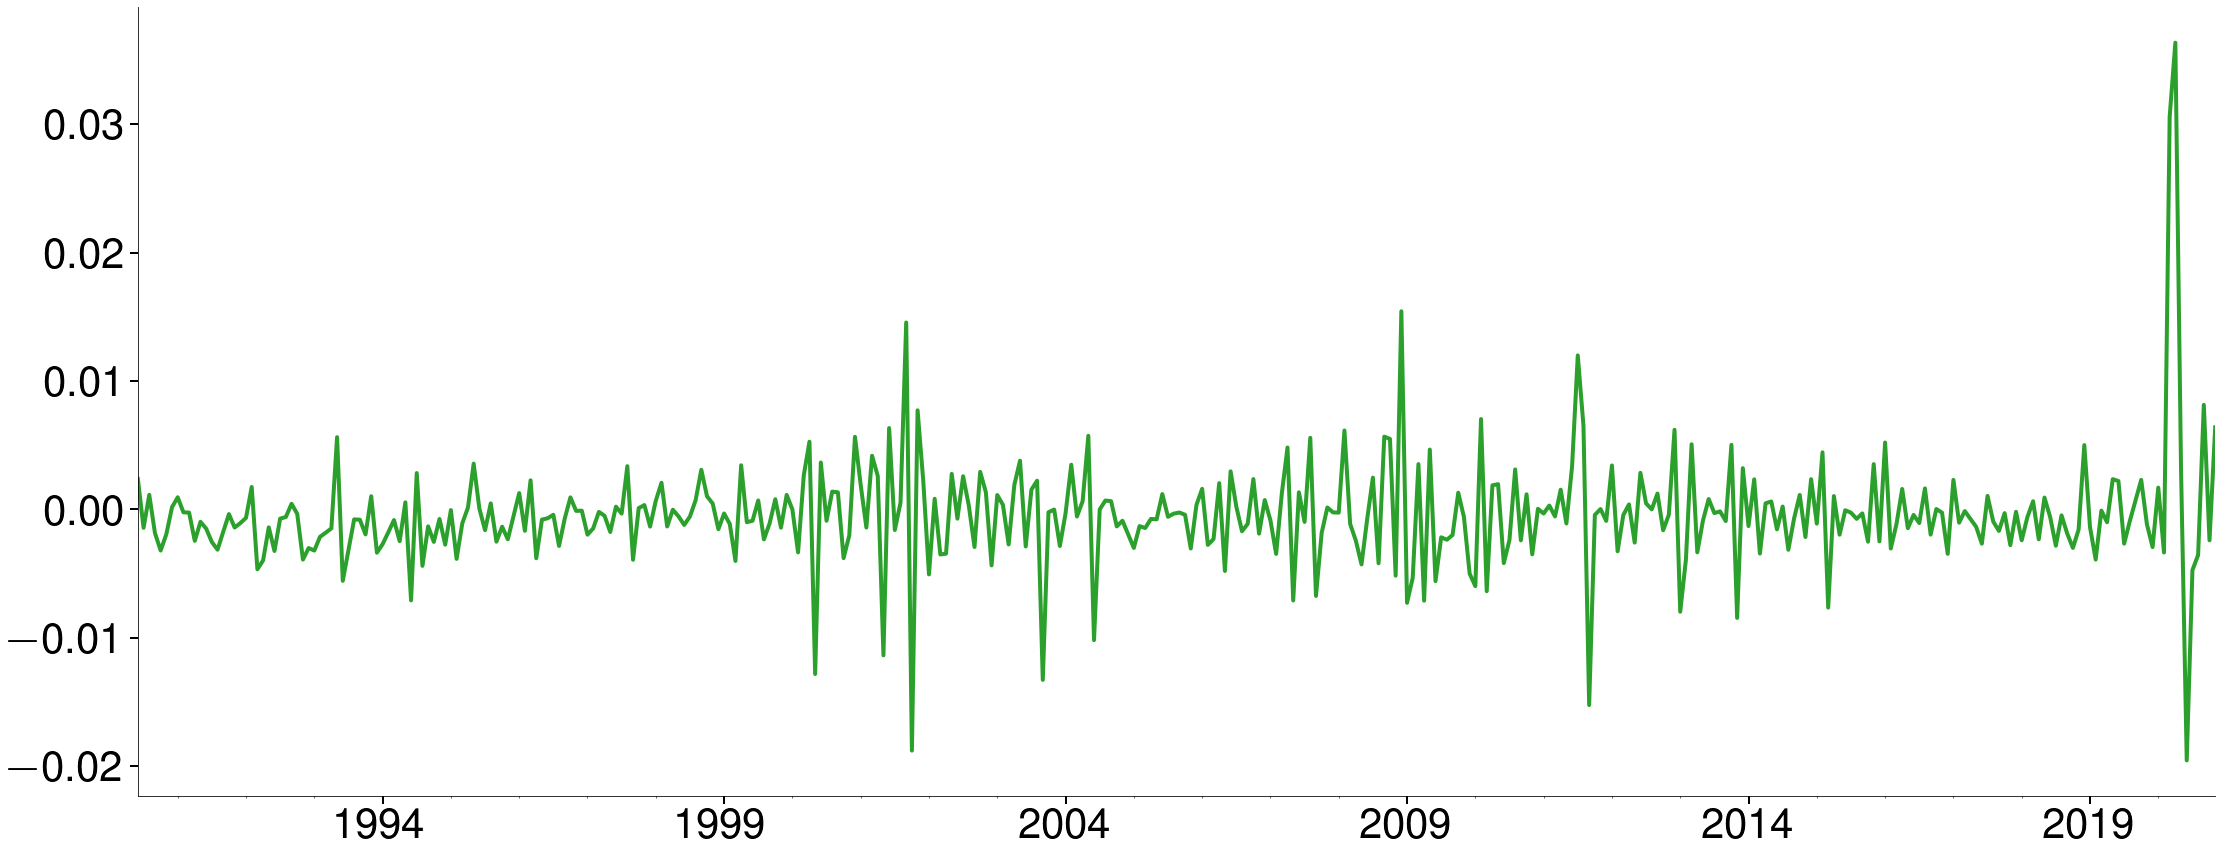

In [16]:
fe = (realizations - h1).dropna()
plot(fe, 13)

In [17]:
figsize()

# Forecast Error Autocorrelation

* 1-step should be a $WN$ process
* $h$-step should be at most a $MA(h-1)$

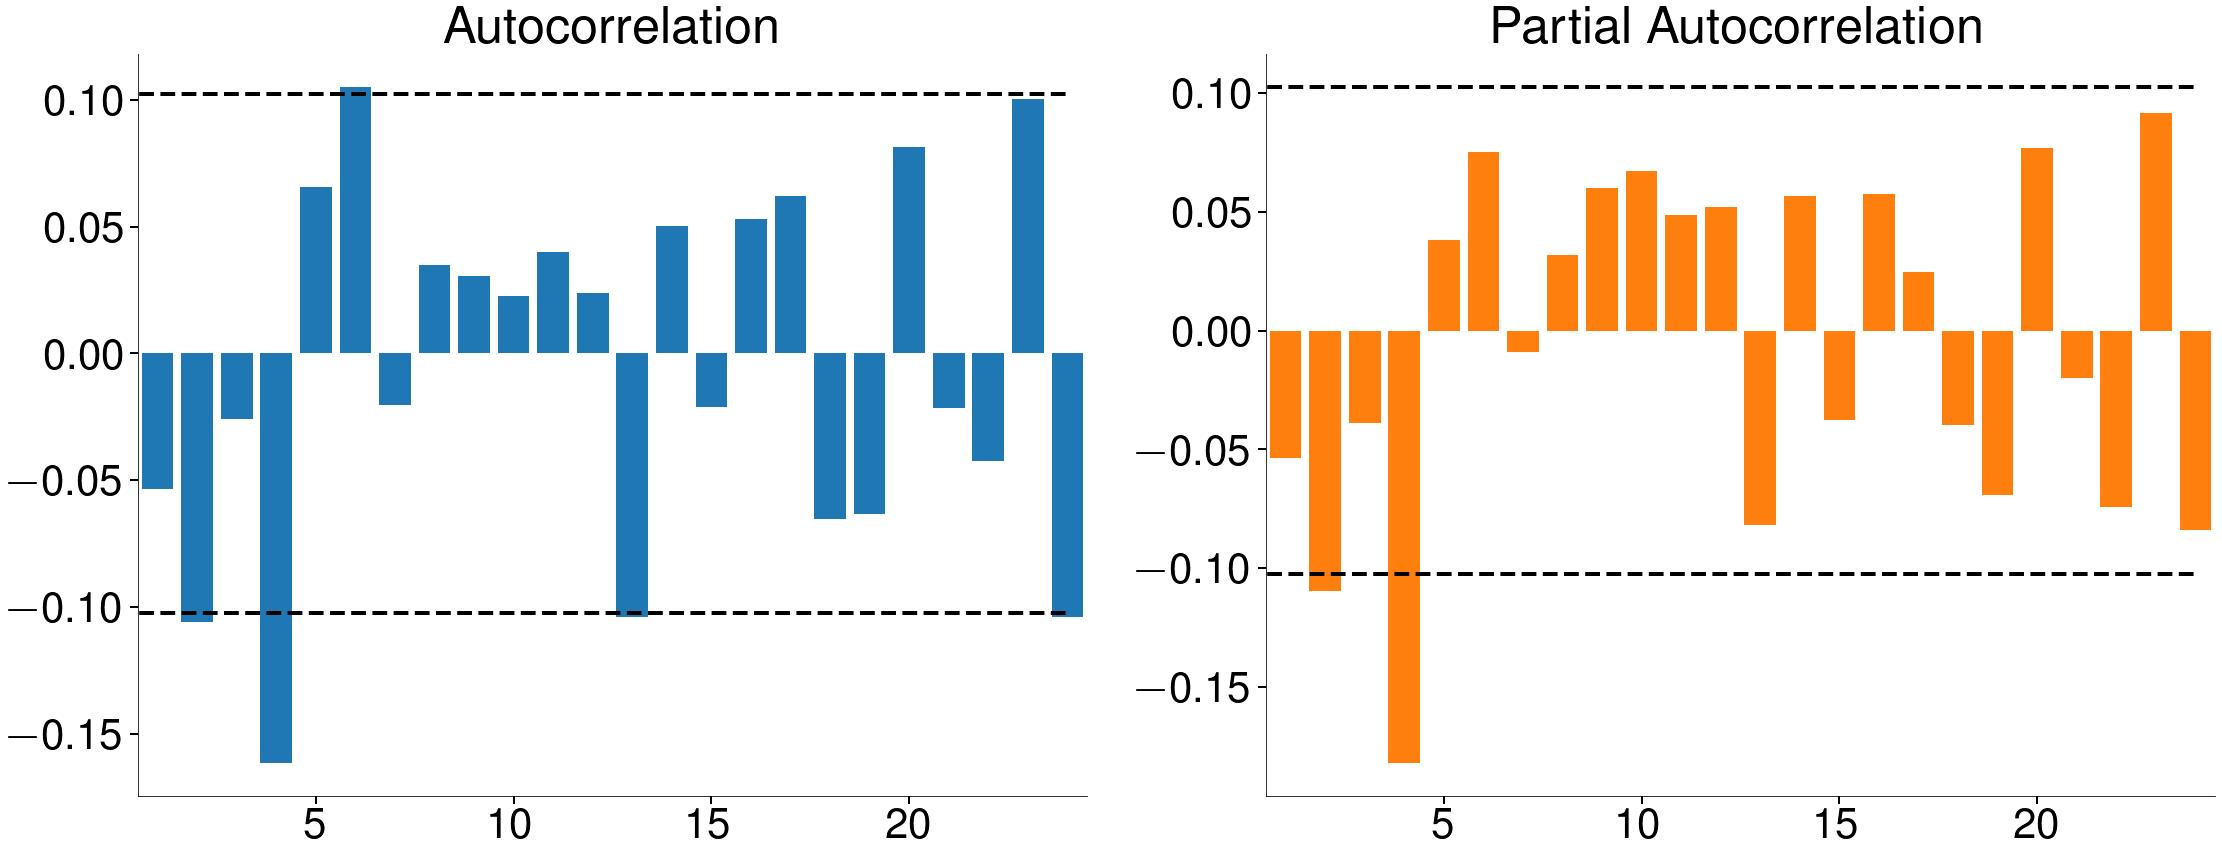

In [90]:
acf_pacf_plot(fe, 24, size=-2)

# Multi-step Forecasts

* Multi-step forecasts are recursively generated

In [19]:
t = m2_growth.shape[0]
half = t // 2

multistep_forecasts = {}
res = SARIMAX(m2_growth.iloc[:half], order=(1, 0, 0), trend="c").fit()
multistep_forecasts[half - 1] = res.forecast(12)
for i in range(half, t):
    res = res.extend(m2_growth.iloc[i : i + 1])
    multistep_forecasts[i] = res.forecast(12)
multistep_forecasts = pd.DataFrame(multistep_forecasts)


def multistep_forecast_plot():
    figsize(y=-2)
    fig, ax = plt.subplots(1, 1)
    multistep_forecasts.iloc[:, 1::12].plot(
        legend=False, ax=ax, marker="o", markersize=12, linestyle="none"
    )
    m2_growth.iloc[half::12].plot(
        ax=ax, alpha=0.5, color="k", linestyle="none", marker="s", markersize=20
    )
    m2_growth.iloc[half:].plot(ax=ax, alpha=0.25, color="k", linestyle=":")
    _ = ax.set_ylim(-0.005, 0.017)
    sns.despine()
    fig.tight_layout(pad=1.0)
    figsize()

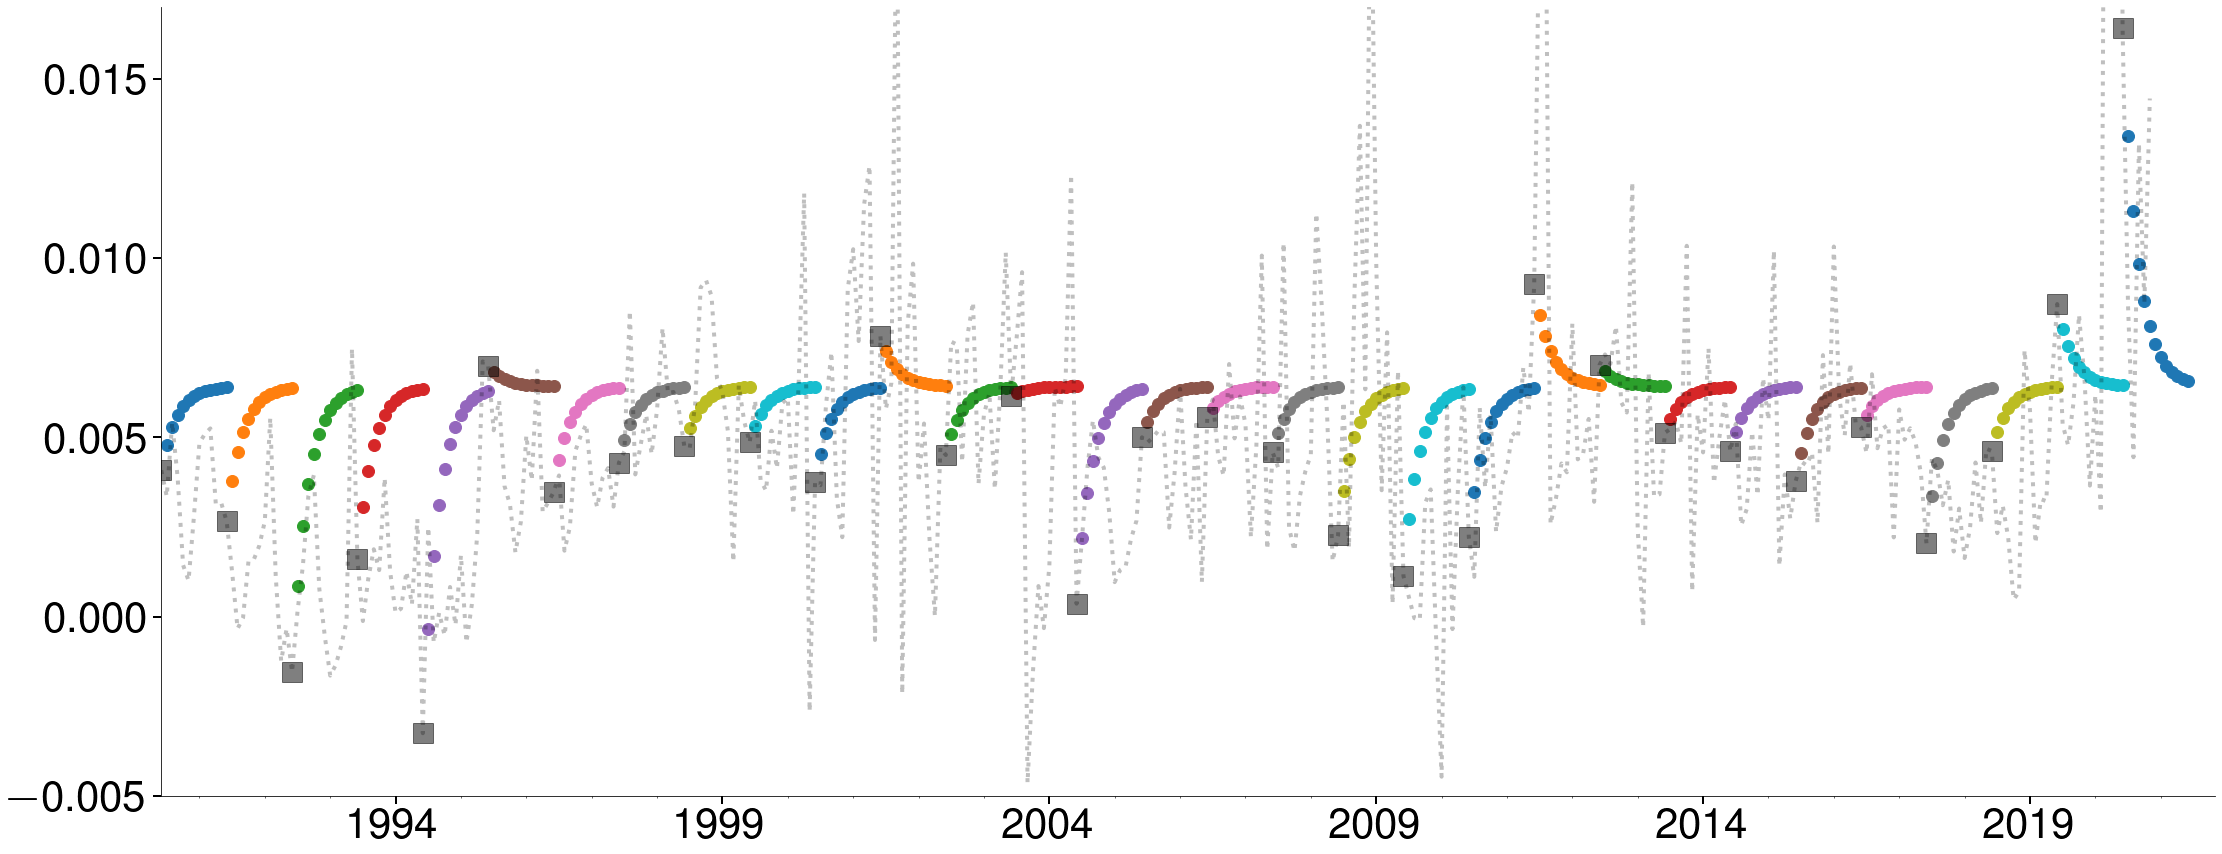

In [20]:
multistep_forecast_plot()

In [21]:
figsize()

# Multistep forecast errors

In [22]:
h12 = {}
for col in multistep_forecasts:
    idx = multistep_forecasts[col].dropna().index[-1]
    h12[idx] = multistep_forecasts.loc[idx, col]
h12 = pd.Series(h12)
fe_12 = (m2_growth - h12).dropna()

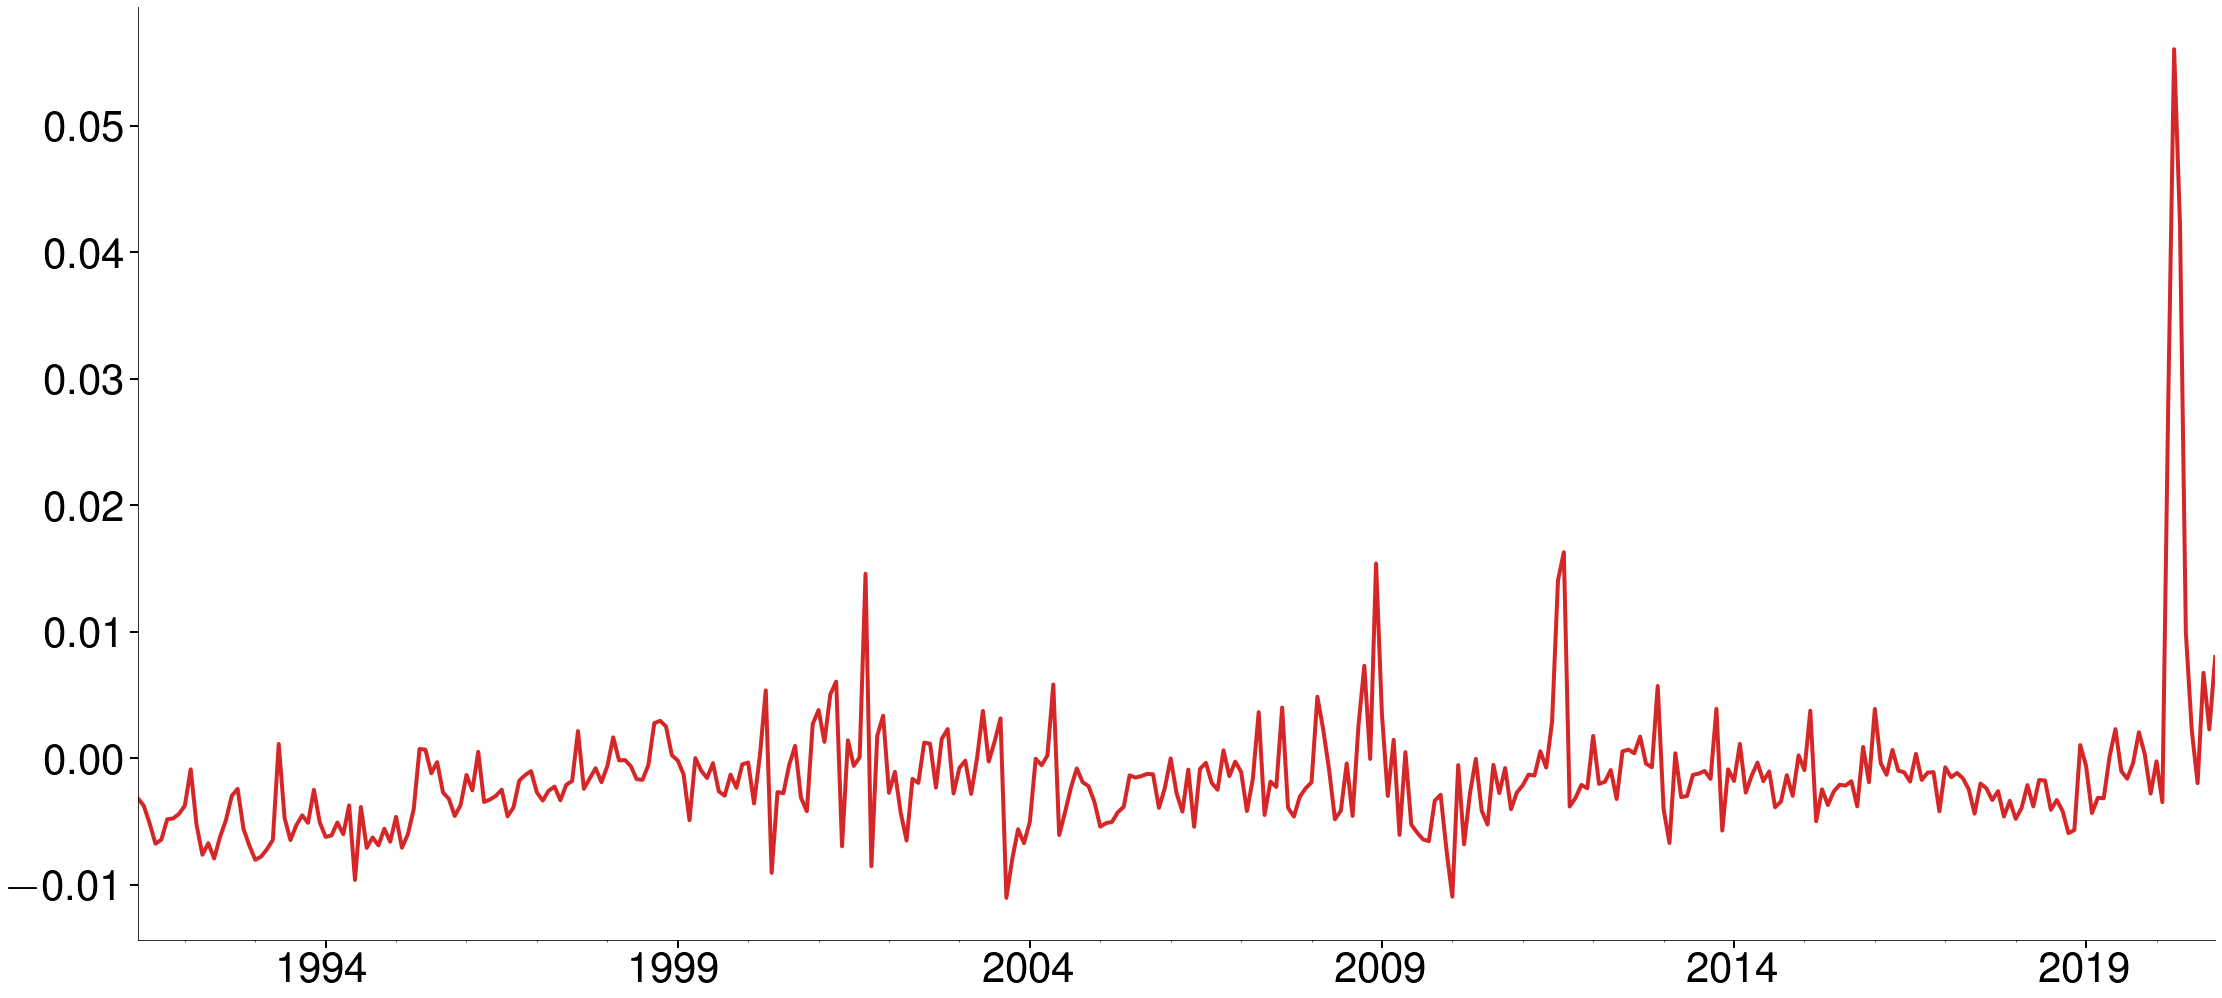

In [23]:
plot(fe_12)

# Multi-step forecast error dependence

* May have $h-1$ dependence if well specified

$$ Y_{t+2} - \mathrm{E}_t[Y_{t+2}] = {\color{red}{\epsilon_{t+2}}} + \phi_1 \epsilon_{t+1} $$
$$ Y_{t+3} - \mathrm{E}_t[Y_{t+3}] = \epsilon_{t+3} + \phi_1 {\color{red}{\epsilon_{t+2}}} $$

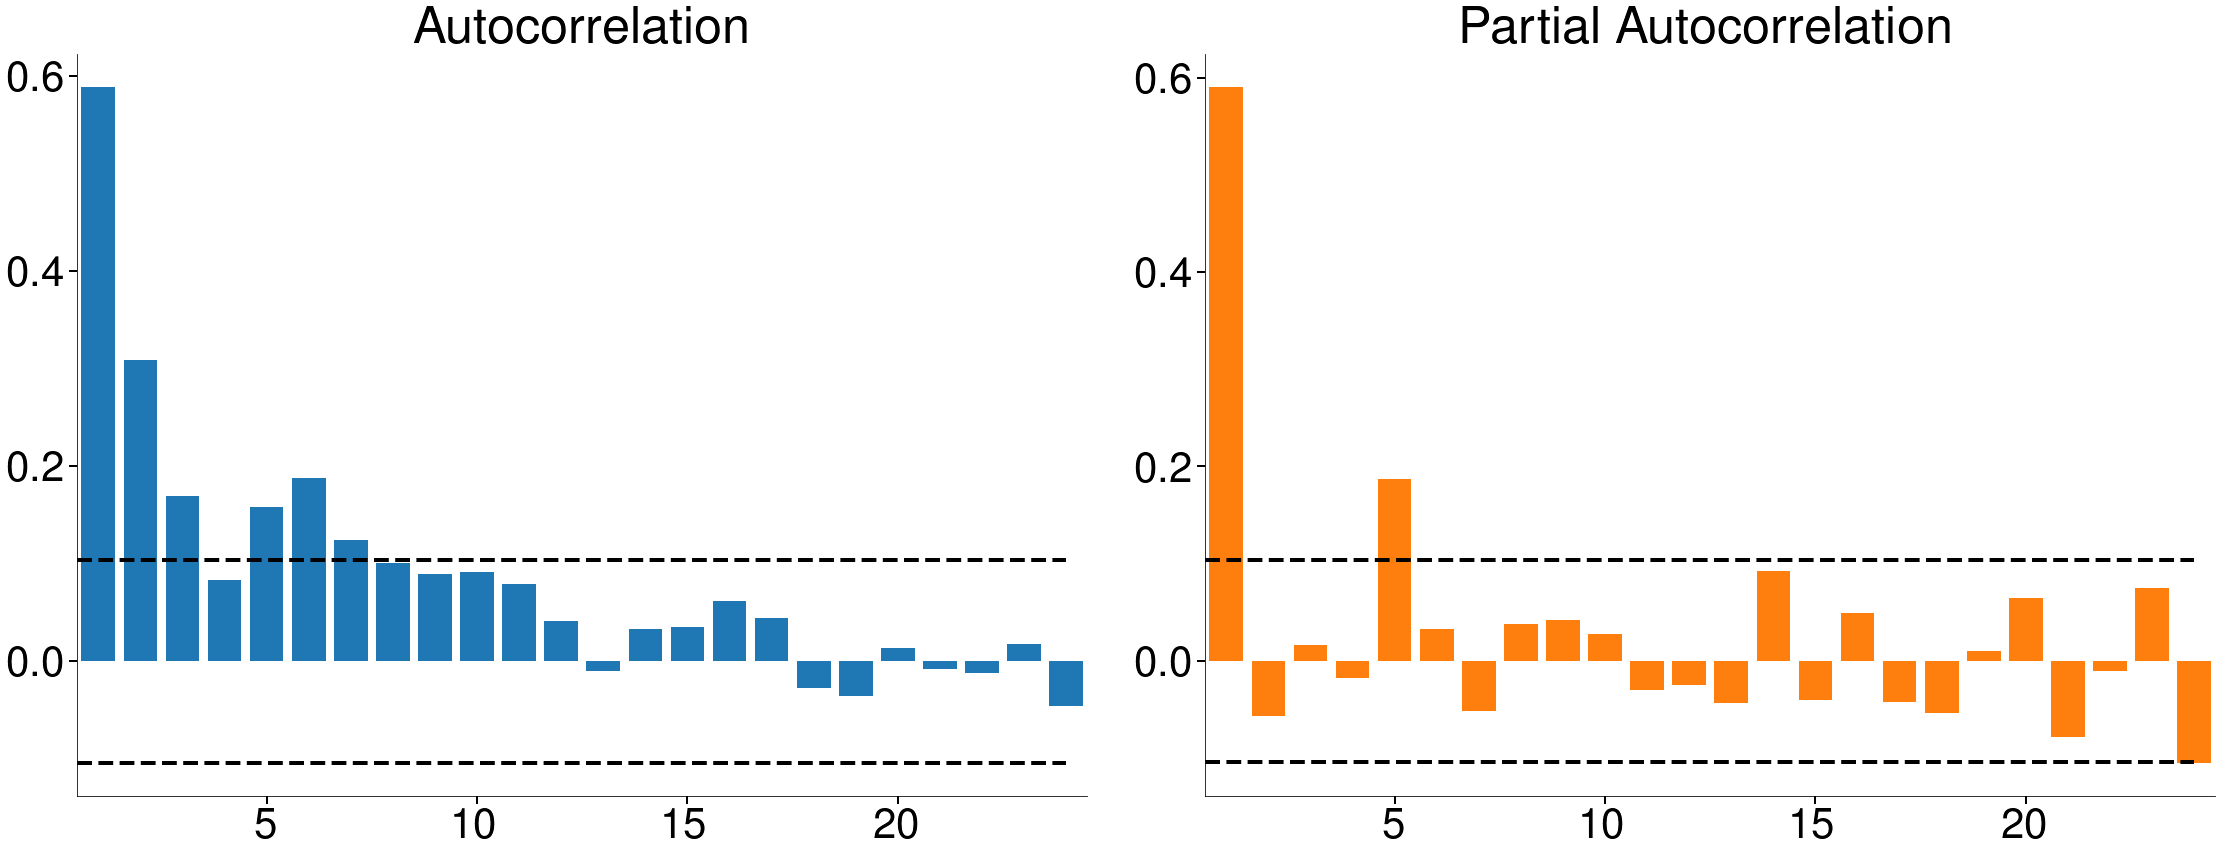

In [24]:
acf_pacf_plot(fe_12, 24, size=13)

# Mincer-Zarnowitz Regressions
* Regress realization on forecast

$$ Y_{t+1} = \alpha + \beta \hat{Y}_{t+1|t} + \eta_{t+1}  $$

* $\alpha$ should be 0
* $\beta$ should be 1

In [25]:
import statsmodels.api as sm

combined = pd.concat([fe, h1, realizations], axis=1).dropna()
combined.columns = ["fe", "h1", "realizations"]

In [26]:
mz = sm.OLS(realizations, sm.add_constant(combined["h1"])).fit()
summary(mz)

,coef,std err,t,P>|t|,[0.025,0.975]
const,0.0004,0.000,0.936,0.350,-0.000,0.001
h1,0.8481,0.061,13.985,0.000,0.729,0.967


# Testing MZ Coefficients

* Three possible nulls
  1.  $ H_0:\alpha=0$ ($t$-test, use $t$-stat)
  2.  $ H_0:\beta=1$ ($t$-test)
  3.  $ H_0:\alpha=0\cap \beta=1$ (Wald test)

In [27]:
mz.tvalues["const"]

0.9362189787611457

In [28]:
(mz.params["h1"] - 1) / mz.bse["h1"]

-2.504731229244801

In [29]:
stat = mz.wald_test((np.eye(2), [0, 1]), use_f=False)
stat

<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=[[9.93955905]], p-value=0.006944678984617448, df_denom=2>

# MZ interpretation

In [88]:
def mz_plot():
    figsize()
    fig, ax = plt.subplots(1, 1)
    combined.plot.scatter(x="h1", y="realizations", ax=ax, s=192, marker="o")
    xl = ax.get_xlim()
    yl = ax.get_ylim()
    lim = (min(xl[0], yl[0]), max(xl[1], yl[1]))
    a, b = mz.params

    ax.plot(lim, lim, "k:", label="$45^o$ line", linewidth=8)
    ax.plot(
        lim,
        a + b * np.array(lim),
        "--",
        color=mfe.colors[3],
        label="Regression line",
        linewidth=8,
    )
    ax.legend(frameon=False)
    ax.set_ylabel("$Y_{t+1}$")
    ax.set_xlabel("$Y_{t+1|t}$")
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    sns.despine()
    fig.tight_layout(pad=1.0)
    figsize()

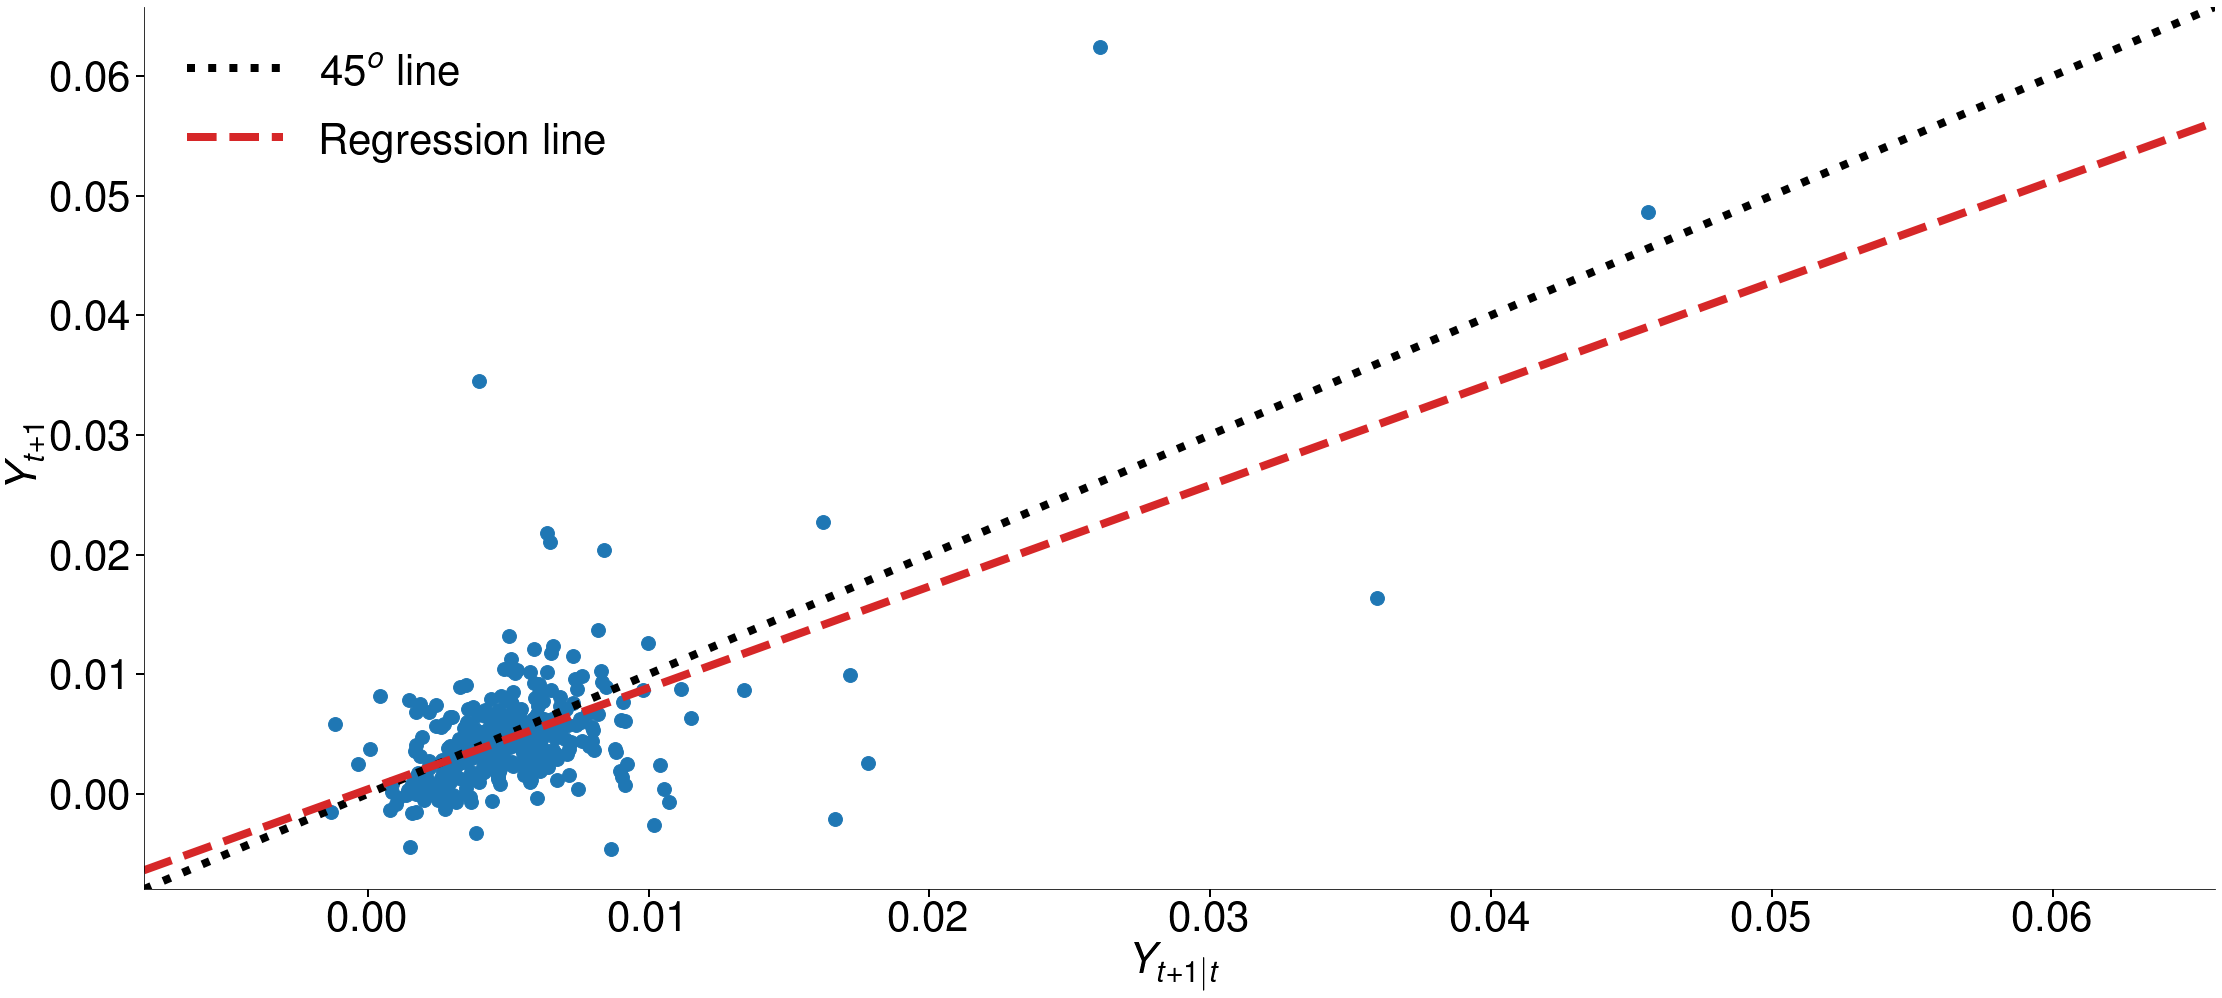

In [89]:
mz_plot()

In [32]:
figsize()

# Simpler MZ Testing

* Regress _forecast error_

$$ Y_{t+h} - \hat{Y}_{t+h|t} = \alpha + \beta \hat{Y}_{t+h|t} + \eta_{t+h} $$

* $\alpha=\beta=0$ when correct

In [33]:
mz2 = sm.OLS(combined.fe, sm.add_constant(combined.h1)).fit()
summary(mz2)

,coef,std err,t,P>|t|,[0.025,0.975]
const,0.0004,0.000,0.936,0.350,-0.000,0.001
h1,-0.1519,0.061,-2.505,0.013,-0.271,-0.033


# Updating model parameters

* Can re-estimate model parameters after each new observation (recursive scheme)
* Alternatively could keep sample size fixed and update (rolling scheme)

In [34]:
import warnings

t = m2_growth.shape[0]
half = t // 2

recursive = []
rolling = []
for i in range(half, t):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        res = SARIMAX(m2_growth.iloc[:i], order=(1, 0, 0), trend="c").fit()
        recursive.append(res.forecast(1))
        res = SARIMAX(m2_growth.iloc[i - half : i], order=(1, 0, 0), trend="c").fit()
        rolling.append(res.forecast(1))
recursive = pd.concat(recursive)
recursive.name = "recursive"
rolling = pd.concat(rolling)
rolling.name = "rolling"
combined = pd.concat([h1, recursive, rolling, realizations], axis=1).dropna()
combined.columns = ["h1", "recursive", "rolling", "realizations"]

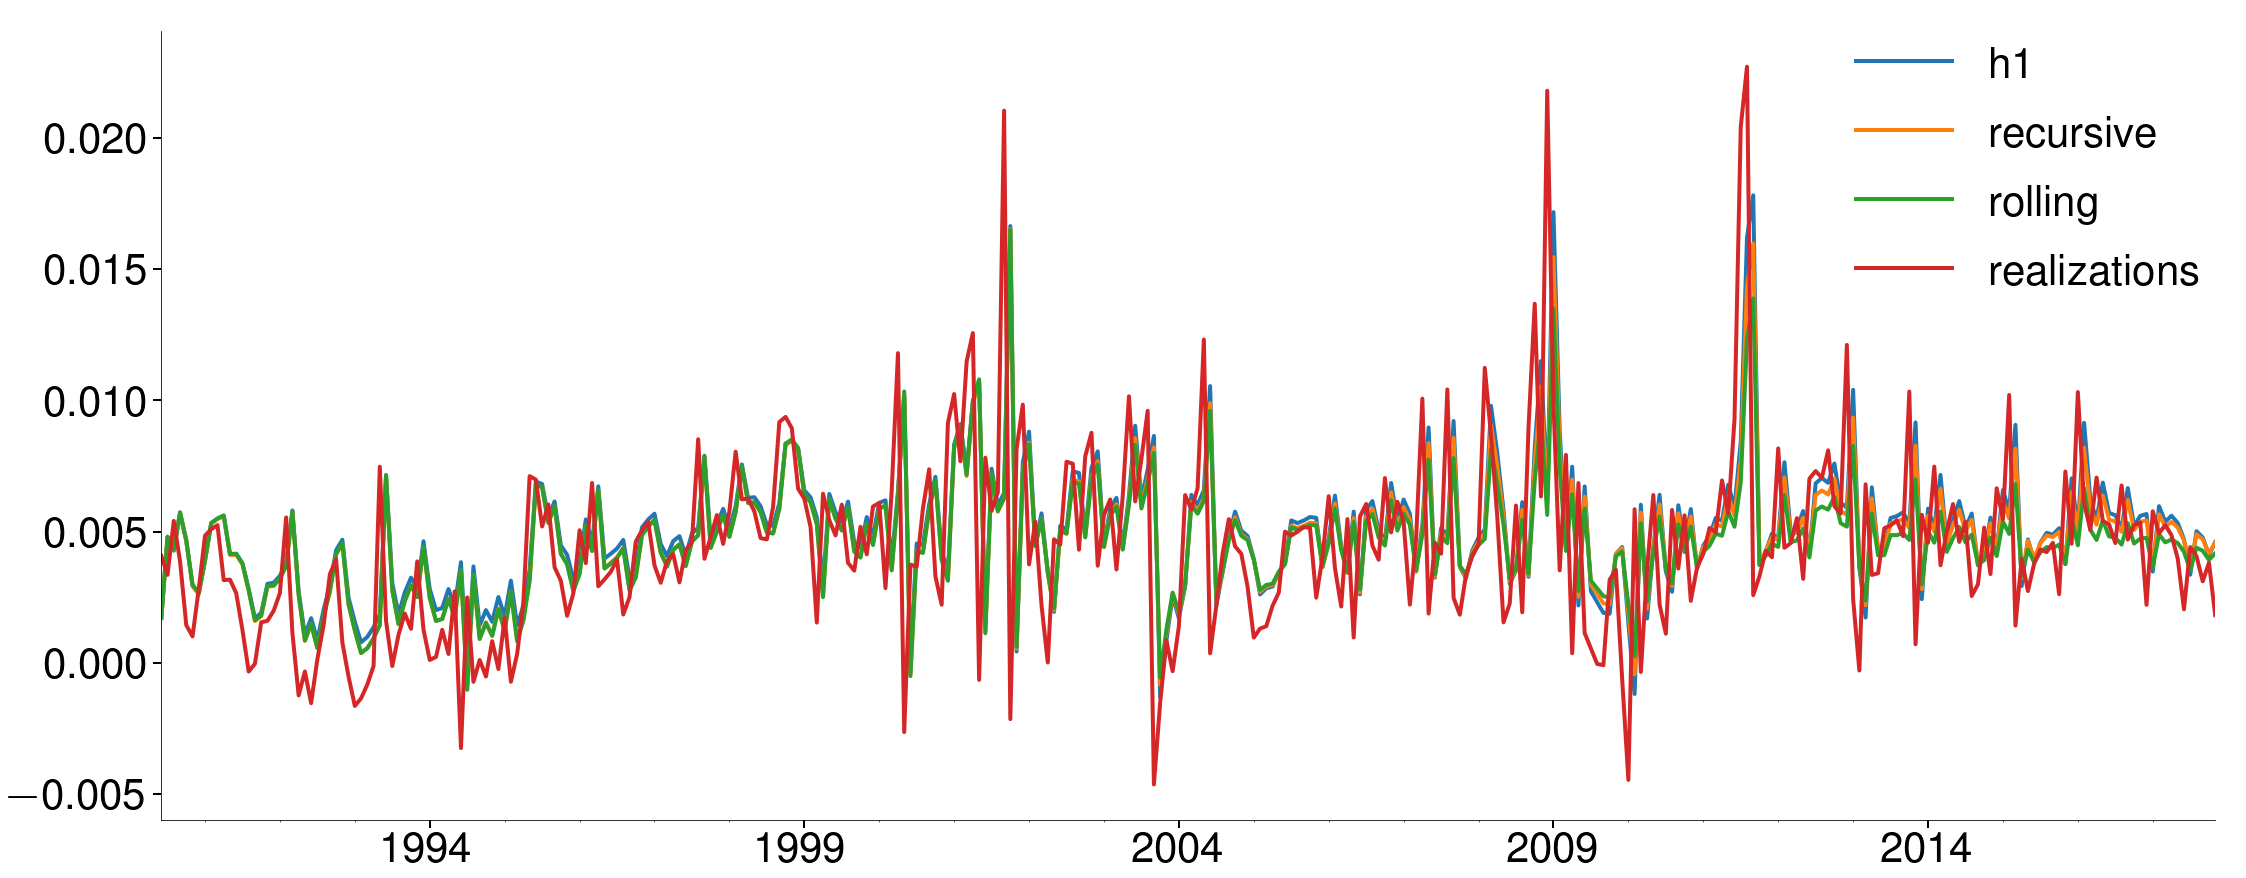

In [35]:
plot(combined[["h1", "recursive", "rolling", "realizations"]].iloc[:-36], y=13)

# Diebold-Mariano Testing

* Test equality of prediction accuracy
* Test statistic based on the loss difference between two forecasts

$$ \delta_t = l^A_t - l^B_t $$

* Requires _Newey-West_ covariance since $\{\delta_t \}$ may be autocorrelated
* Apply to MSE Loss

$$ l_t = (Y_{t+h} - \hat{Y}_{t+h|t})^2 $$

In [36]:
rw = m2_growth.shift(-1)
rw.name = "rw"
combined = pd.concat([combined, rw], axis=1).dropna()

In [37]:
l_a = (combined.realizations - combined.h1) ** 2
l_b = (combined.realizations - combined.rw) ** 2
print(l_a.mean(), l_b.mean())
delta = l_a - l_b

1.947078781444988e-05 2.3835737833687686e-05


# DM as an OLS Regression

$$ \delta_t = \beta + \epsilon_t $$

* $\hat{\beta}=\bar{\delta} $
* Simple to use Newey-West covariance

In [38]:
mod = sm.OLS(delta, np.ones_like(delta))
dm_res = mod.fit(cov_type="HAC", cov_kwds={"maxlags": int(t ** (1 / 3))})
summary(dm_res)

,coef,std err,z,P>|z|,[0.025,0.975]
const,-4.365e-06,2.16e-06,-2.017,0.044,-8.61e-06,-1.24e-07


# Loss difference $\delta_t$

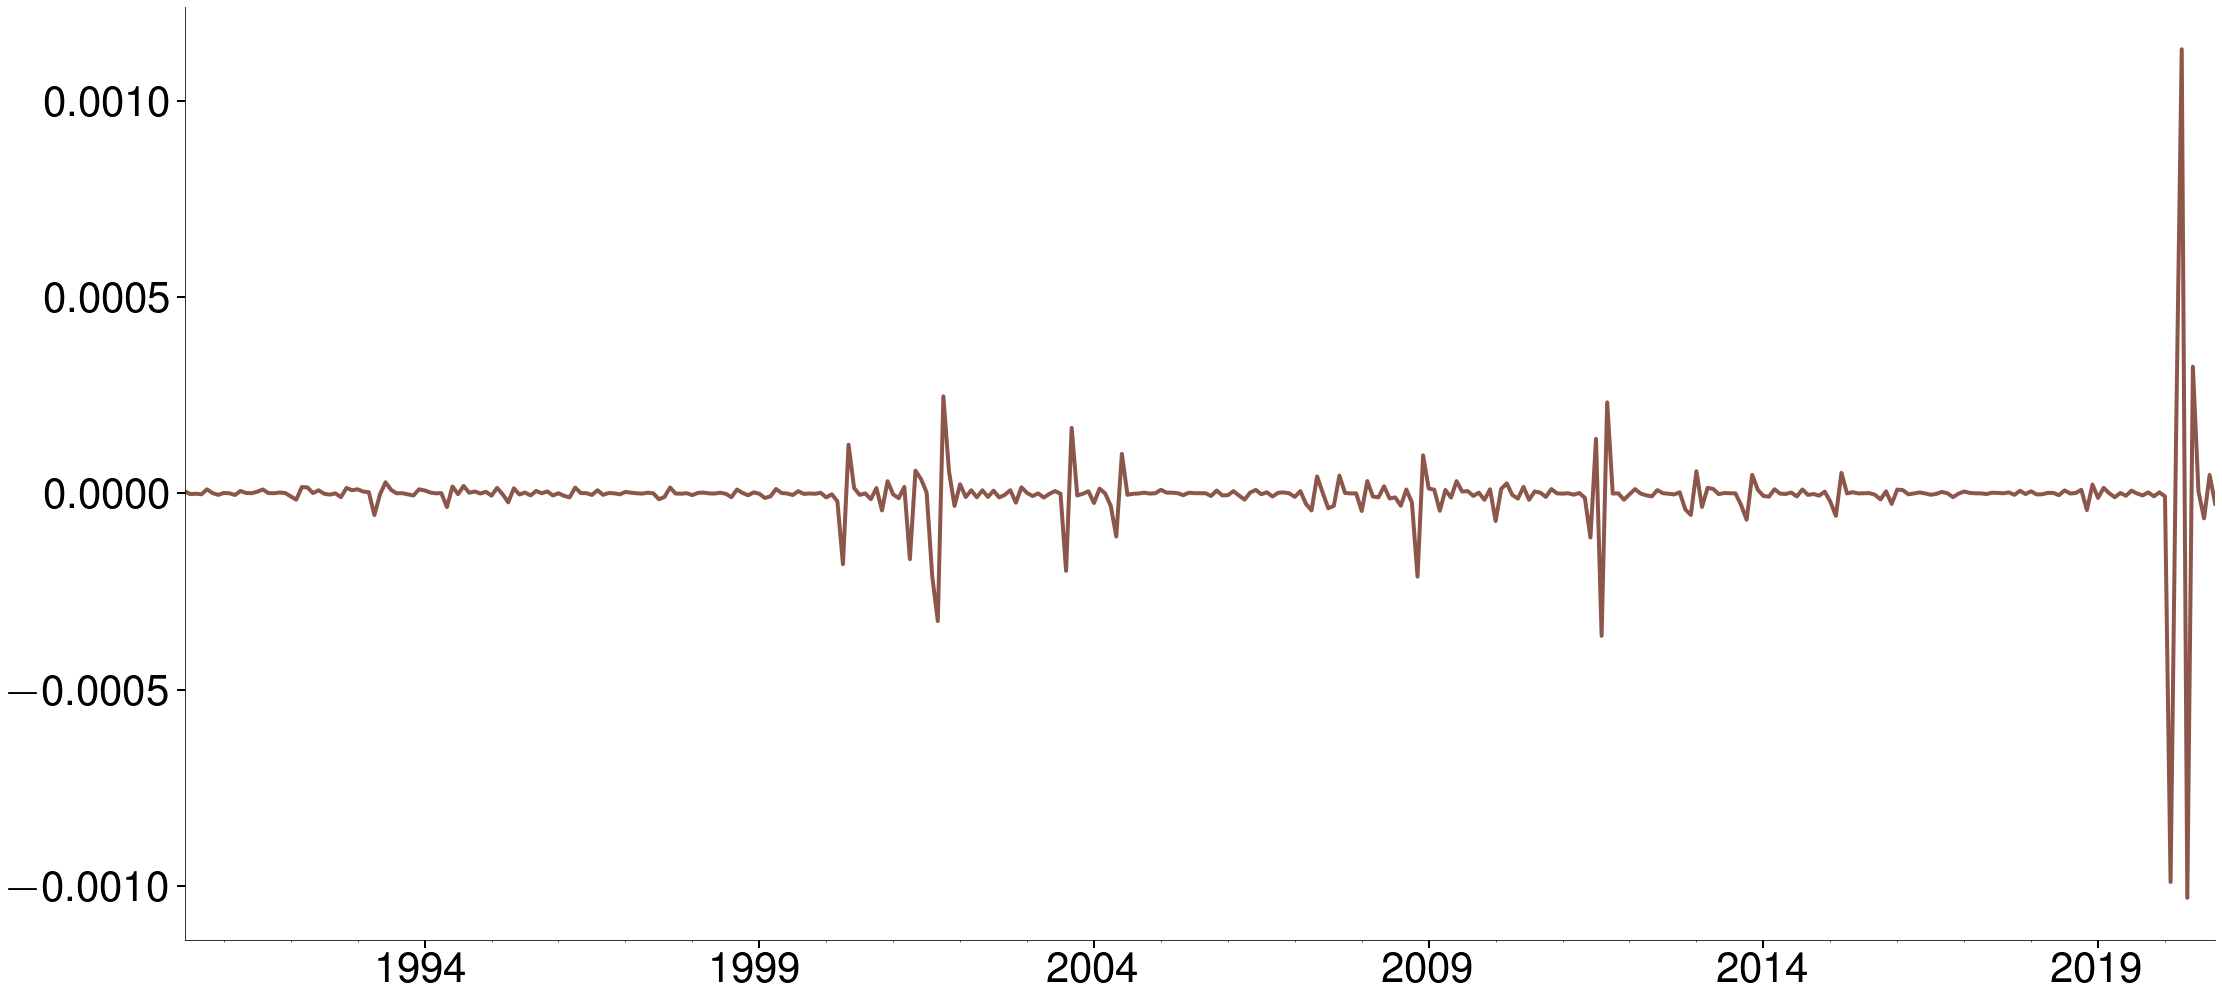

In [39]:
plot(delta)

# Mean Absolute Error

* DM can be used with any loss function
* MAE is defined

$$ l_t = |Y_{t+h} - \hat{Y}_{t+h|t}| $$

In [40]:
la = np.abs(combined.realizations - combined.h1)
lb = np.abs(combined.realizations - combined.rw)
delta = la - lb
mod = sm.OLS(delta, np.ones_like(delta))
dm_mae_res = mod.fit(cov_type="HAC", cov_kwds={"maxlags": int(t ** (1 / 3))})
summary(dm_mae_res)

,coef,std err,z,P>|z|,[0.025,0.975]
const,-0.0003,0.000,-2.358,0.018,-0.000,-4.27e-05


# $\delta_t$ dependence

* No assumption that models are correctly specified
* $\delta_t$ may be autocorrelated

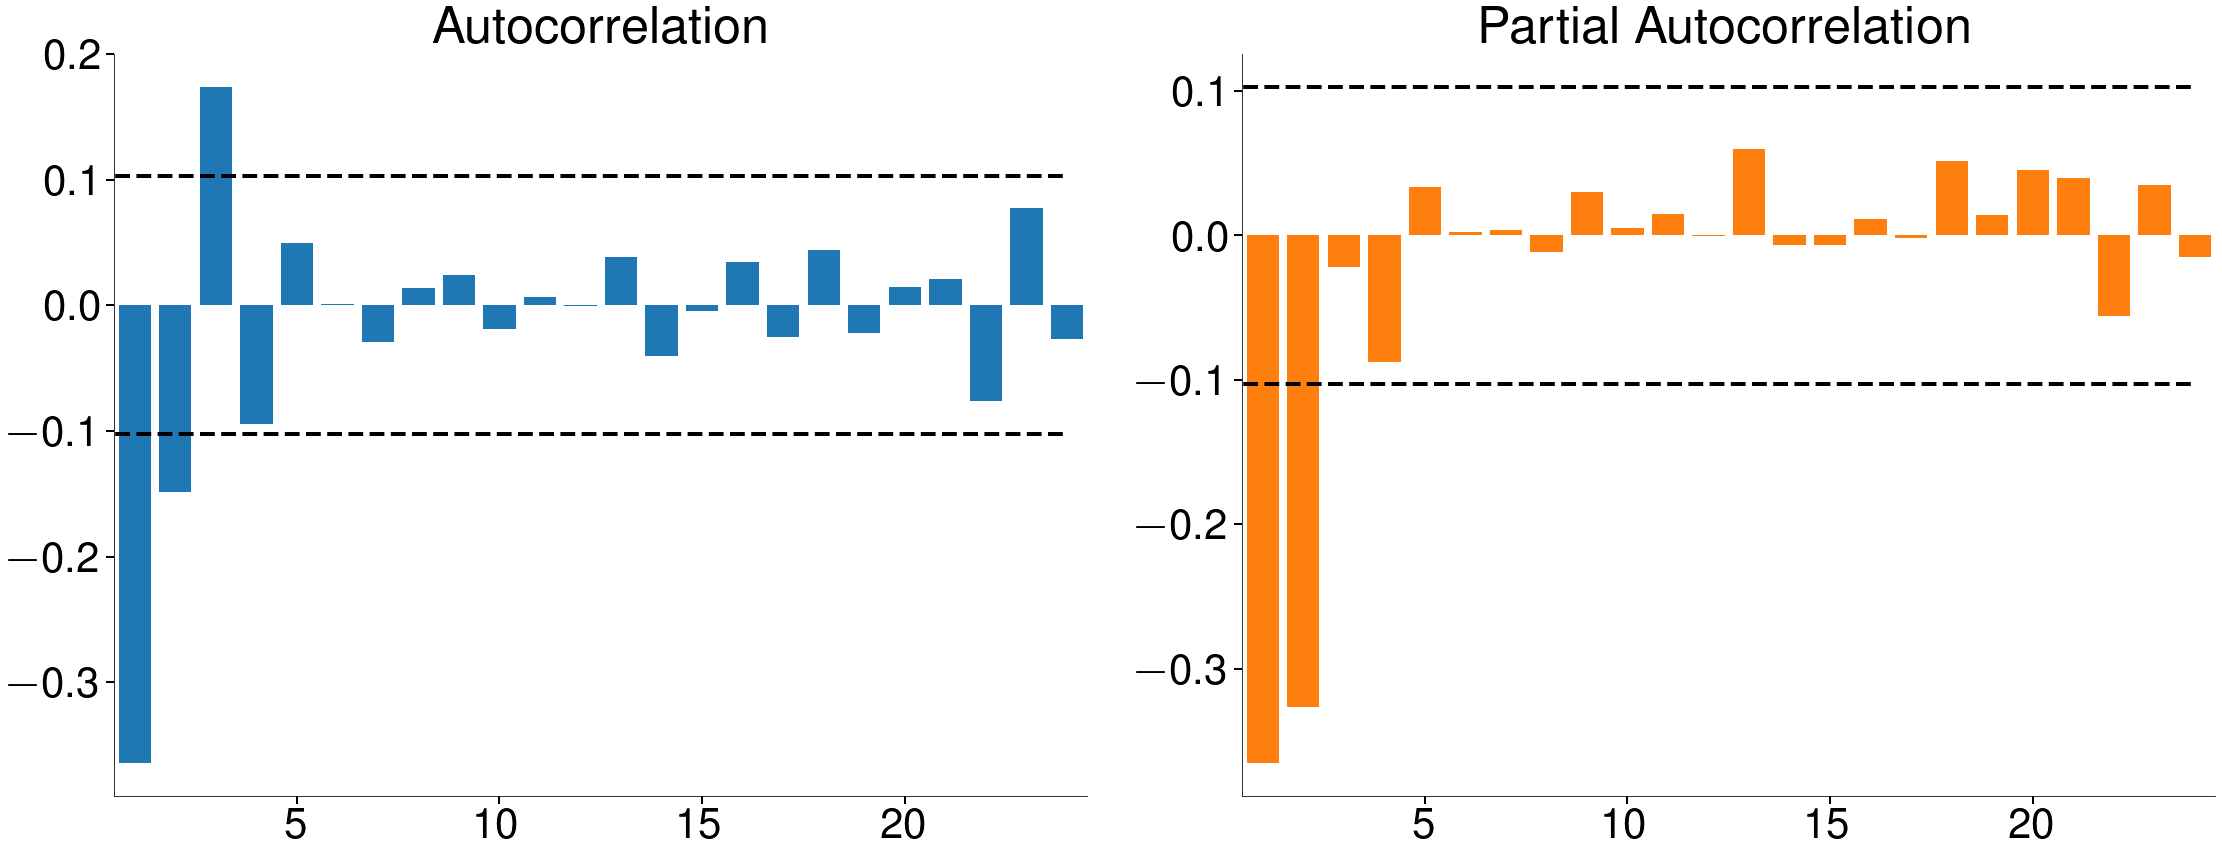

In [41]:
acf_pacf_plot(delta, 24, size=13)

# Cross-Validation of Time Series

1. Split data into $k$ contiguous blocks
2. For $i=1,\ldots,k-1$ using observations in block ${1,2,\ldots,i}$ to forecast values in block $i+1$
3. Compute out-of-sample $SSE$ for $k-1$ blocks
4. Select model that produces smallest out-of-sample $SSE$

# VIX

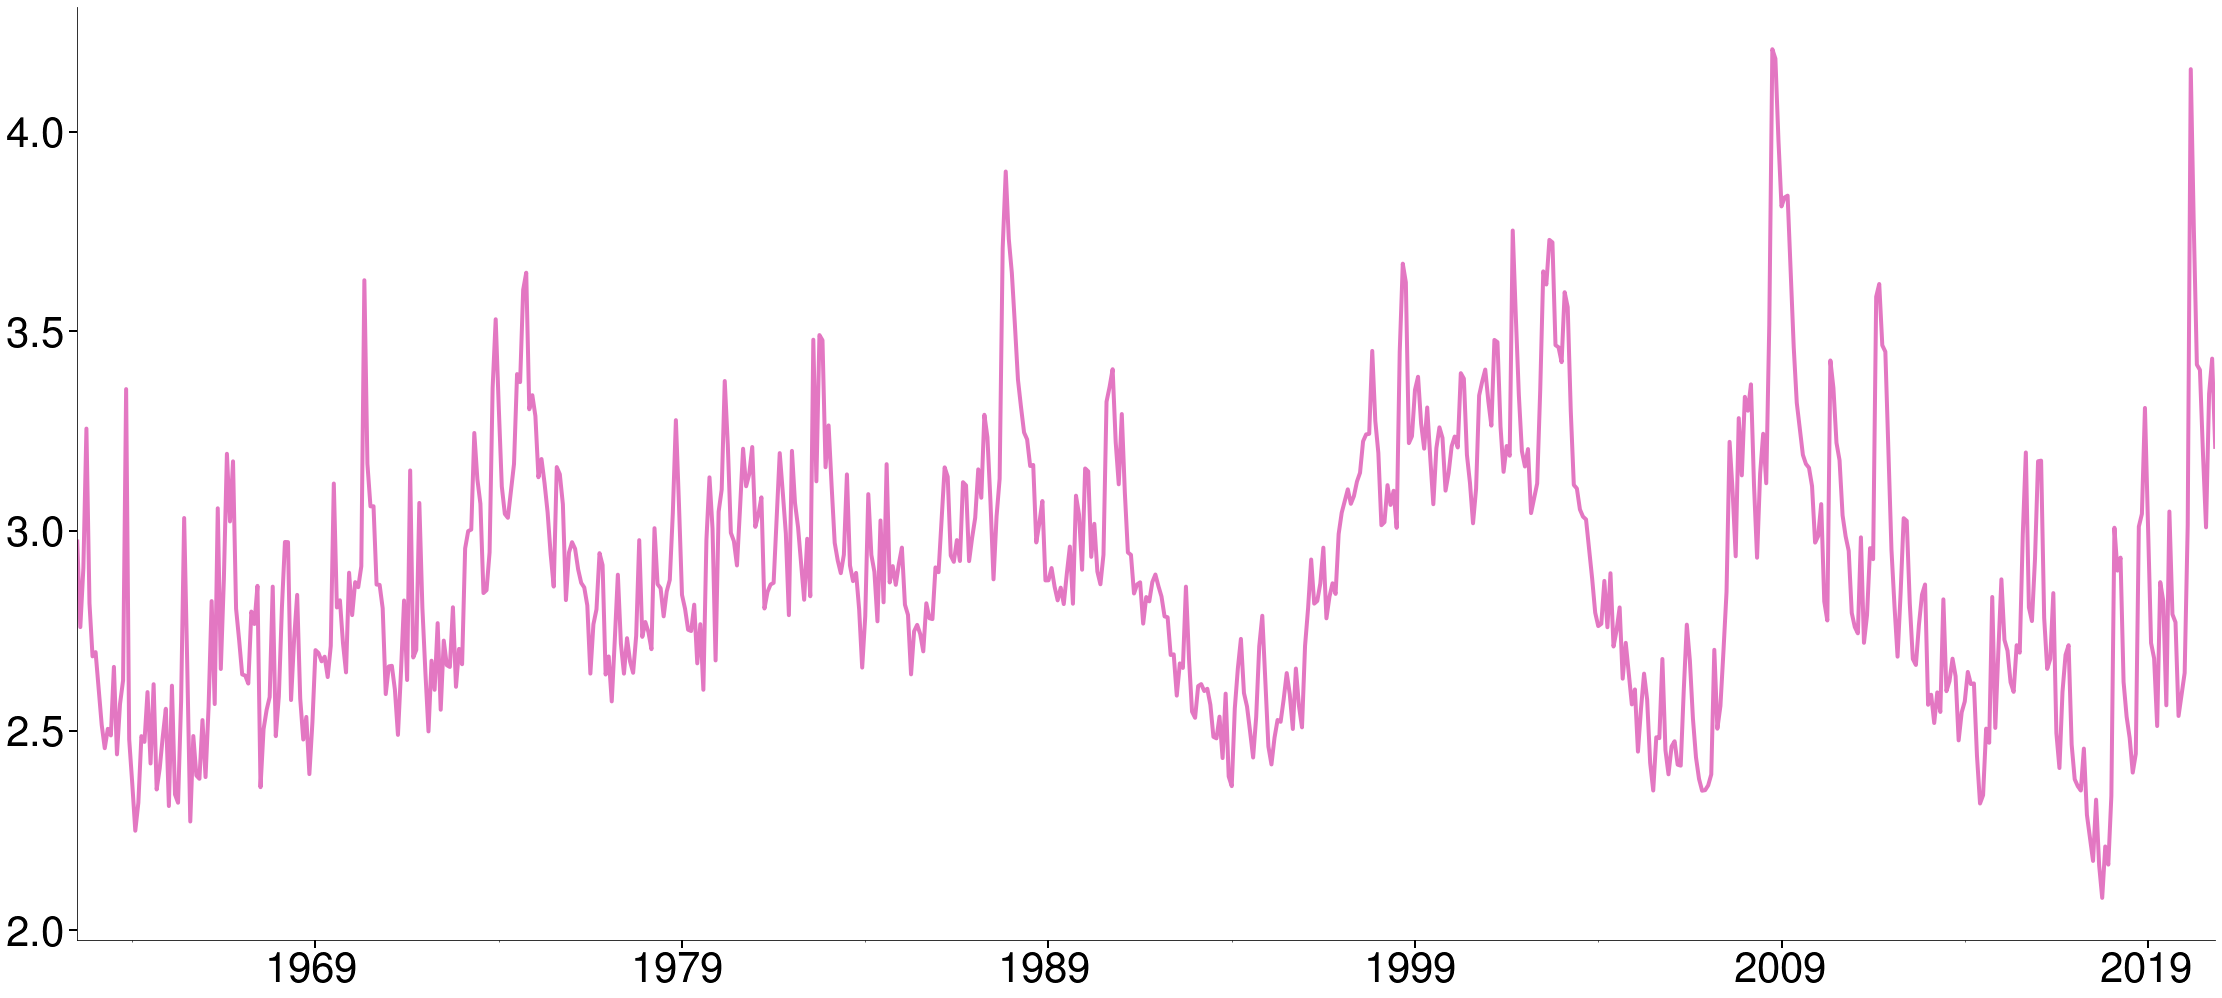

In [42]:
plot(vix)

In [43]:
splits = np.linspace(0, t - 1, 6, dtype=int)[1:]

ic = {}
oos_sse = {}
for p in range(1, 13):
    forecasts = []
    for i, last in enumerate(splits[:-1]):
        y = vix.iloc[:last]
        oos = vix.iloc[last : splits[i + 1]]
        res = SARIMAX(y, order=(p, 0, 0), trend="c").fit()
        res = res.extend(oos)
        pred = res.get_prediction().predicted_mean
        forecasts.append(pred)
    forecasts = pd.concat(forecasts)
    errors = vix - forecasts
    oos_sse[p] = ((errors.dropna()) ** 2).sum()
    res = SARIMAX(vix, order=(p, 0, 0), trend="c").fit()
    ic[p] = pd.Series([res.aic, res.bic], index=["AIC", "BIC"])
oos_sse = pd.Series(oos_sse)
ic = pd.DataFrame(ic).T

# Out-of-sample SSE

In [44]:
print("Splits:")
print(splits)
print("\nOOS SSE:")
oos_sse

Splits:
[146 292 438 584 730]

OOS SSE:


1     16.848481
2     16.647000
3     16.540600
4     16.426092
5     16.019054
6     16.090477
7     16.052844
8     16.050795
9     16.040110
10    16.056220
11    16.116910
12    16.123724
dtype: float64

# Out-of-sample SSE

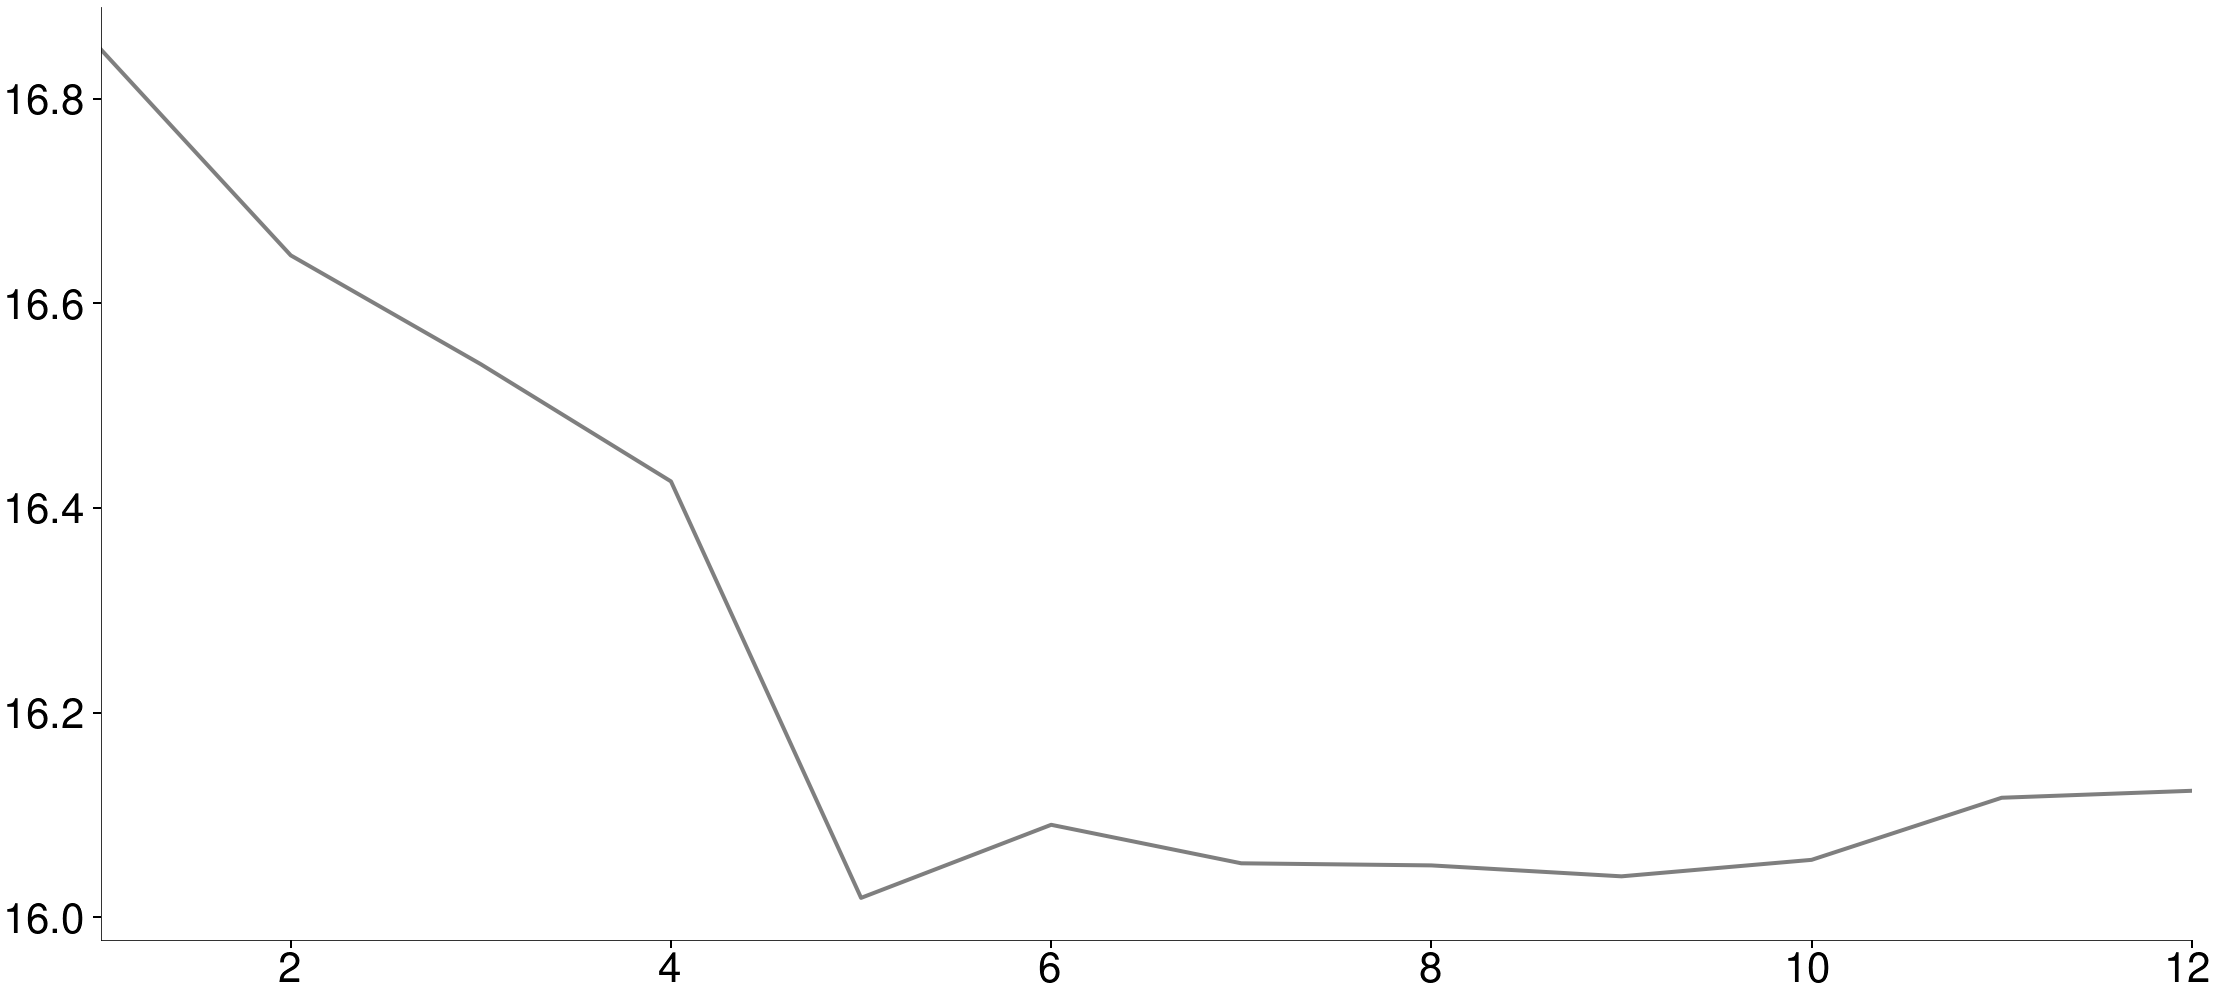

In [45]:
plot(oos_sse)

In [46]:
def plot_sse_ic():
    sse_ = oos_sse - oos_sse.min()
    sse_ /= sse_.max()
    sse_.name = "SSE"
    ic_ = ic - ic.min()
    ic_ /= ic_.max()
    both = pd.concat([sse_, ic_], axis=1)
    cols = [f"{col} $(P^\star={both[col].idxmin()})$" for col in both]
    both.columns = cols
    fig, ax = plt.subplots(1, 1)
    both.plot(ax=ax, legend=False, marker="s", linestyle="none", markersize=32)
    fig.legend(frameon=False, loc=9, ncol=3)
    sns.despine()
    fig.tight_layout(pad=1.0)

# CV and IC Selection

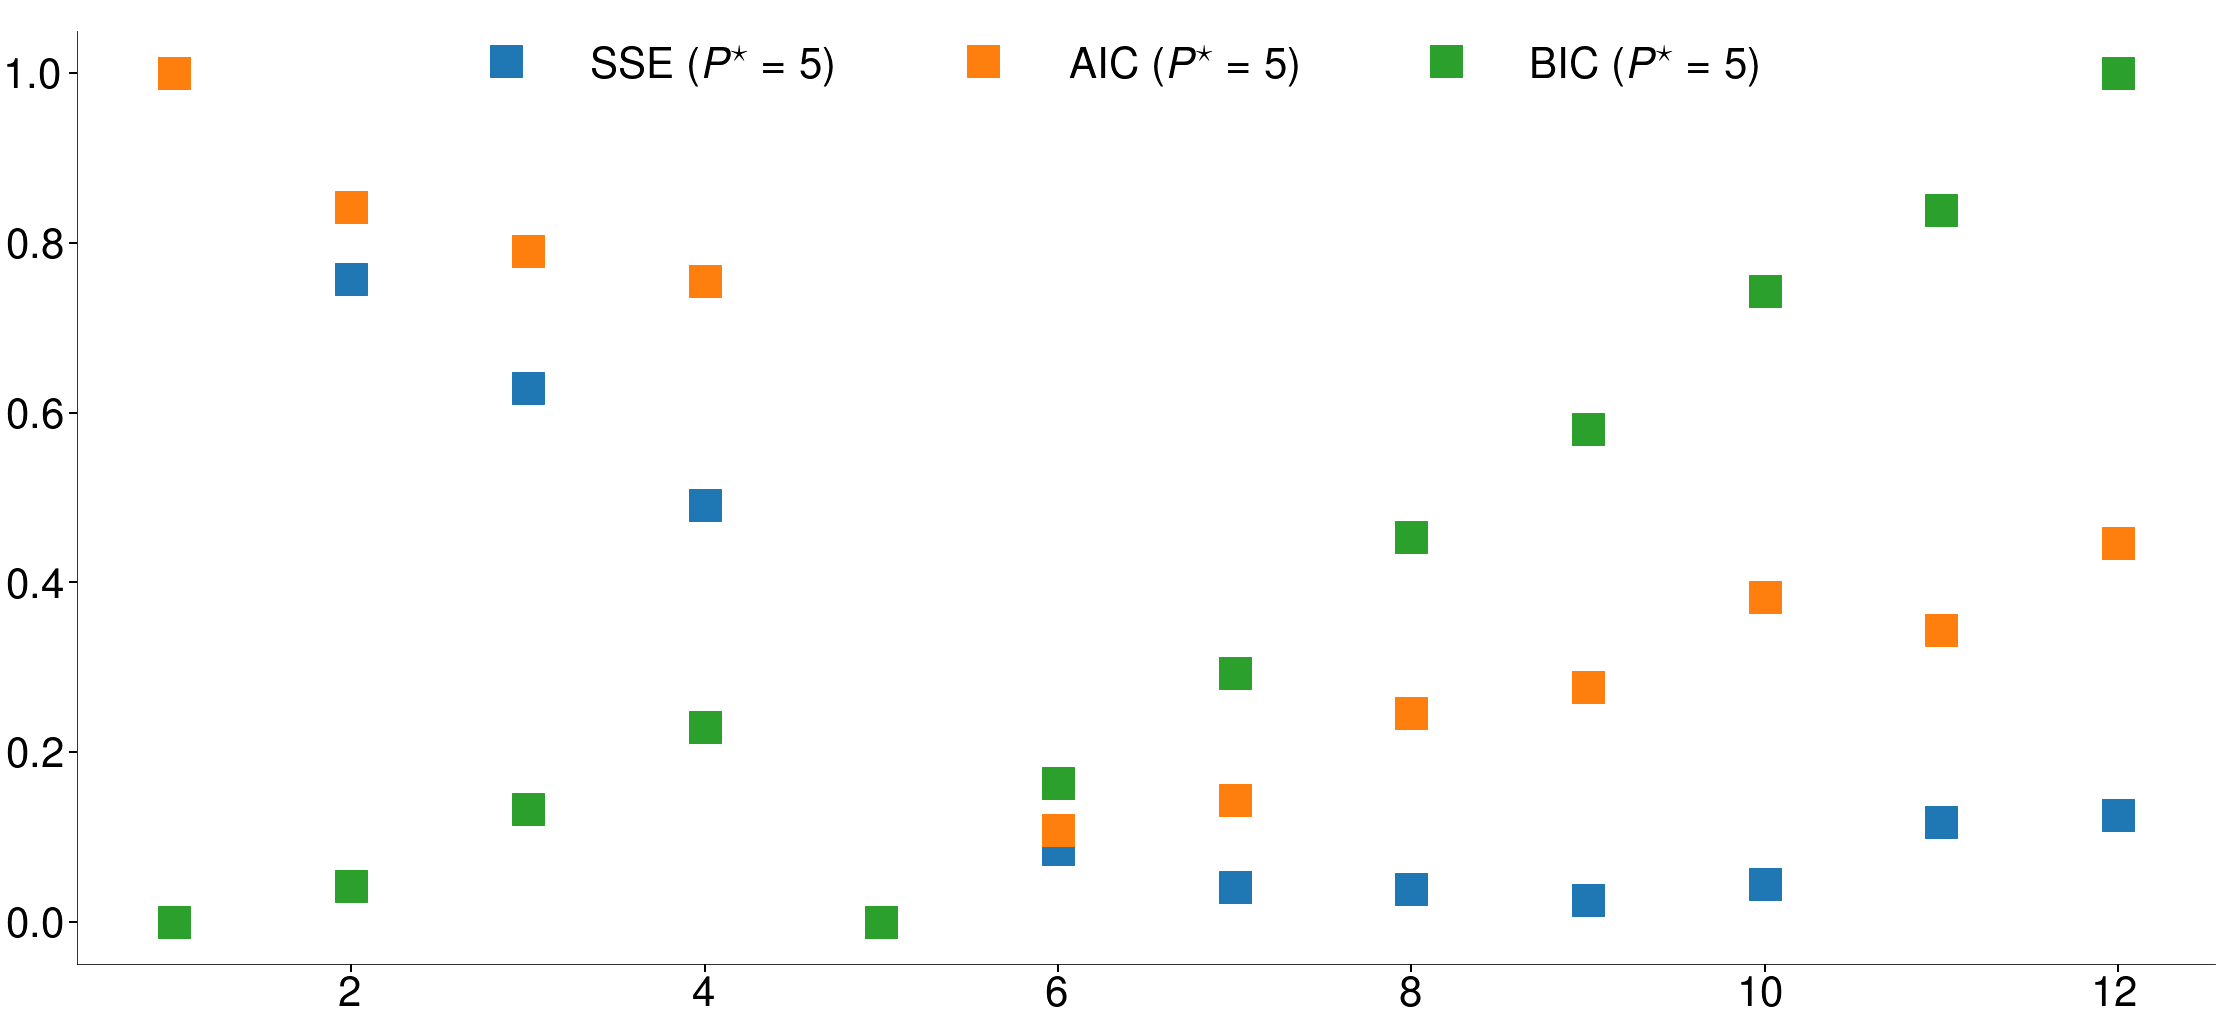

In [47]:
plot_sse_ic()

# Seasonality

* A seasonal time series has a deterministic pattern that repeats on an annual basis

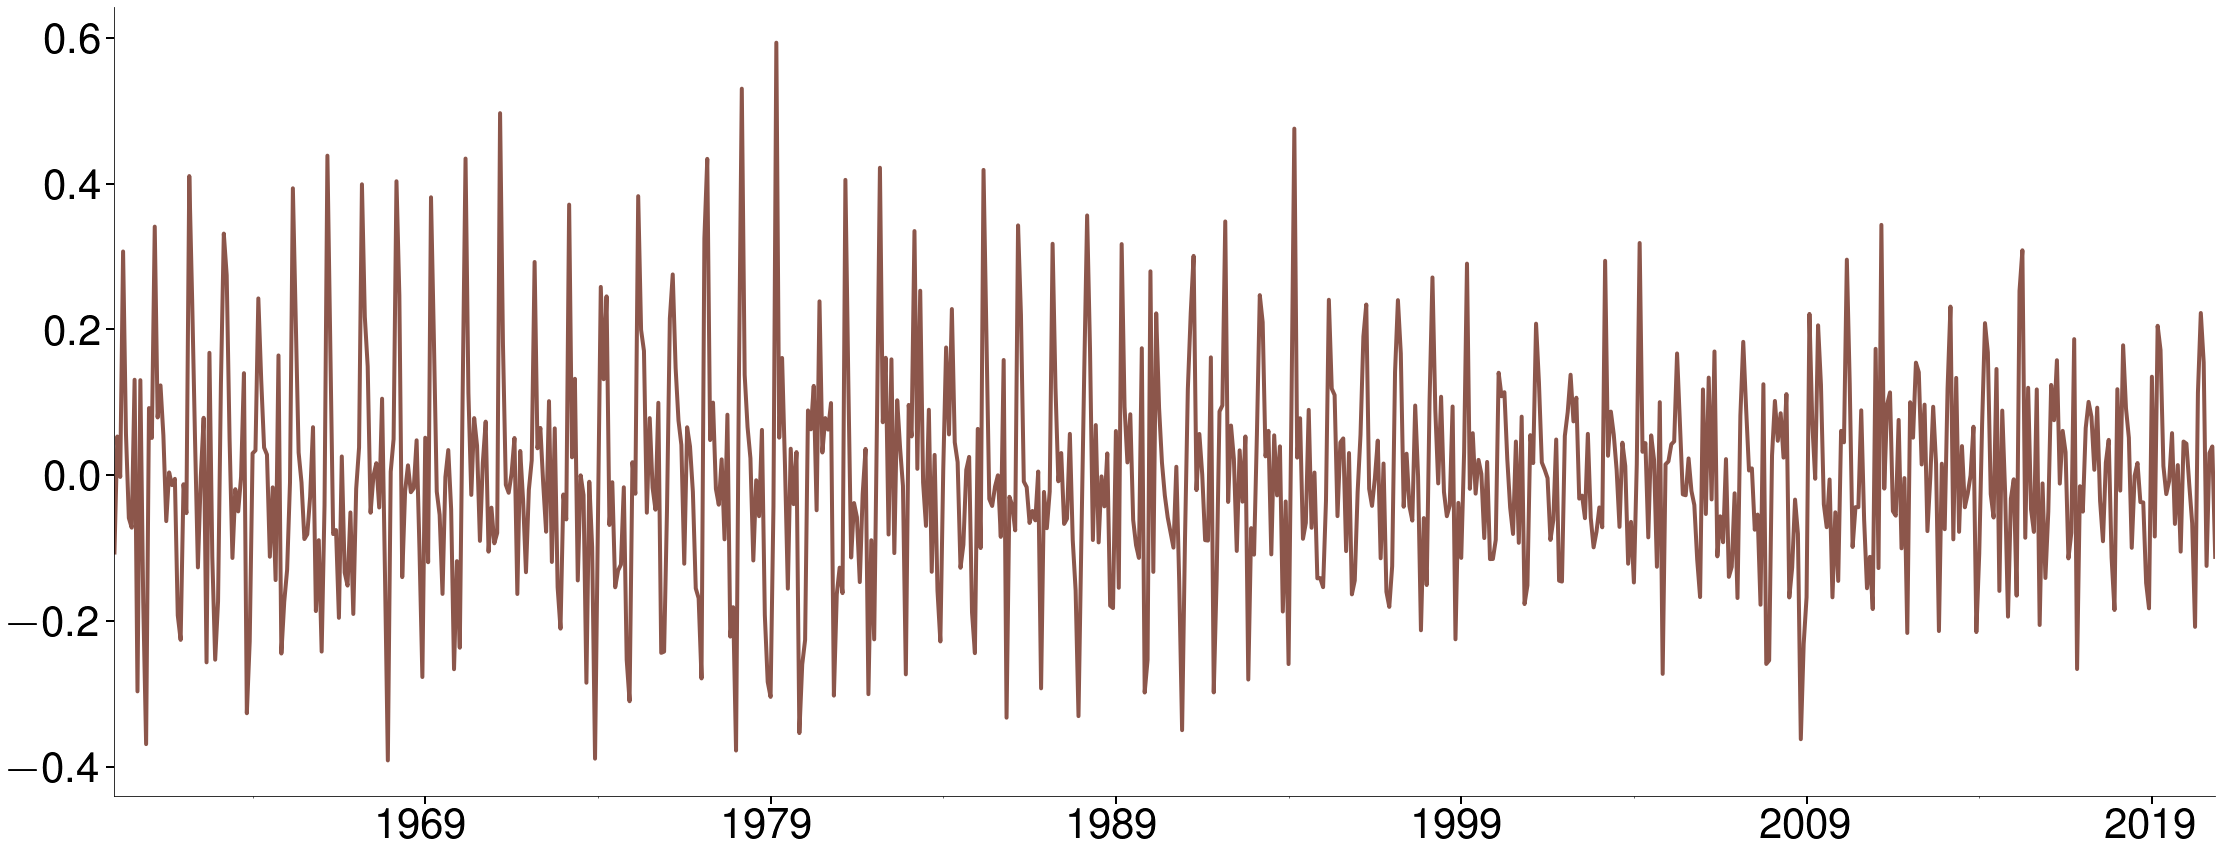

In [84]:
plot(housing, y=-2)

# Seasonal Autocorrelation Pattern

* Seasonal data has dynamics at the annual frequency

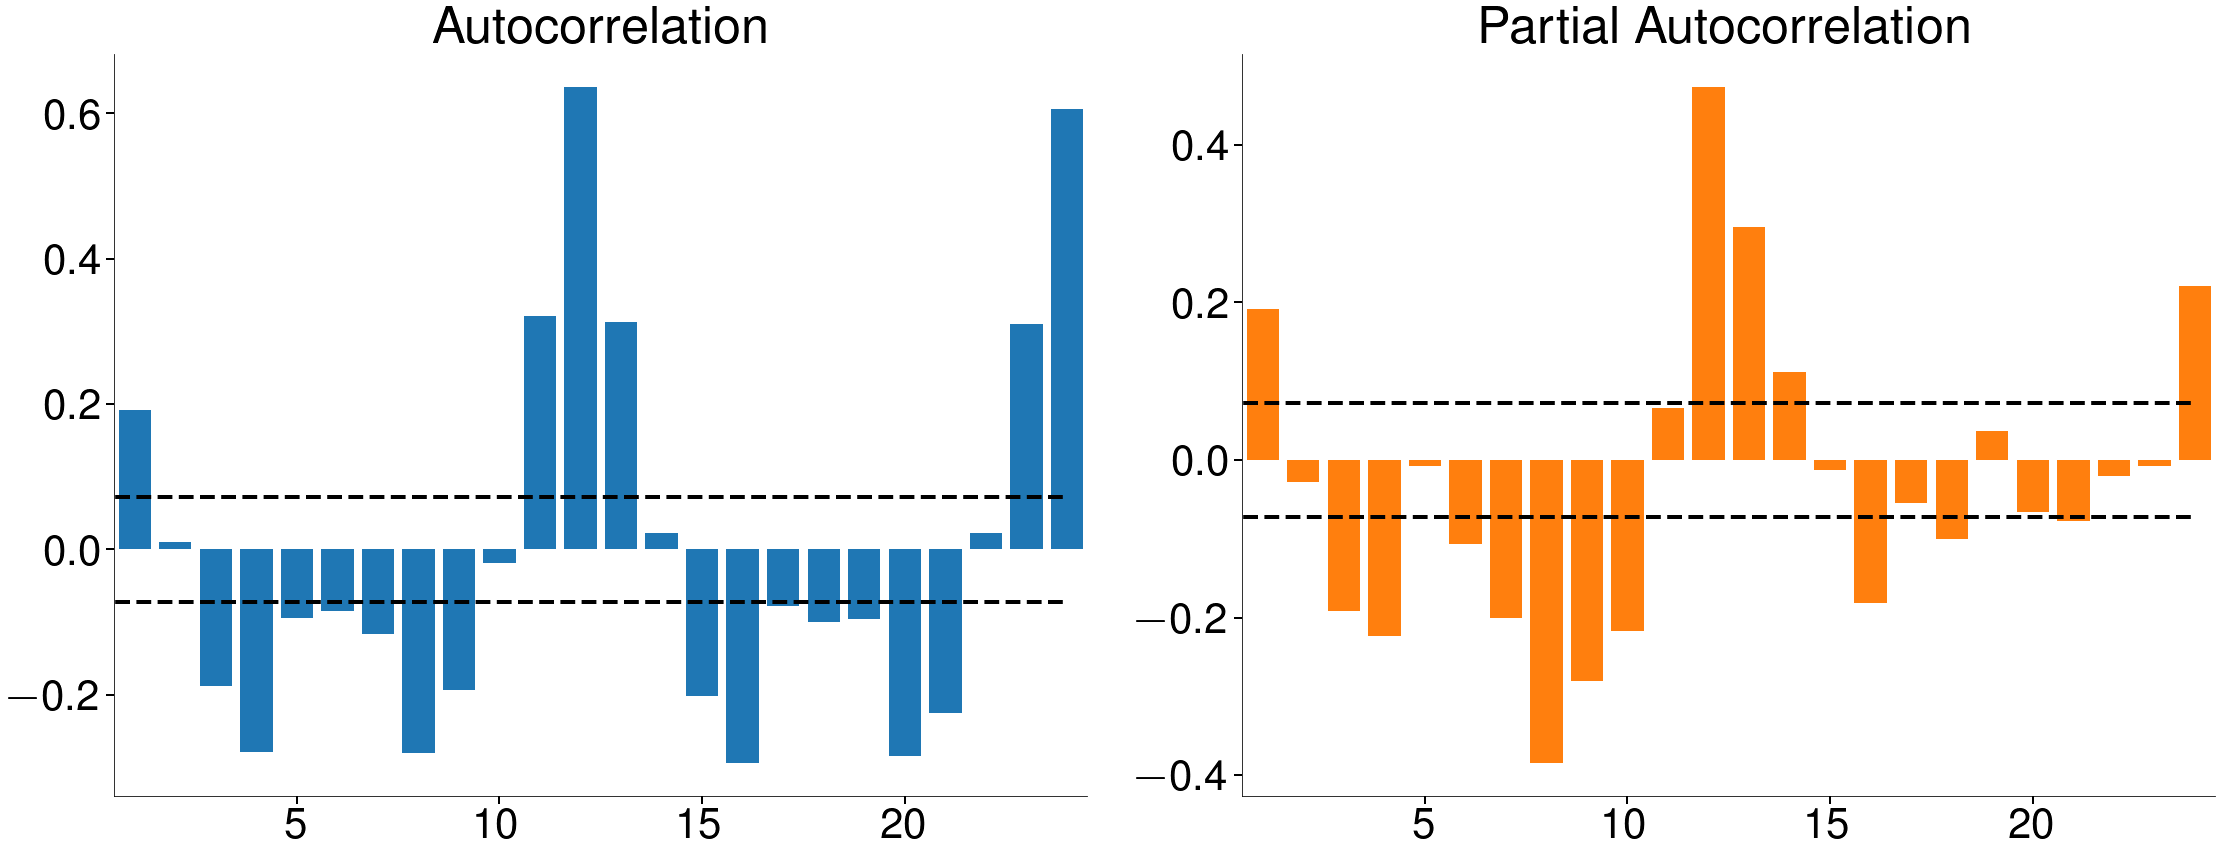

In [83]:
acf_pacf_plot(housing, 24, size=-2)

# Seasonal Differencing

* Seasonal differencing differences using the seasonal period $s$

$$ \Delta_{s} Y_t = Y_t - Y_{t-s} $$

* Can reduce or eliminate seasonalities

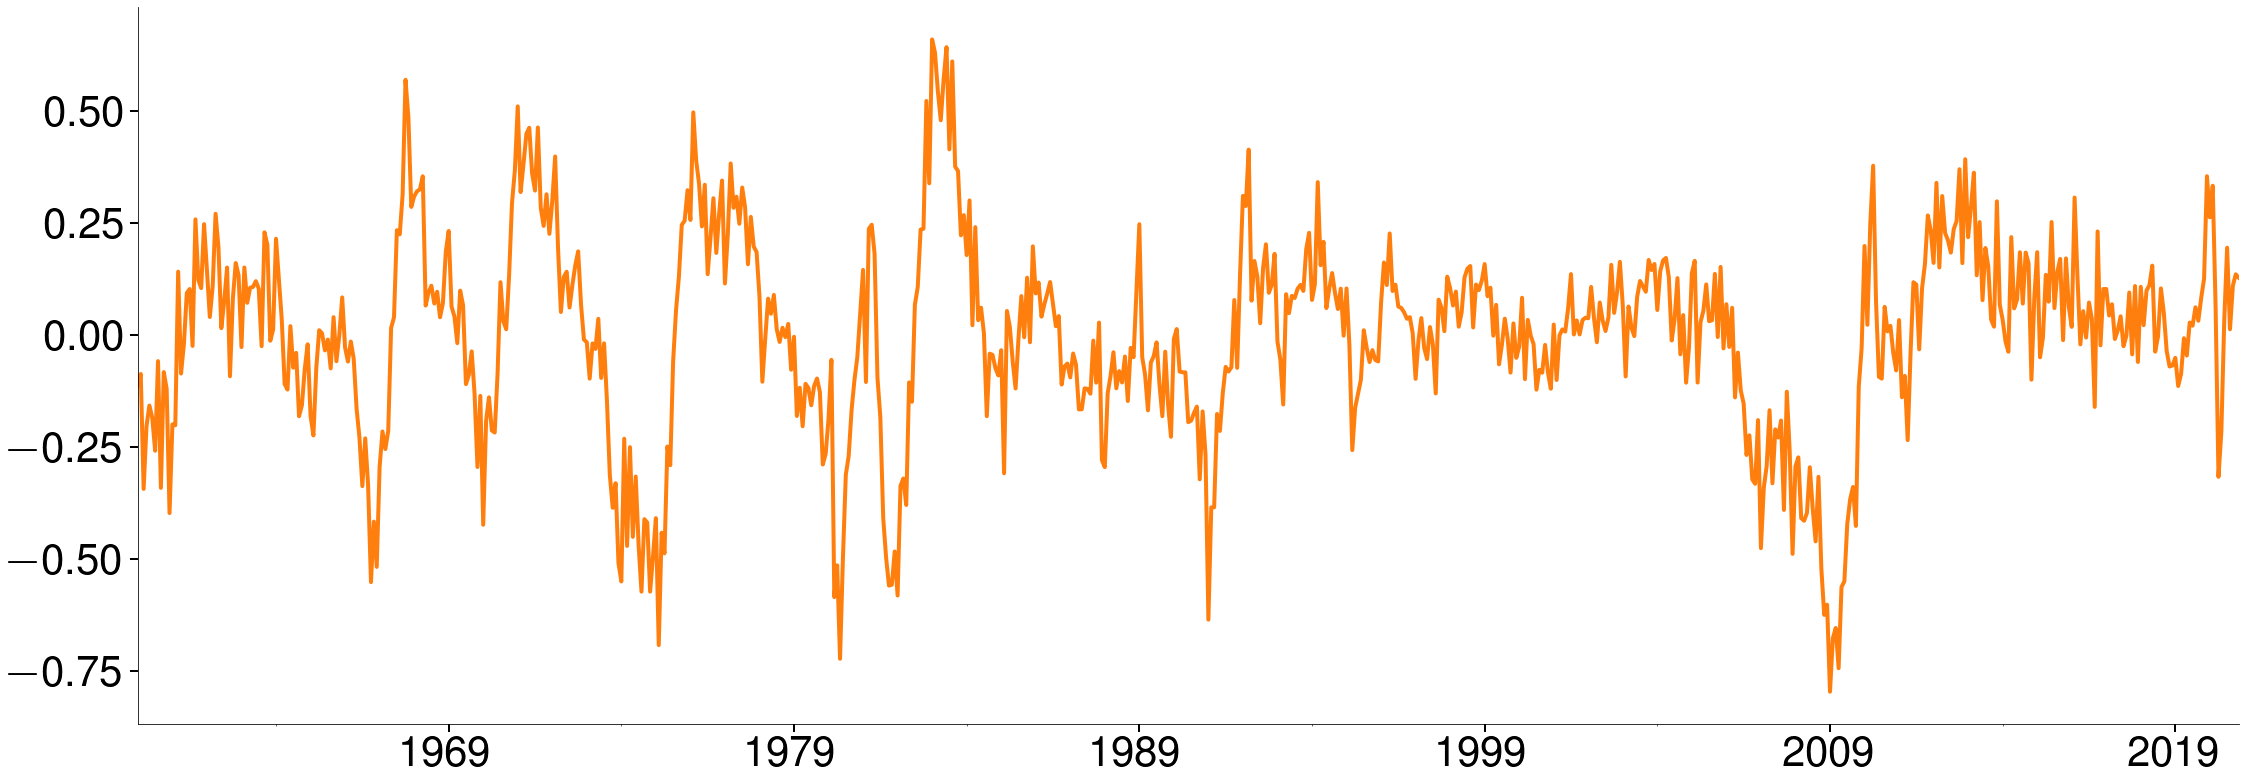

In [50]:
plot(housing_yoy, y=12)

# Seasonal Difference Autocorrelation Pattern

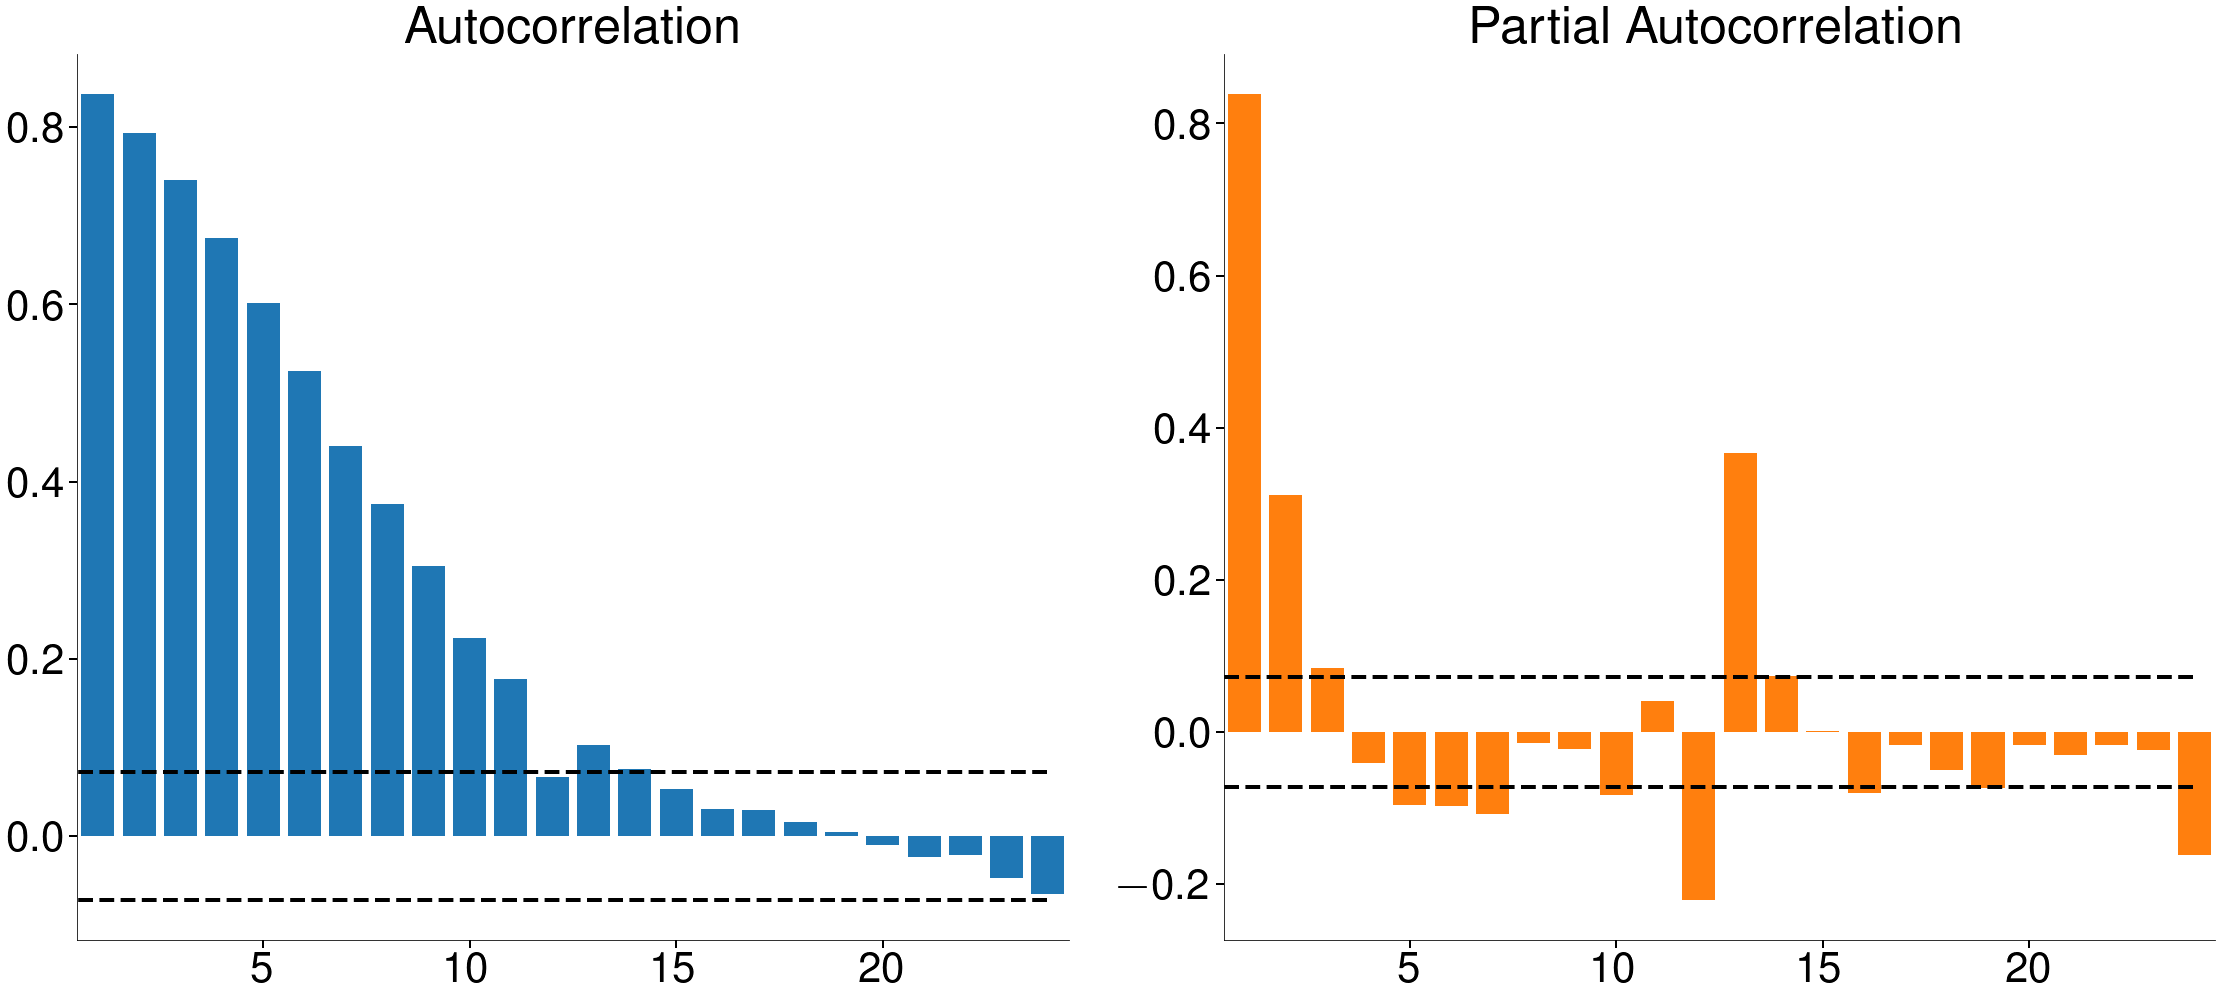

In [51]:
acf_pacf_plot(housing_yoy, 24)

# Modeling Seasonal Differences

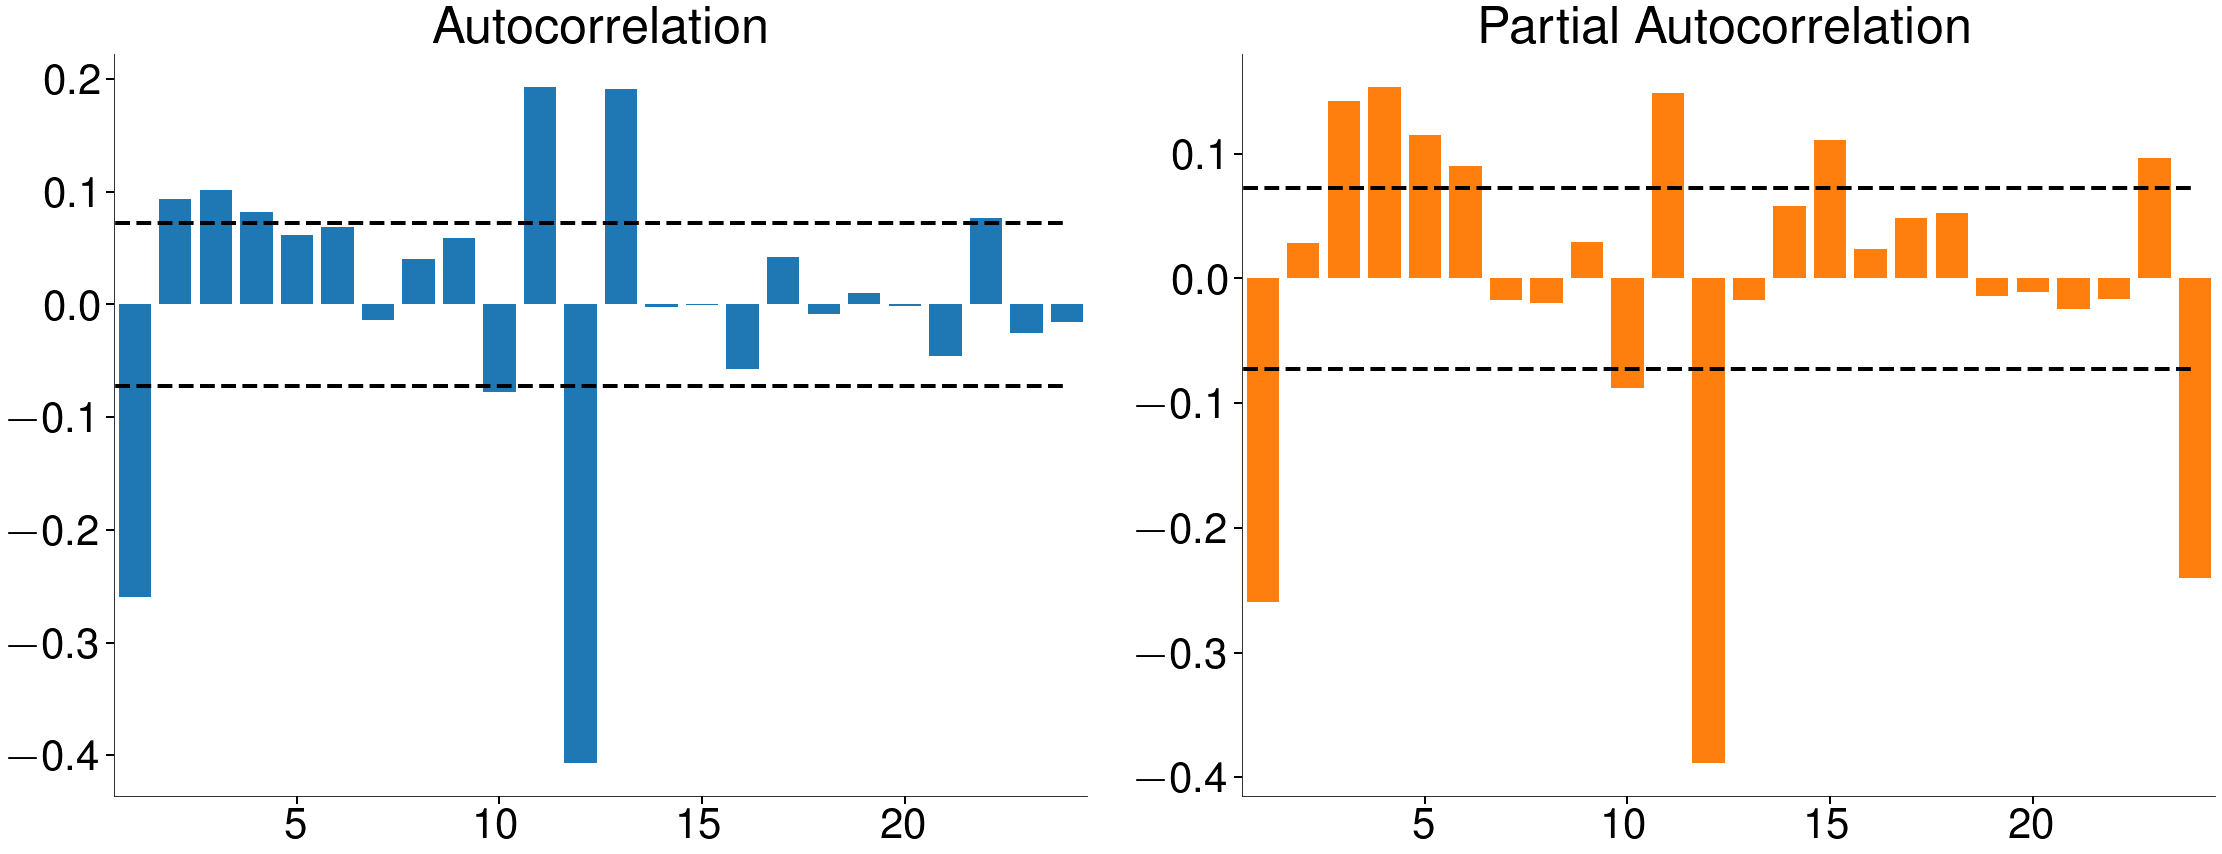

In [52]:
res = SARIMAX(housing_yoy, order=(1, 0, 0)).fit()
resids = res.resid.iloc[1:]
acf_pacf_plot(resids, 24, size=-2)

# Seasonal ARMA Models

* SARMA models data at both the observational and seasonal frequency
* In lag polynomial representation

$$ (1-\phi_1 L -\phi_2 L^2) Y_t = \phi_0 + (1+\theta_s L^s)\epsilon_t $$

* In standard ARMA representation

$$ Y_t = \phi_0 + \phi_1 Y_{t-1} +\phi_2 Y_{t-2} \theta_s \epsilon_{t-s}  + \epsilon_t $$

$$ SARMA$(P,0,Q)\times(P_s,0,Q_s,s) $$

In [53]:
res = SARIMAX(housing_yoy, order=(2, 0, 0), seasonal_order=(0, 0, 1, 12)).fit()
summary(res)

,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.6809,0.034,20.284,0.000,0.615,0.747
ar.L2,0.2824,0.034,8.233,0.000,0.215,0.350
ma.S.L12,-0.8795,0.017,-50.520,0.000,-0.914,-0.845
sigma2,0.0083,0.000,21.791,0.000,0.008,0.009


# SARMA Residual Diagnostics

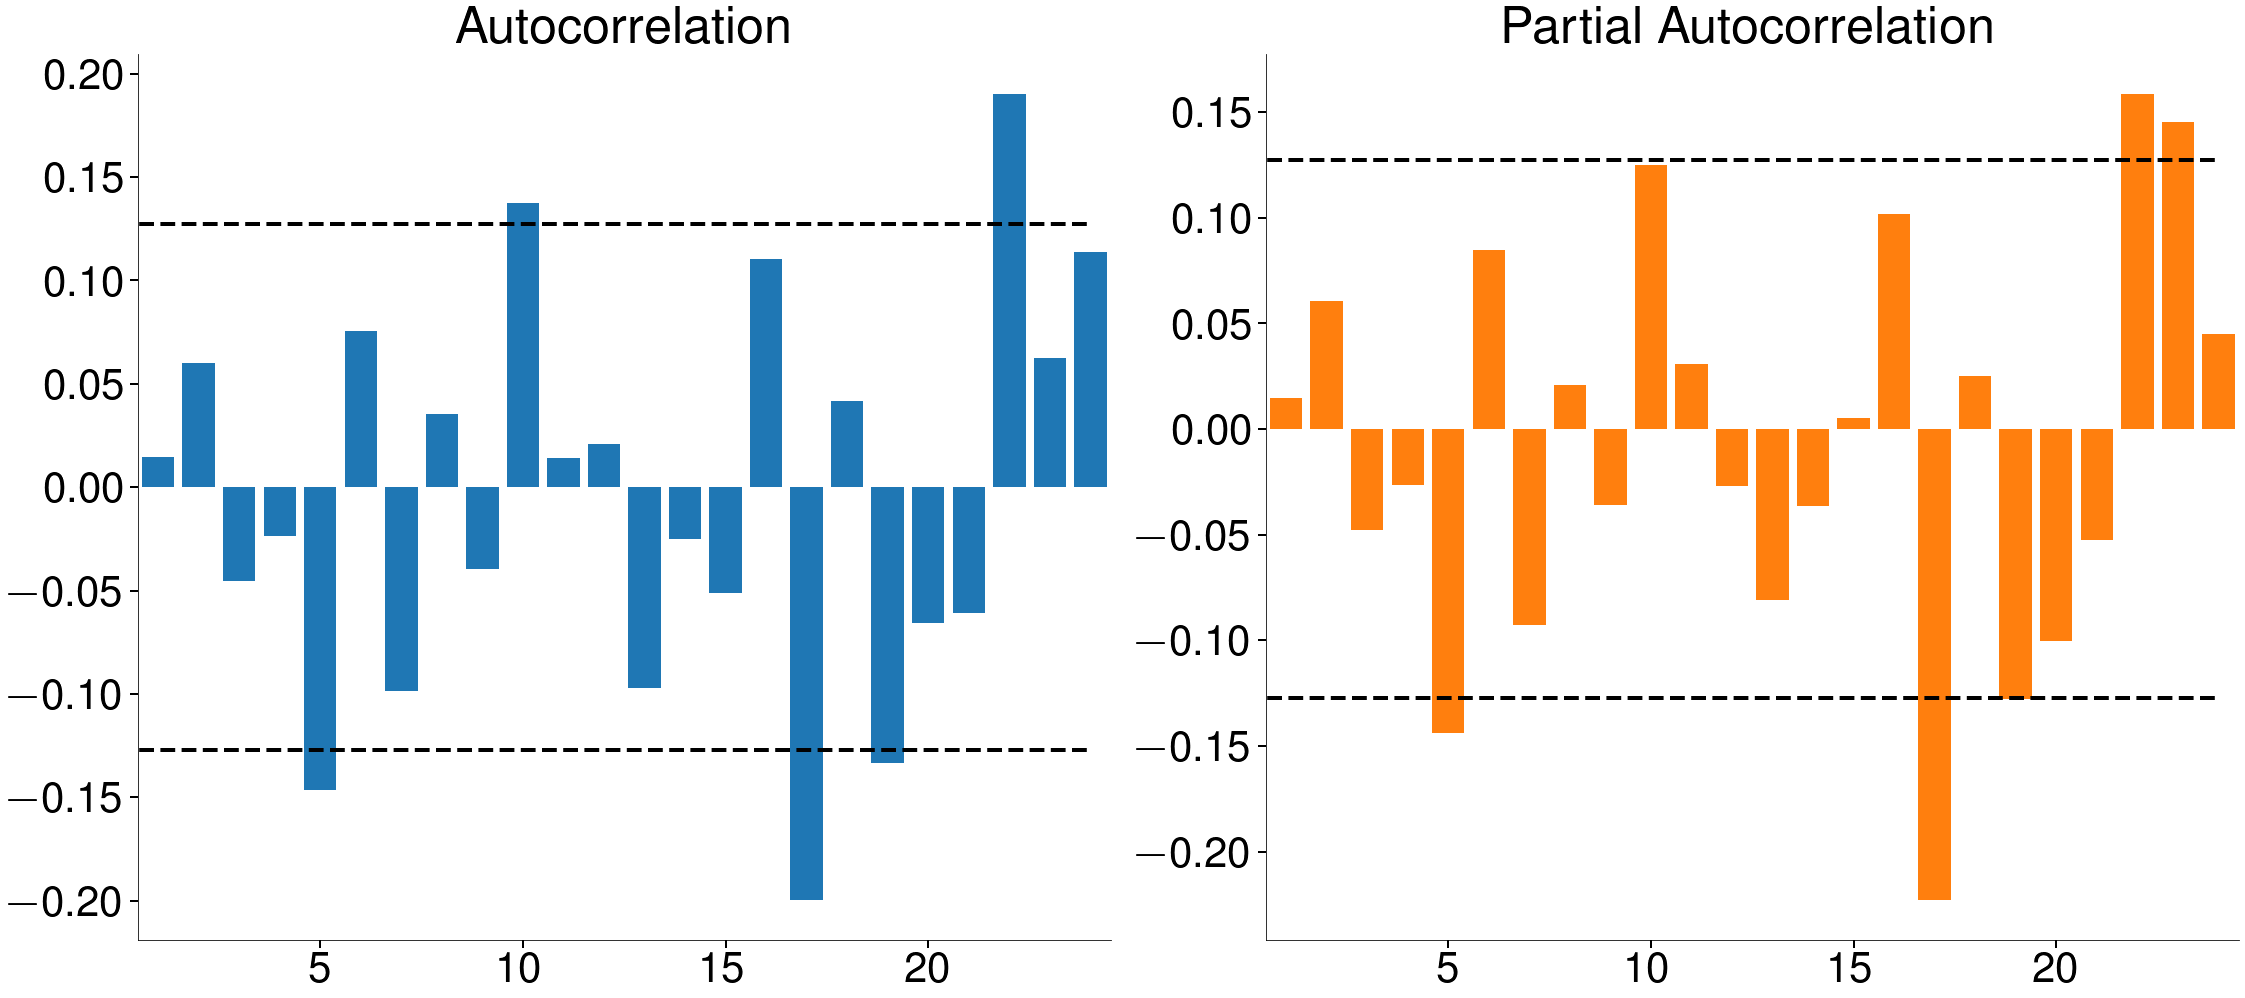

In [82]:
acf_pacf_plot(res.resid.iloc[13:], 24)

# Extended Dynamics $(1,0,1)\times(1,0,1)_{12}$

* In lag polynomial representation

$$ (1-\phi_1 L)(1-\phi_s L^s)Y_t = \phi_0 + (1+\theta_1 L)(1+\theta_s L^s)\epsilon_t $$

* In standard ARMA representation

$$ Y_t = \phi_0 + \phi_1 Y_{t-1} +\phi_s Y_{t-s} - \phi_1\phi_s Y_{t-s-1} + \theta_1 \epsilon_{t-1} +\theta_s \epsilon_{t-s} + \theta_1\theta_s \epsilon_{t-s-1} + \epsilon_t $$

In [55]:
res = SARIMAX(housing_raw, order=(1, 0, 1), seasonal_order=(1, 0, 1, 12)).fit()
summary(res)

,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.9994,0.001,1449.669,0.000,0.998,1.001
ma.L1,-0.3196,0.031,-10.258,0.000,-0.381,-0.259
ar.S.L12,0.9987,0.001,1455.660,0.000,0.997,1.000
ma.S.L12,-0.8956,0.016,-54.434,0.000,-0.928,-0.863
sigma2,0.0083,0.000,22.227,0.000,0.008,0.009


# Extended Model Residual Diagnostics

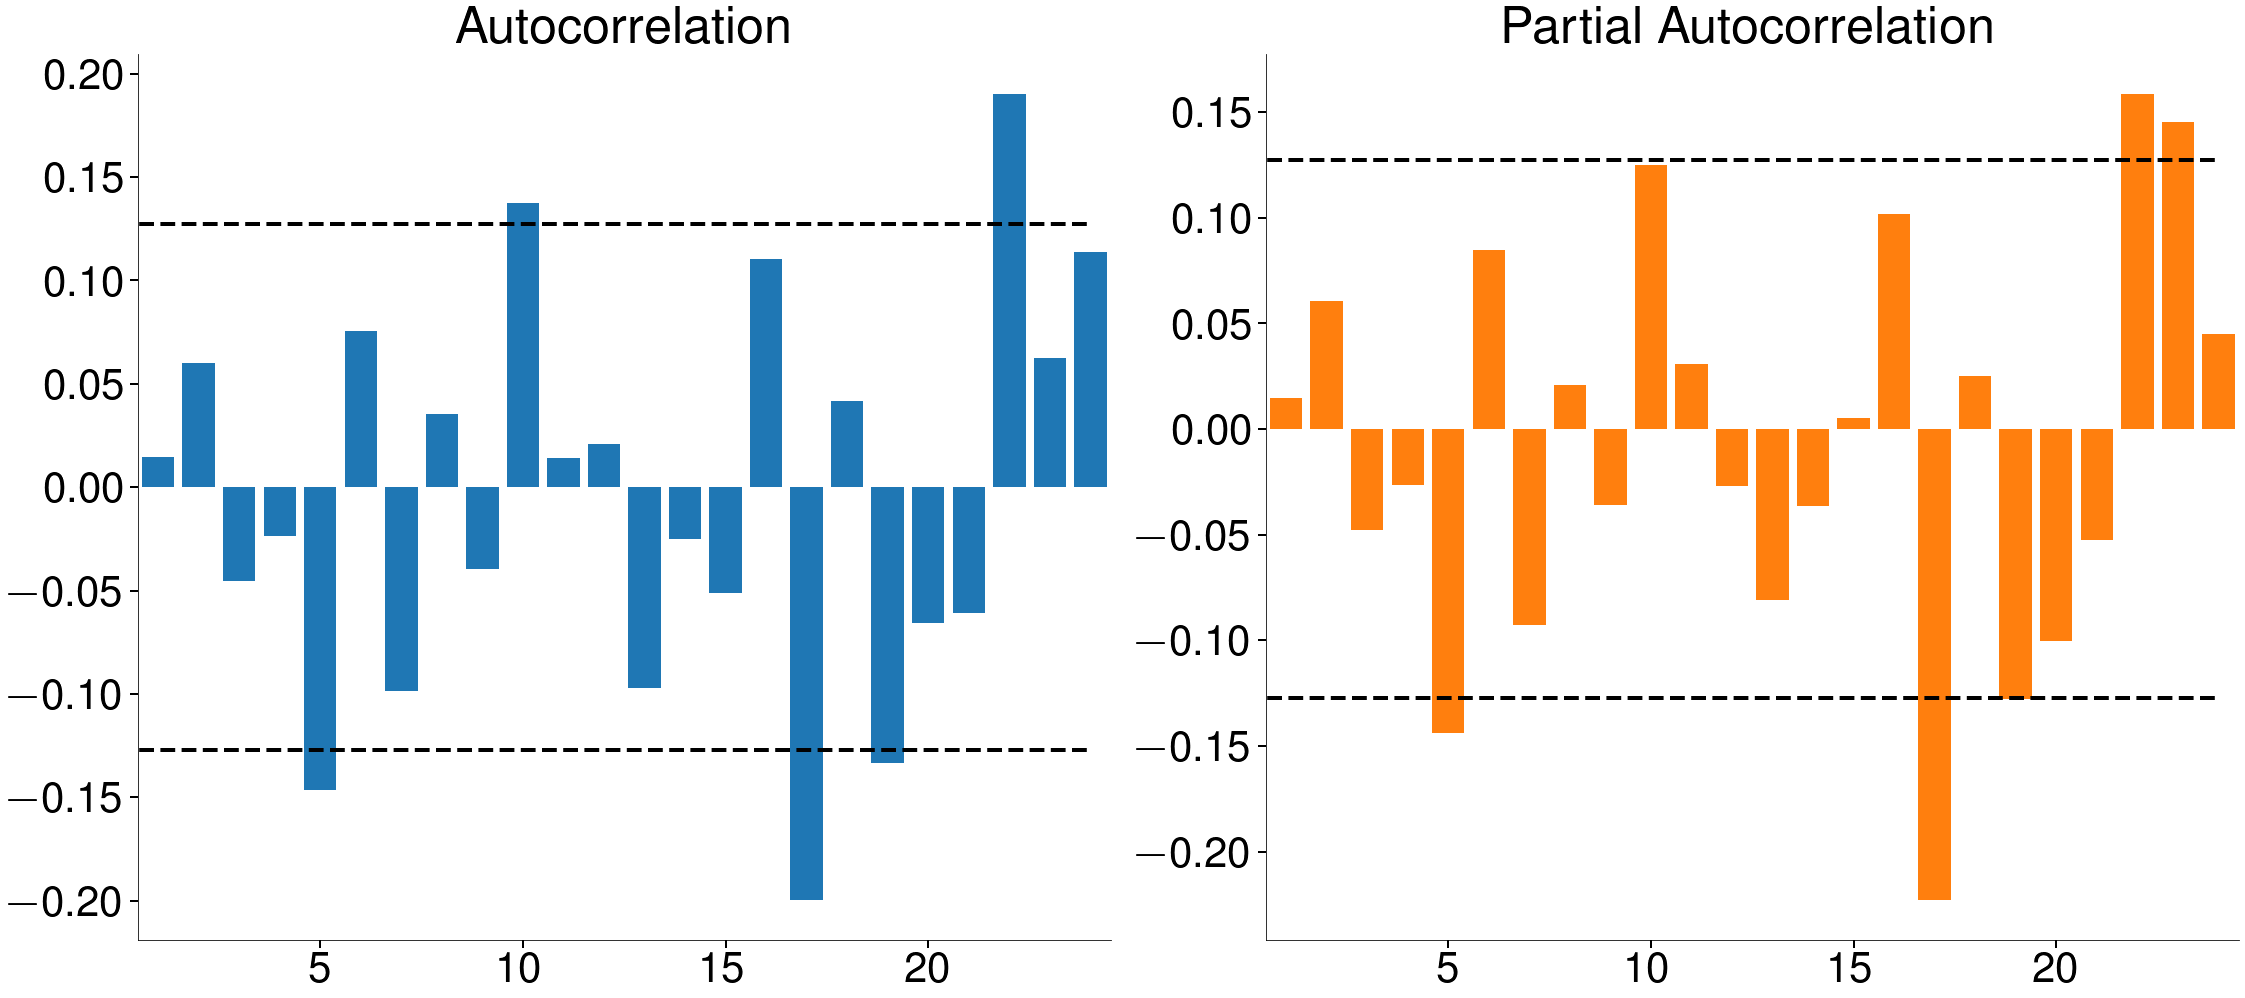

In [81]:
acf_pacf_plot(res.resid.iloc[13:], 24)

# Incorporating differencing

* SARIMA - Seasonal Autoregressive Integrated Moving Average

$$ \text{SARIMA} (P,D,Q)\times(P_s,D_s,Q_s,s)$$

$$ \Phi(L)\Phi_s(L)(1-L)^D(1-L^s)^{D_s} Y_t = \phi_0 + \Theta(L)\Theta_s(L)\epsilon_t $$

* **AR**
$$\Phi(L) = $1-\phi_1 L - \phi_2 L^2 - \ldots -\phi_P L^P$$
* **Seasonal AR**: $$\Phi_s(L) = 1-\phi_s L^s - \phi_{2s} L^{2s} - \ldots -\phi_{P_s s} L^{P_s s}$$
* **MA**: $$\Theta(L) = 1+\theta_1 L + \theta_2 L^2 + \ldots +\phi_Q L^Q$$
* **Seasonal MA**: $$\Theta_s(L) = 1+\theta_s L^s + \theta_{2s} L^{2s} + \ldots +\theta_{Q_s s} L^{Q_s s}$$

# Estimating SARIMA Models

In [57]:
res = SARIMAX(housing_raw, order=(1, 0, 1), seasonal_order=(0, 1, 1, 12)).fit()
summary(res)

,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.9778,0.008,126.962,0.000,0.963,0.993
ma.L1,-0.3128,0.033,-9.354,0.000,-0.378,-0.247
ma.S.L12,-0.8774,0.018,-48.040,0.000,-0.913,-0.842
sigma2,0.0083,0.000,21.771,0.000,0.008,0.009


# SARIMA$(1,0,1)\times(0,1,1)_{12}$ Residual Analysis

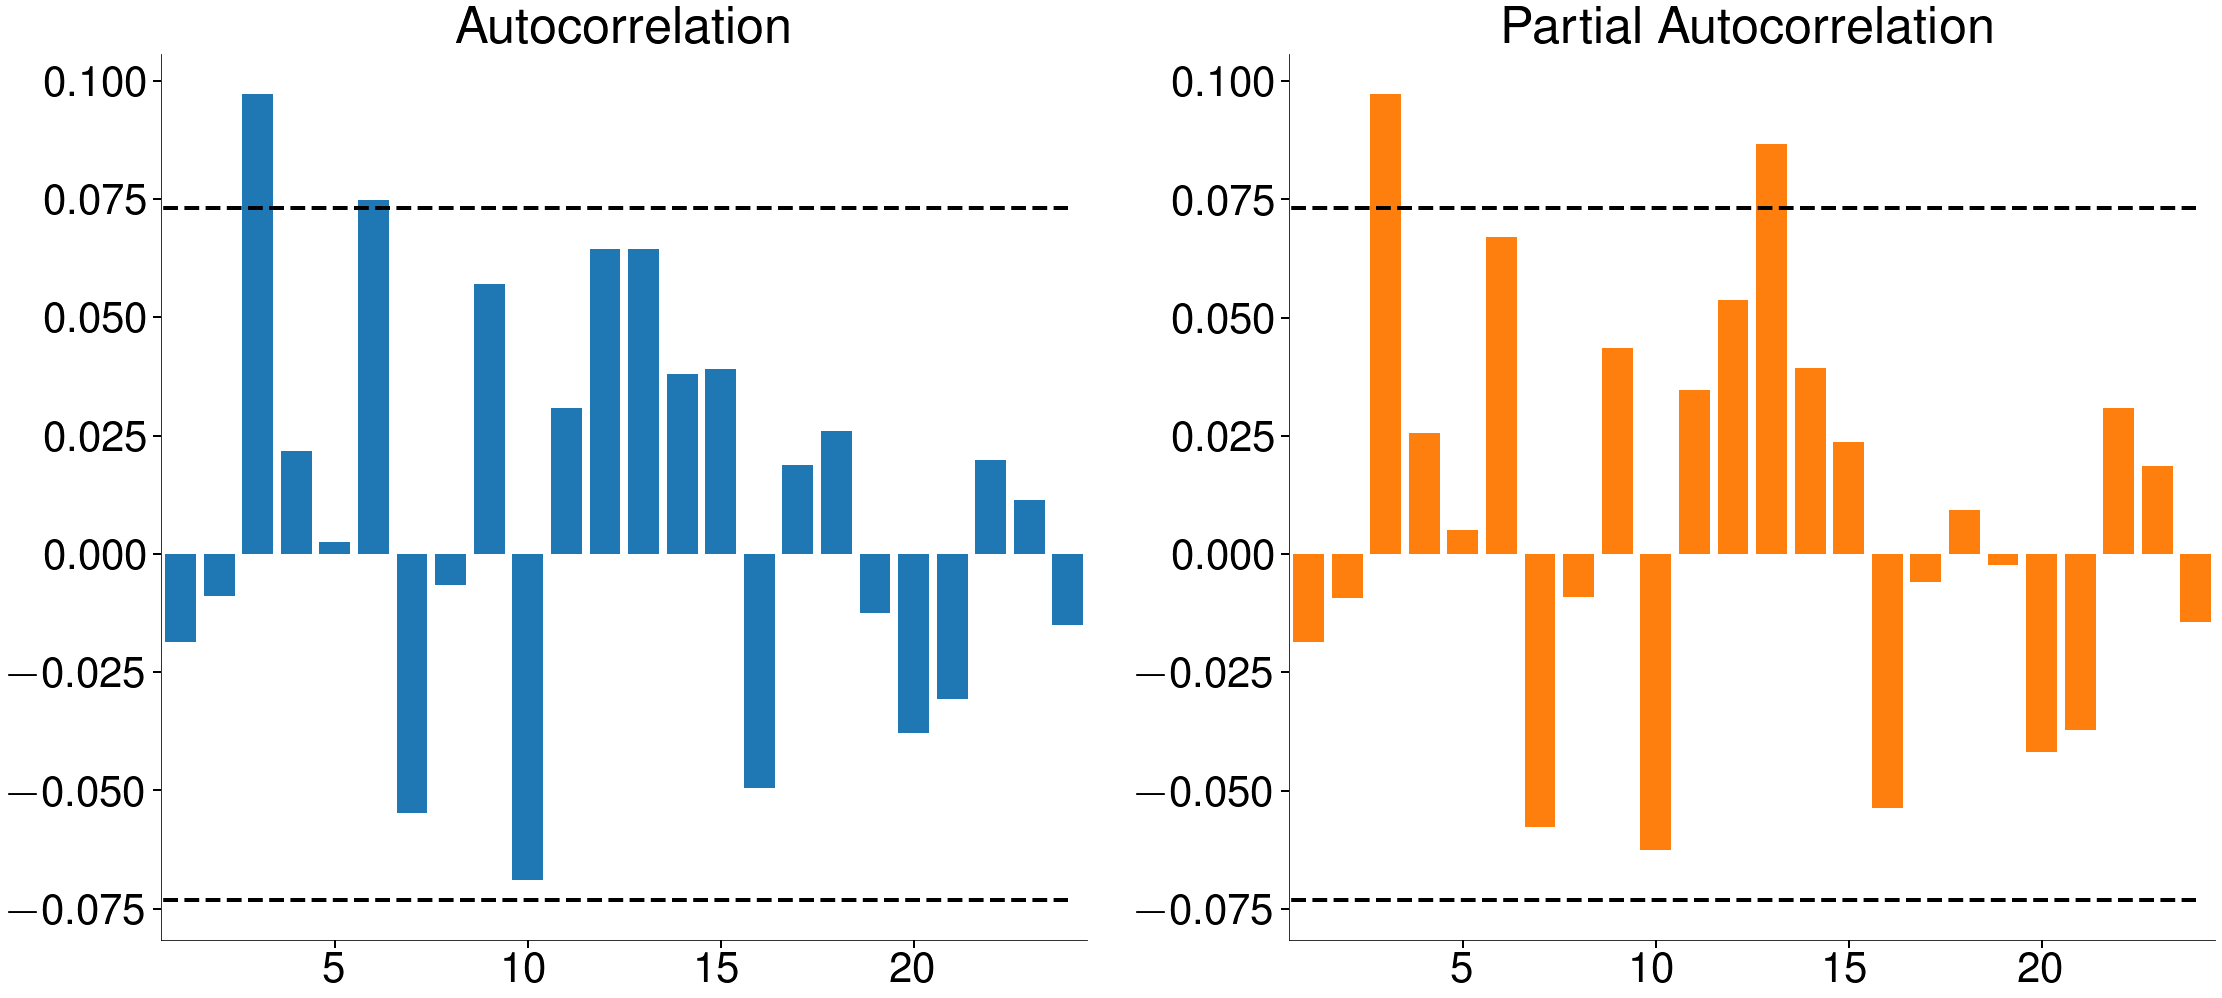

In [58]:
acf_pacf_plot(res.resid.iloc[13:], 24)

# Enforcing Unit Roots

* Set both differences to 1
  * $D=1$
  * $D_s=1$

* Model is

$$ (1-L)(1-L^s)Y_t = \theta_s \epsilon_{t-s} + \epsilon_t $$
$$ \Delta\Delta_s Y_t = \theta_s \epsilon_{t-s} + \epsilon_t $$

In [59]:
res = SARIMAX(housing_raw, order=(0, 1, 1), seasonal_order=(0, 1, 1, 12)).fit()
summary(res)

,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-0.3246,0.031,-10.361,0.000,-0.386,-0.263
ma.S.L12,-0.8774,0.019,-47.049,0.000,-0.914,-0.841
sigma2,0.0084,0.000,22.025,0.000,0.008,0.009


# Double Difference Residual Diagnostics

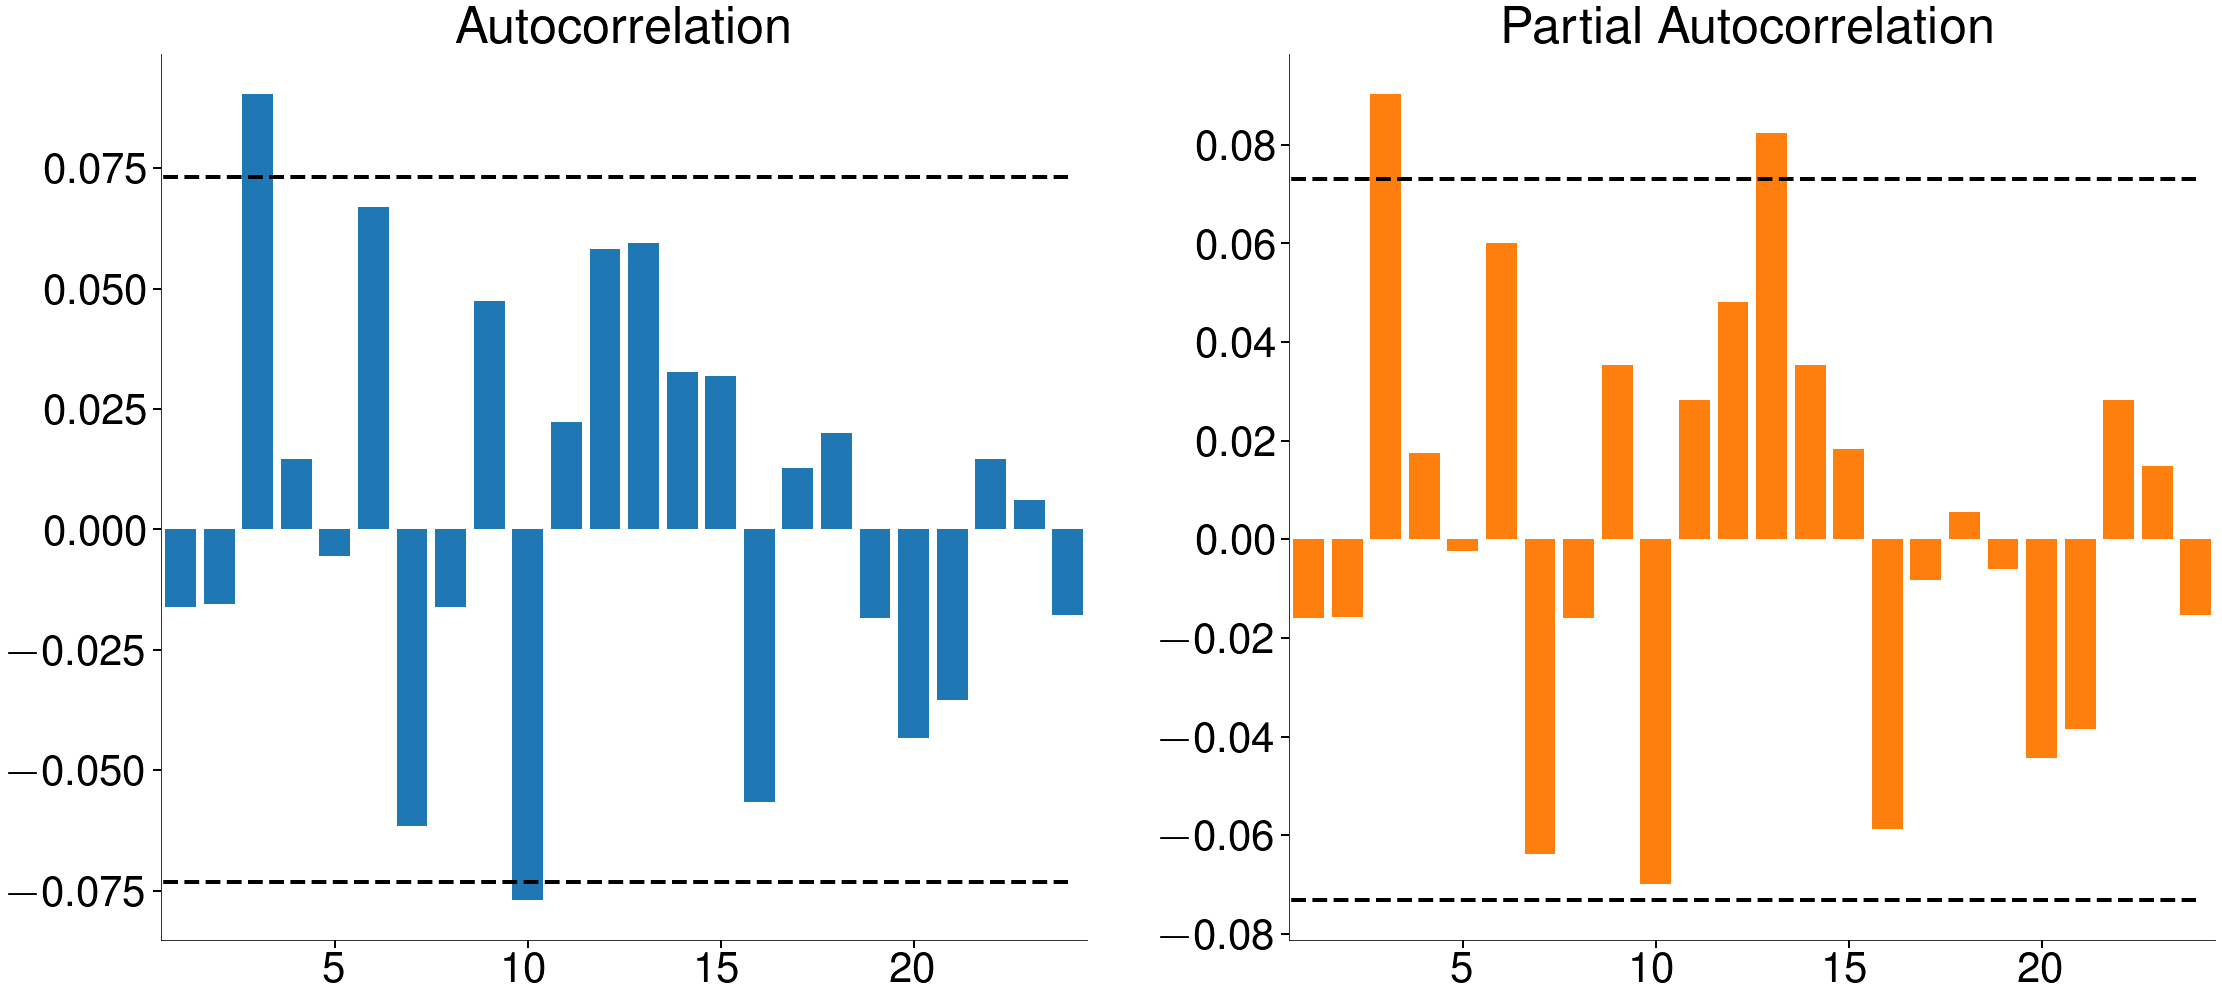

In [60]:
acf_pacf_plot(res.resid.iloc[13:], 24)

# Seasonal Dummies

* Alternative approach to SARIMA
* Model shifts as a deterministic processes
* One dummy for each of $s-1$ periods
  * Avoid dummy variable trap

In [61]:
month = housing_raw.index.strftime("%b")
dummies = pd.get_dummies(month)
dummies = dummies[
    ["Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
]
dummies.index = housing_raw.index
dummies.head()

,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
1960-01-01,0,0,0,0,0,0,0,0,0,0,0
1960-02-01,1,0,0,0,0,0,0,0,0,0,0
1960-03-01,0,1,0,0,0,0,0,0,0,0,0
1960-04-01,0,0,1,0,0,0,0,0,0,0,0
1960-05-01,0,0,0,1,0,0,0,0,0,0,0


# Incorporating Dummies

In [62]:
res = SARIMAX(housing_raw, order=(2, 1, 0), exog=dummies, trend="c").fit()
summary(res)

,coef,std err,z,P>|z|,[0.025,0.975]
intercept,0.0002,0.004,0.046,0.963,-0.007,0.008
Feb,0.0358,0.012,2.965,0.003,0.012,0.059
Mar,0.3075,0.012,24.776,0.000,0.283,0.332
Apr,0.4289,0.015,29.517,0.000,0.400,0.457
May,0.4669,0.018,26.261,0.000,0.432,0.502
Jun,0.4697,0.019,25.309,0.000,0.433,0.506
Jul,0.4328,0.019,23.266,0.000,0.396,0.469
Aug,0.4117,0.019,22.228,0.000,0.375,0.448
Sep,0.3657,0.017,21.803,0.000,0.333,0.399
Oct,0.3921,0.015,26.254,0.000,0.363,0.421


# Seasonal Dummy Model Residuals

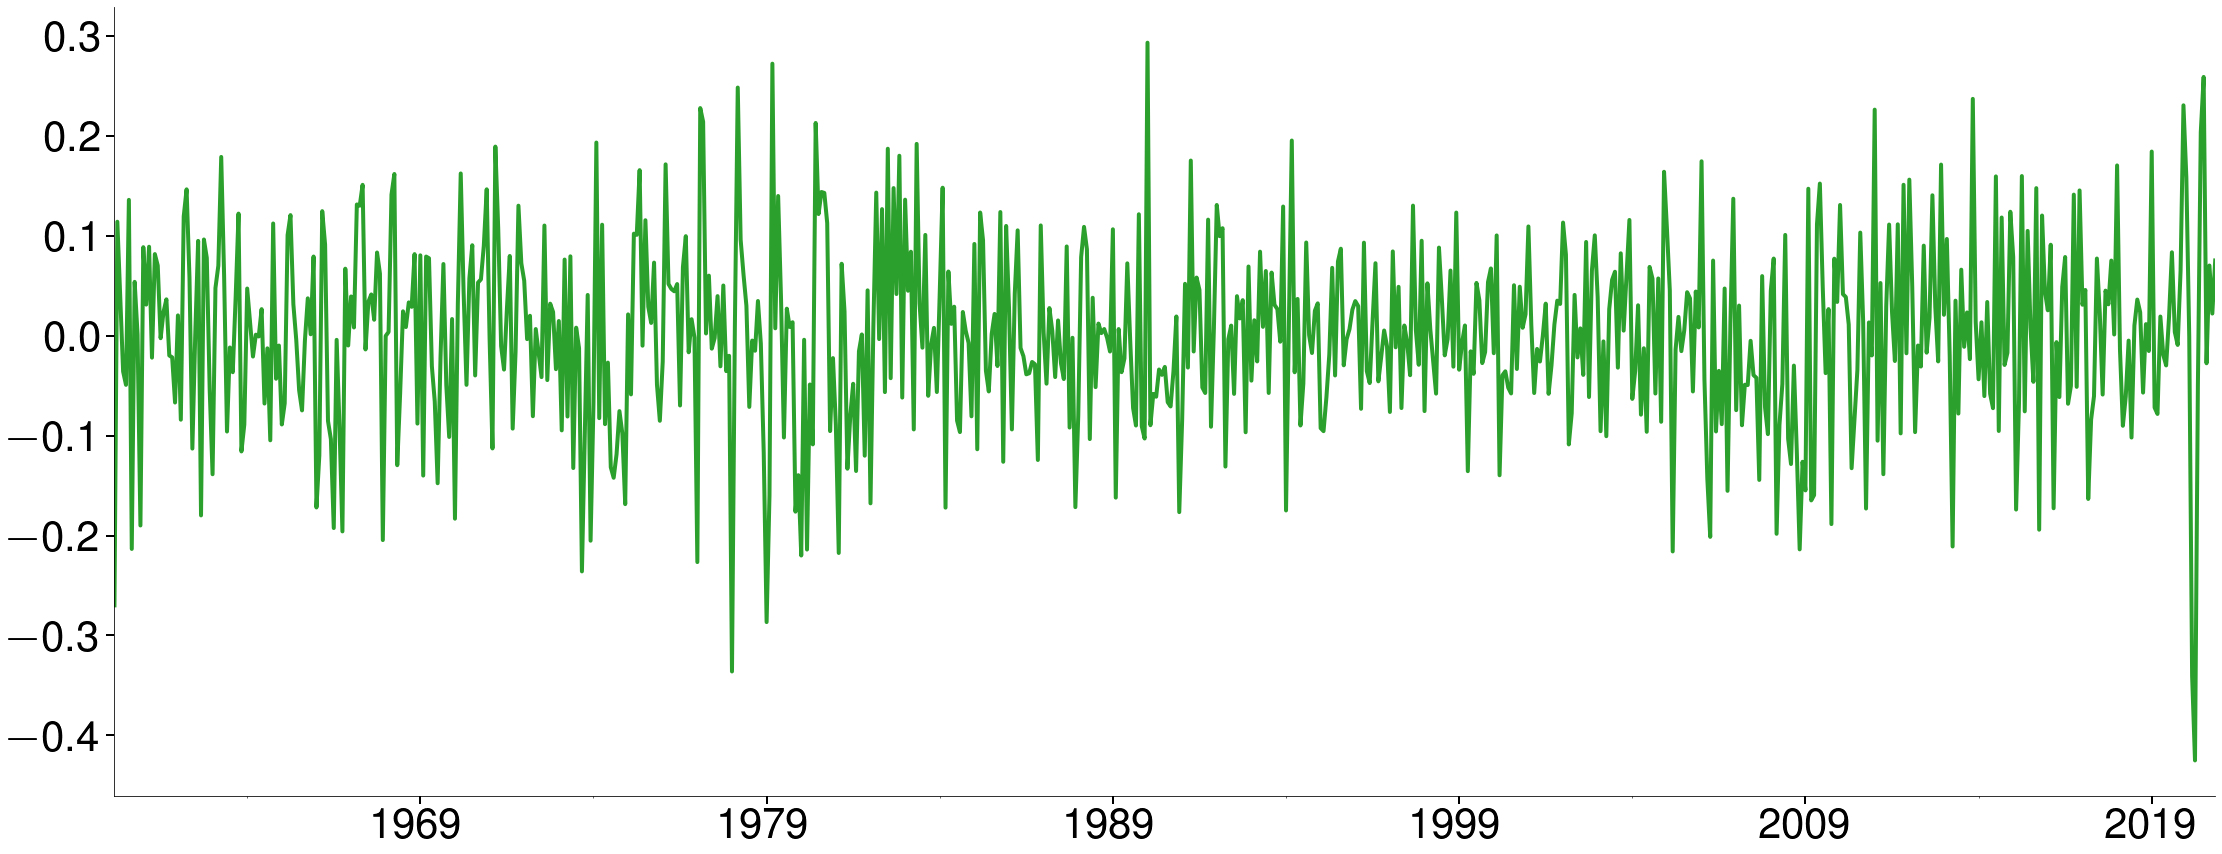

In [63]:
resid = res.resid.iloc[2:]
plot(resid, y=-2)

# Seasonal Dummy Model Residuals Diagnostics

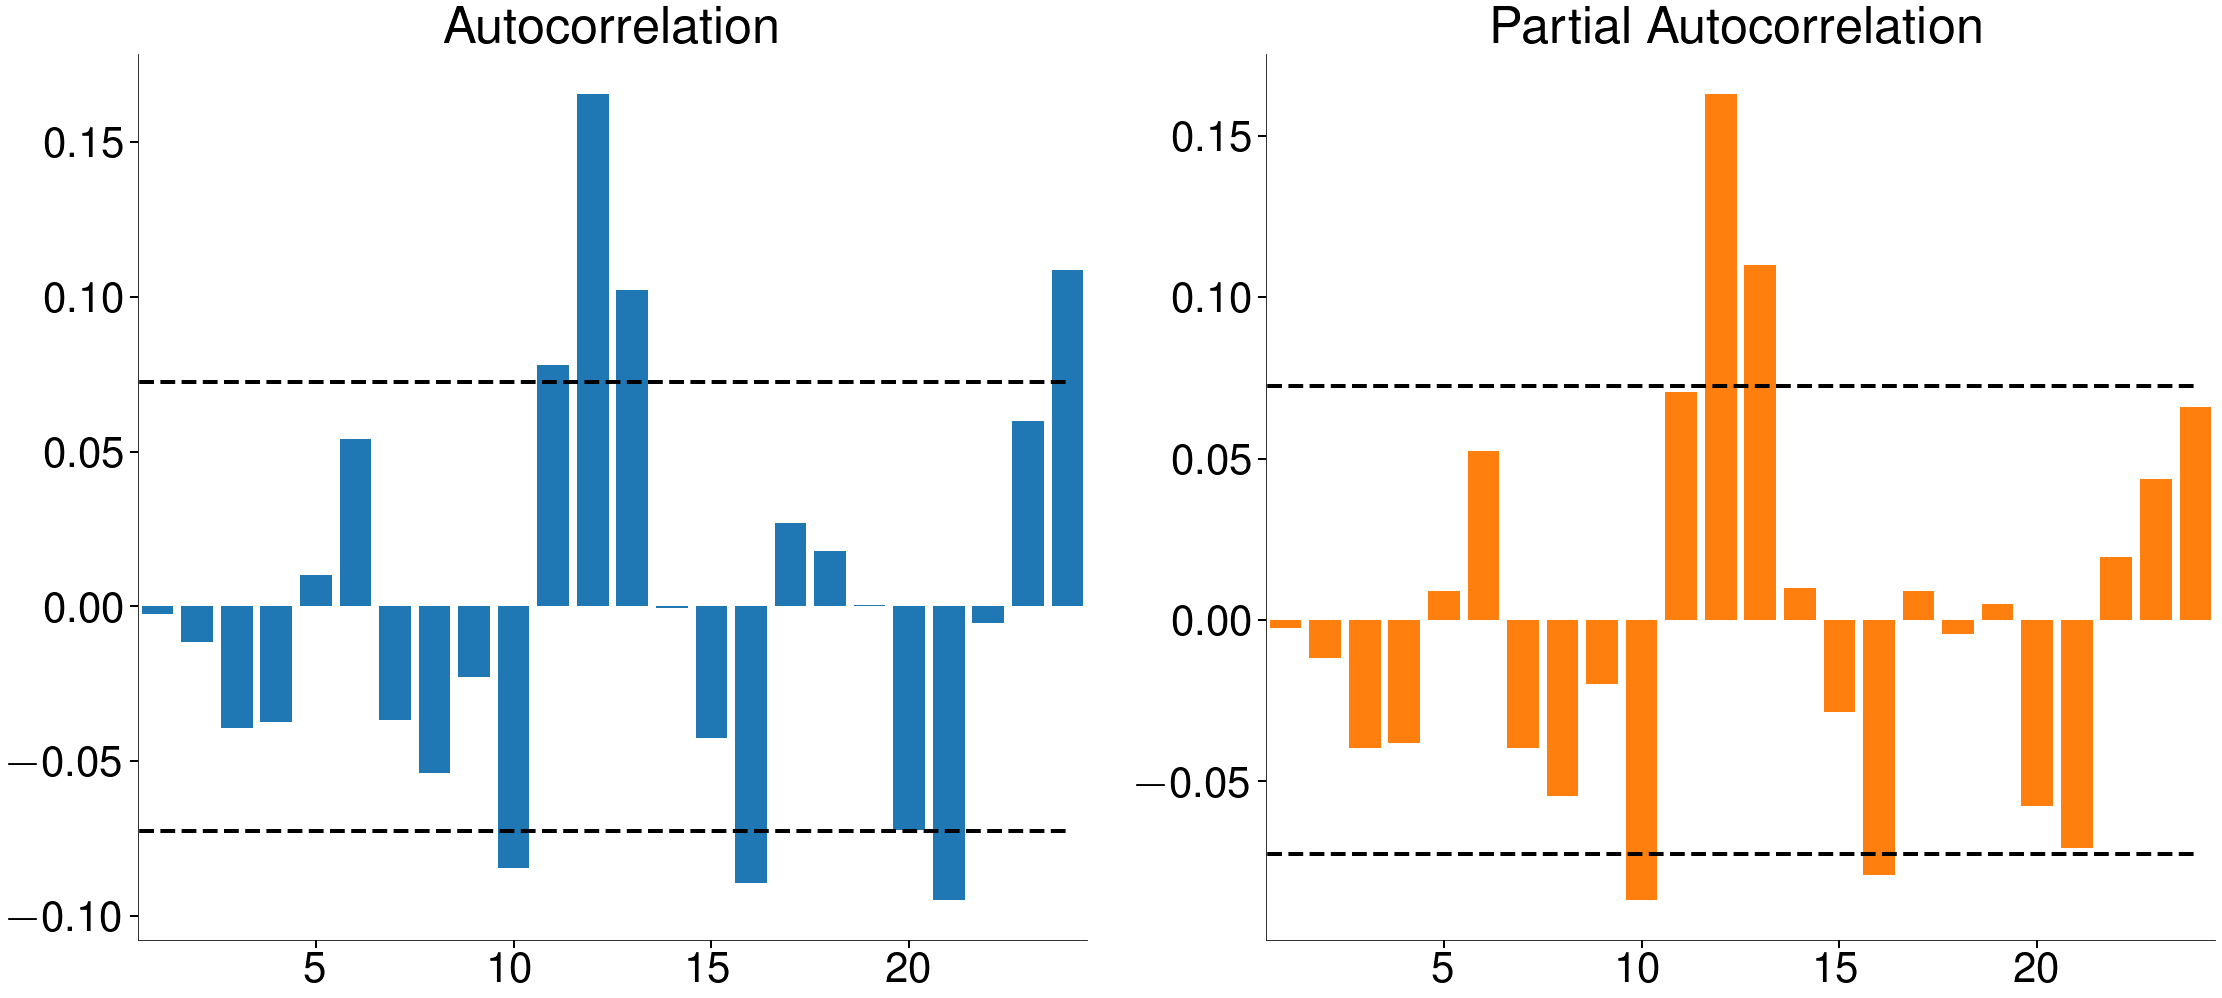

In [64]:
acf_pacf_plot(resid, 24)

# Unit Root Testing

* Test $Y_t$ for a unit root
* If null is not rejected, ensure that all required deterministic terms are included
* If null is still _not_ rejected, difference and test $\Delta Y_t$
* Positive $Y_t$ series should usually be transformed with $\ln$
* Select lag length of $\Delta Y_{t-j}$ terms using IC, usually AIC
* $H_0:\gamma=0$, $H_1:\gamma<0$

$$ Y_t = \delta_0 + \delta_1 t + \gamma Y_{t-1} + \sum_{i=1}^P \Delta Y_{t-i} + \epsilon_t $$

* Deterministic terms are needed to remove deterministic components from $Y_{t-1}$

In [65]:
from statsmodels.api import OLS
from statsmodels.nonparametric.kde import KDEUnivariate

rg = np.random.default_rng(20200101)


def adf_cv_plot():
    m = 2500
    y = np.cumsum(rg.standard_normal((300, m)), 0)[50:]
    y.shape
    adf_stats = np.empty((m, 3))
    for i in range(m):
        d = np.diff(y[:, i])
        x = y[:-1, i : i + 1]
        adf_stats[i, 0] = OLS(d, x).fit().tvalues[0]
        _x = np.column_stack([x, np.ones_like(x)])
        adf_stats[i, 1] = OLS(d, _x).fit().tvalues[0]
        _x = np.column_stack([_x, np.arange(x.shape[0])])
        adf_stats[i, 2] = OLS(d, _x).fit().tvalues[0]

    fig, ax = plt.subplots(1, 1)
    labels = ["No Deterministic", "Constant", "Constant and Trend"]
    x = []
    bnds = np.zeros(2)
    for i in range(3):
        kde = KDEUnivariate(adf_stats[:, i]).fit()
        bw = kde.bw
        kde = KDEUnivariate(adf_stats[:, i]).fit(bw=1.75 * bw)
        ax.plot(kde.support, kde.density, label=labels[i])
        bnds[0] = min(bnds[0], kde.support.min())
        bnds[1] = max(bnds[1], kde.support.max())
        right = np.where(kde.cdf < 0.05)[0][-1]
        ax.fill_between(
            kde.support[:right], np.zeros(right), kde.density[:right], alpha=0.33
        )
        x.append(kde.support)
    x = np.sort(np.hstack(x))
    pdf = stats.norm().pdf(x)
    ax.plot(x, pdf, label="Standard Normal")
    right = np.where(stats.norm().cdf(x) < 0.05)[0][-1]
    ax.fill_between(x[:right], np.zeros(right), pdf[:right], alpha=0.33)
    yl = ax.get_ylim()
    ax.set_ylim(0, yl[1])
    ax.set_xlim(bnds)
    fig.legend(frameon=False)
    sns.despine()
    fig.tight_layout(pad=1.0)

# The Dickey-Fuller distributions

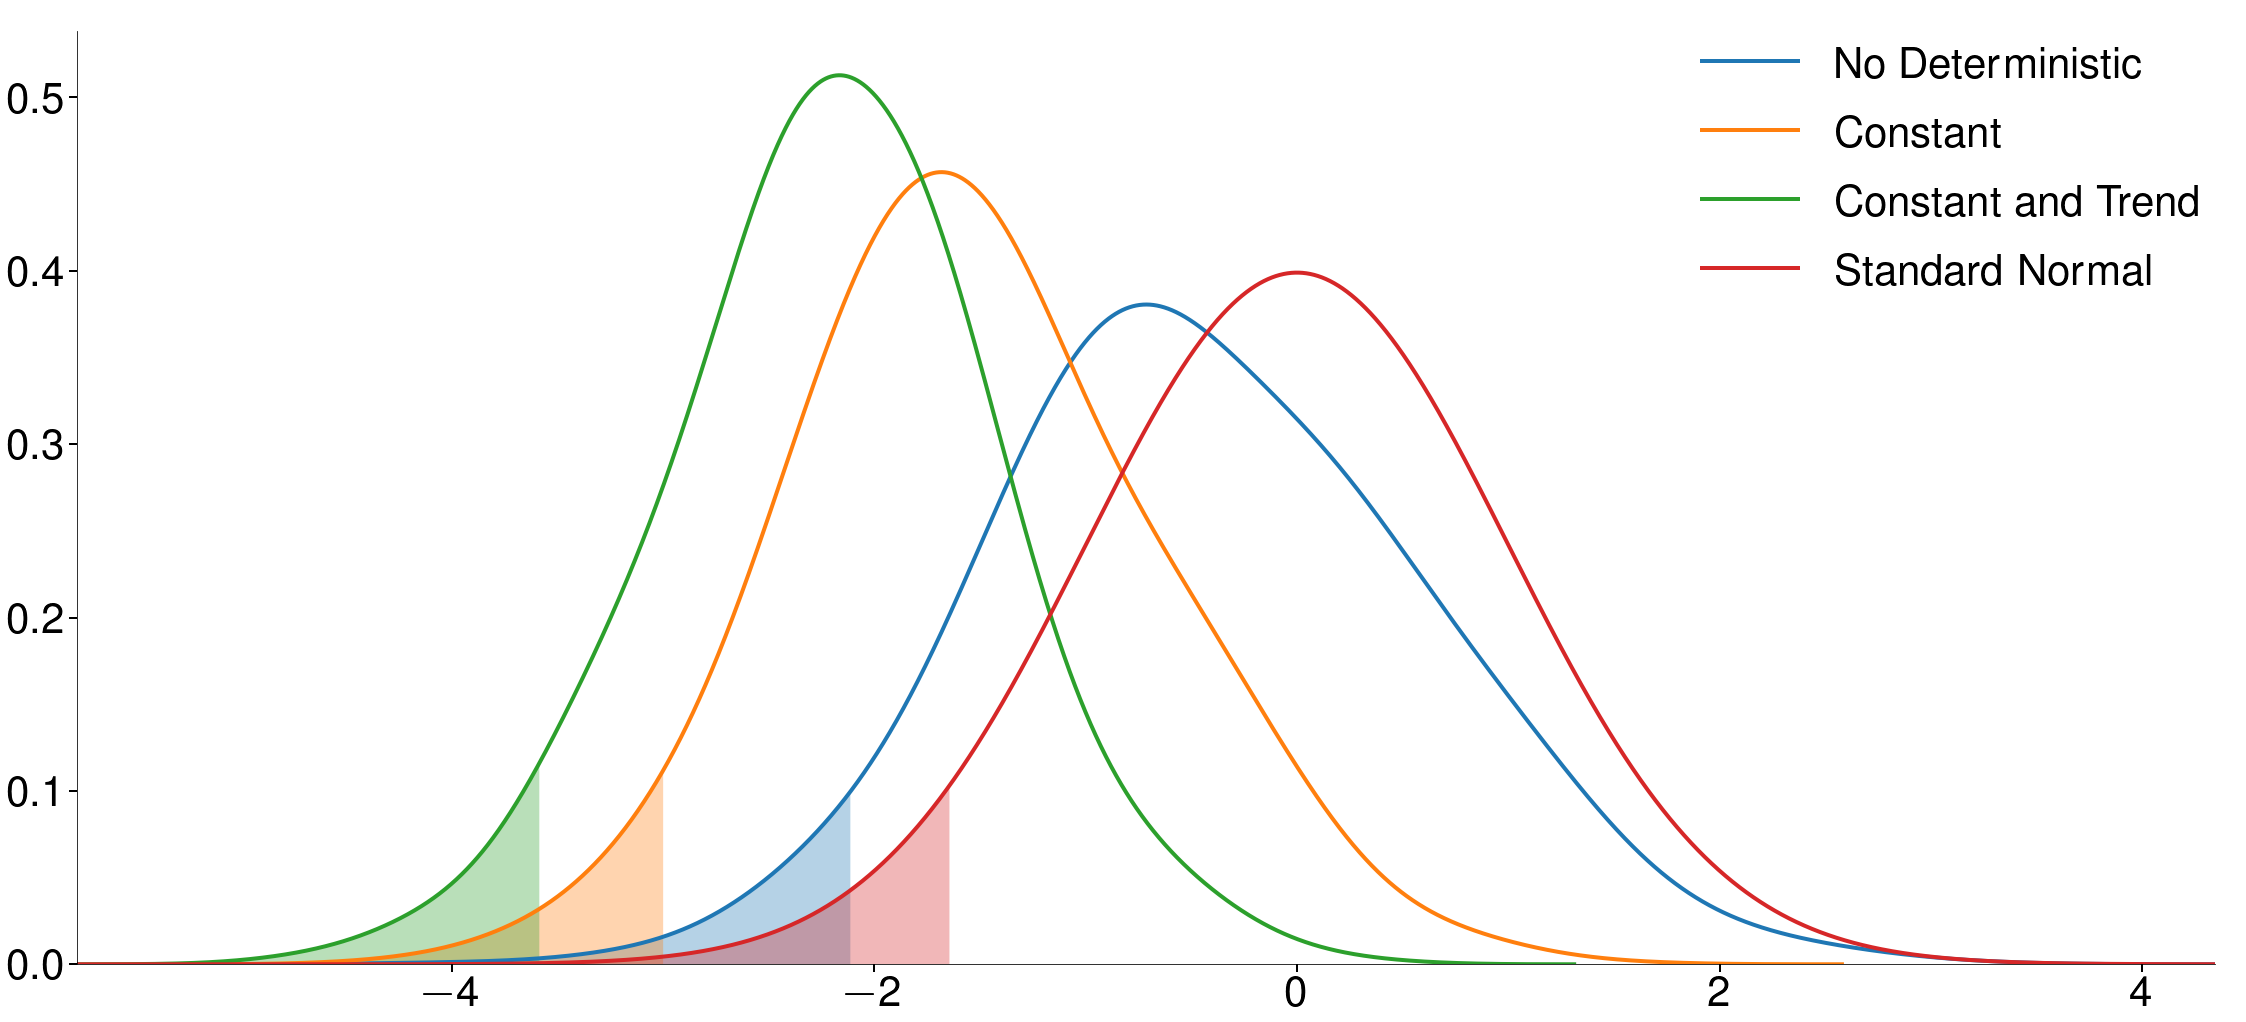

In [66]:
adf_cv_plot()

# Testing Default Premium

In [67]:
from arch.unitroot import ADF

adf = ADF(default)
adf.summary()

Test Statistic,-3.866
P-value,0.002
Lags,10


# Testing Curvature

In [68]:
adf = ADF(curve)
adf.summary()

Test Statistic,-4.412
P-value,0.000
Lags,19


# Testing Industrial Production

In [69]:
adf = ADF(np.log(orig.INDPRO), trend="c")
adf.summary()

Test Statistic,-2.186
P-value,0.211
Lags,4


# ADF Regression Results

In [70]:
summary(adf.regression)

,coef,std err,t,P>|t|,[0.025,0.975]
Level.L1,-0.0017,0.001,-2.186,0.029,-0.003,-0.000
Diff.L1,0.3637,0.037,9.860,0.000,0.291,0.436
Diff.L2,-0.1110,0.039,-2.832,0.005,-0.188,-0.034
Diff.L3,0.0447,0.039,1.138,0.255,-0.032,0.122
Diff.L4,0.0217,0.037,0.589,0.556,-0.051,0.094
const,0.0083,0.003,2.579,0.010,0.002,0.015


# Increasing the deterministic order

In [71]:
adf = ADF(np.log(orig.INDPRO), trend="ct")
adf

Test Statistic,-1.831
P-value,0.690
Lags,6


# Testing the difference

* The Industrial Productivity Index is $I(1)$ since 1 difference makes it stationary

In [72]:
delta_indpro = np.log(orig.INDPRO).diff().dropna()
adf = ADF(delta_indpro, trend="c")
adf

Test Statistic,-11.945
P-value,0.000
Lags,3


# The importance of time trends

* Incorrect trend specification results in no power to reject false nulls
* Always find a unit root in trending time series

In [73]:
y = np.zeros(250)
e = rg.standard_normal(250)
for i in range(250):
    y[i] = 0.025 * i + e[i]
    if i > 0:
        y[i] += 0.7 * y[i - 1]

trending = pd.Series(y, name="trending")

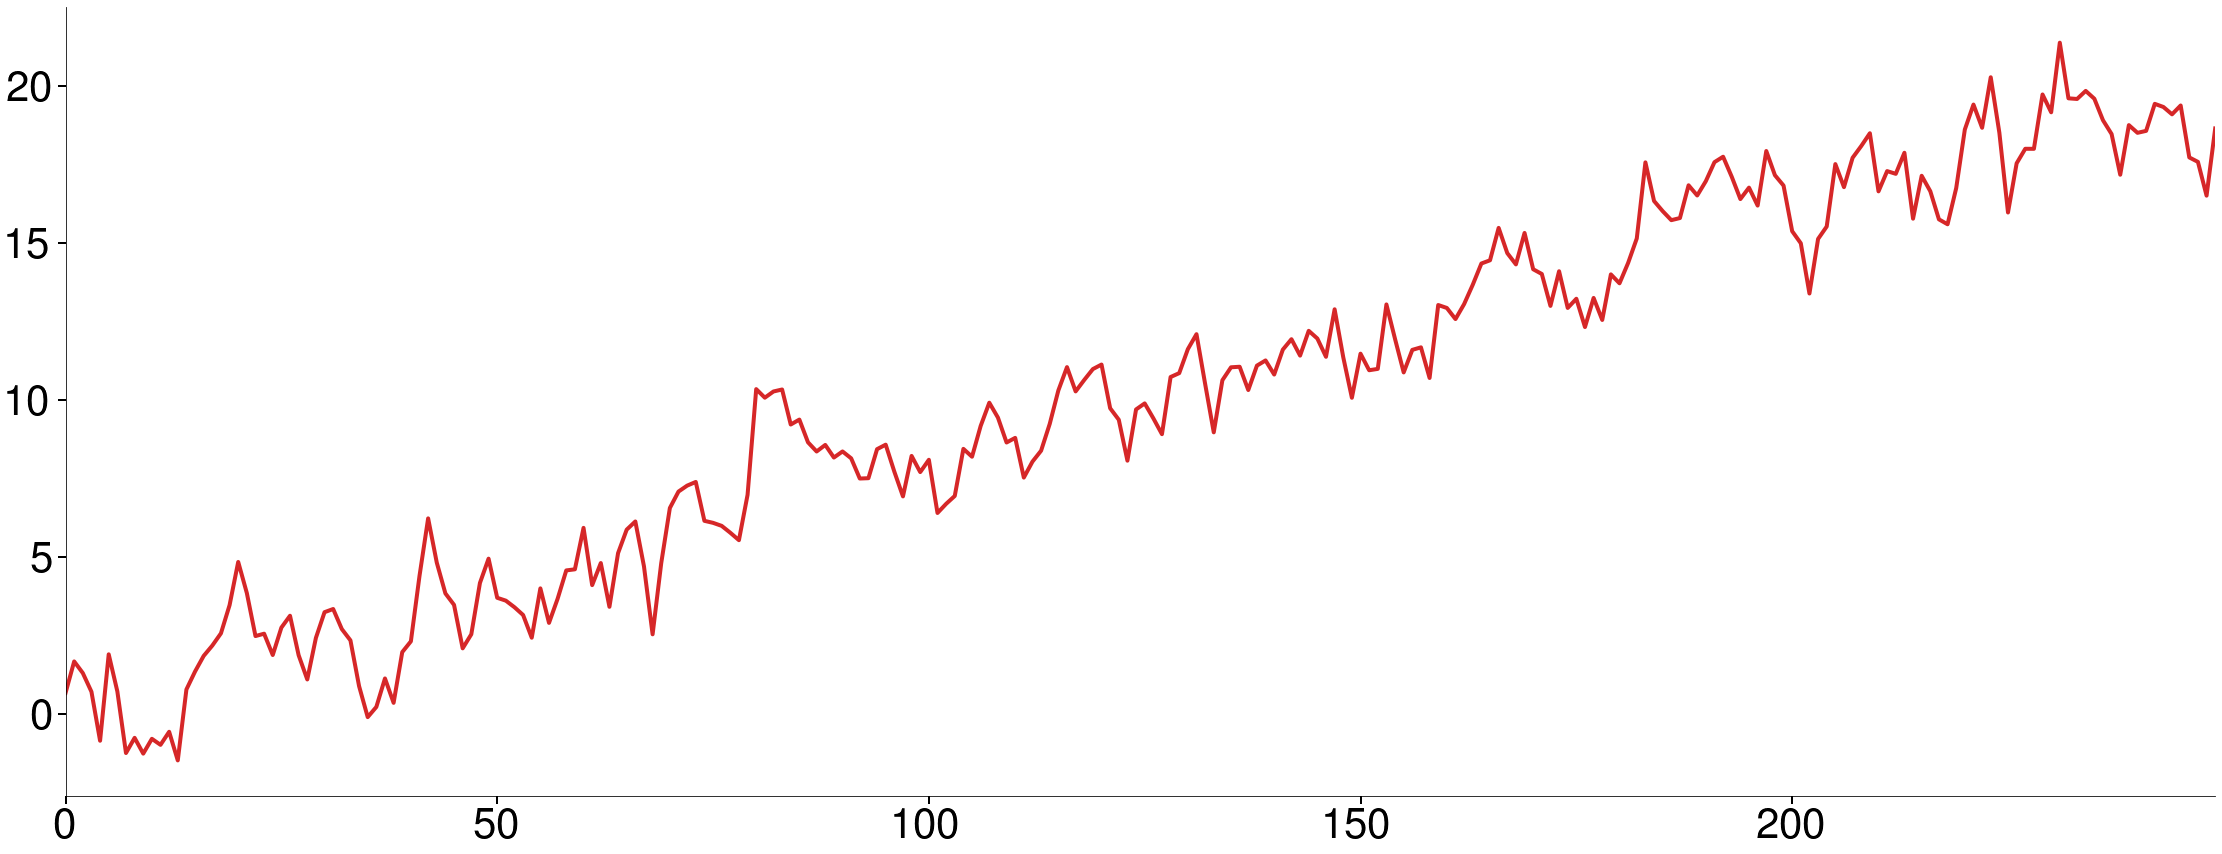

In [74]:
plot(trending, 13)

# Under-specifying Deterministic Terms

* Do not use model with no deterministic terms on real data unless $Y_t$ is known to be mean 0

In [75]:
ADF(trending, trend="n")

Test Statistic,1.934
P-value,0.988
Lags,9


# Under-specifying Deterministic Terms

In [76]:
ADF(trending, trend="c")

Test Statistic,-1.146
P-value,0.696
Lags,9


# Correctly specifying Deterministic Terms

In [77]:
ADF(trending, trend="ct")

Test Statistic,-6.790
P-value,0.000
Lags,0


# Over-specifying Deterministic Terms

In [78]:
ADF(y, trend="ctt")

Test Statistic,-6.885
P-value,0.000
Lags,0


# Incorporating Time Trends into ARMA Models

* Can jointly estimate trends and stationary components of ARMA models

$$ Y_t = \phi_0 + \delta_1 t + \phi_1 Y_{t-1} + \epsilon_t $$

In [79]:
res = SARIMAX(trending, order=(1, 0, 0), trend="ct").fit()
summary(res)

,coef,std err,z,P>|z|,[0.025,0.975]
intercept,0.0796,0.116,0.687,0.492,-0.148,0.307
drift,0.0255,0.004,6.149,0.000,0.017,0.034
ar.L1,0.6822,0.050,13.534,0.000,0.583,0.781
sigma2,0.9213,0.080,11.451,0.000,0.764,1.079


# Time Trend Model Residuals

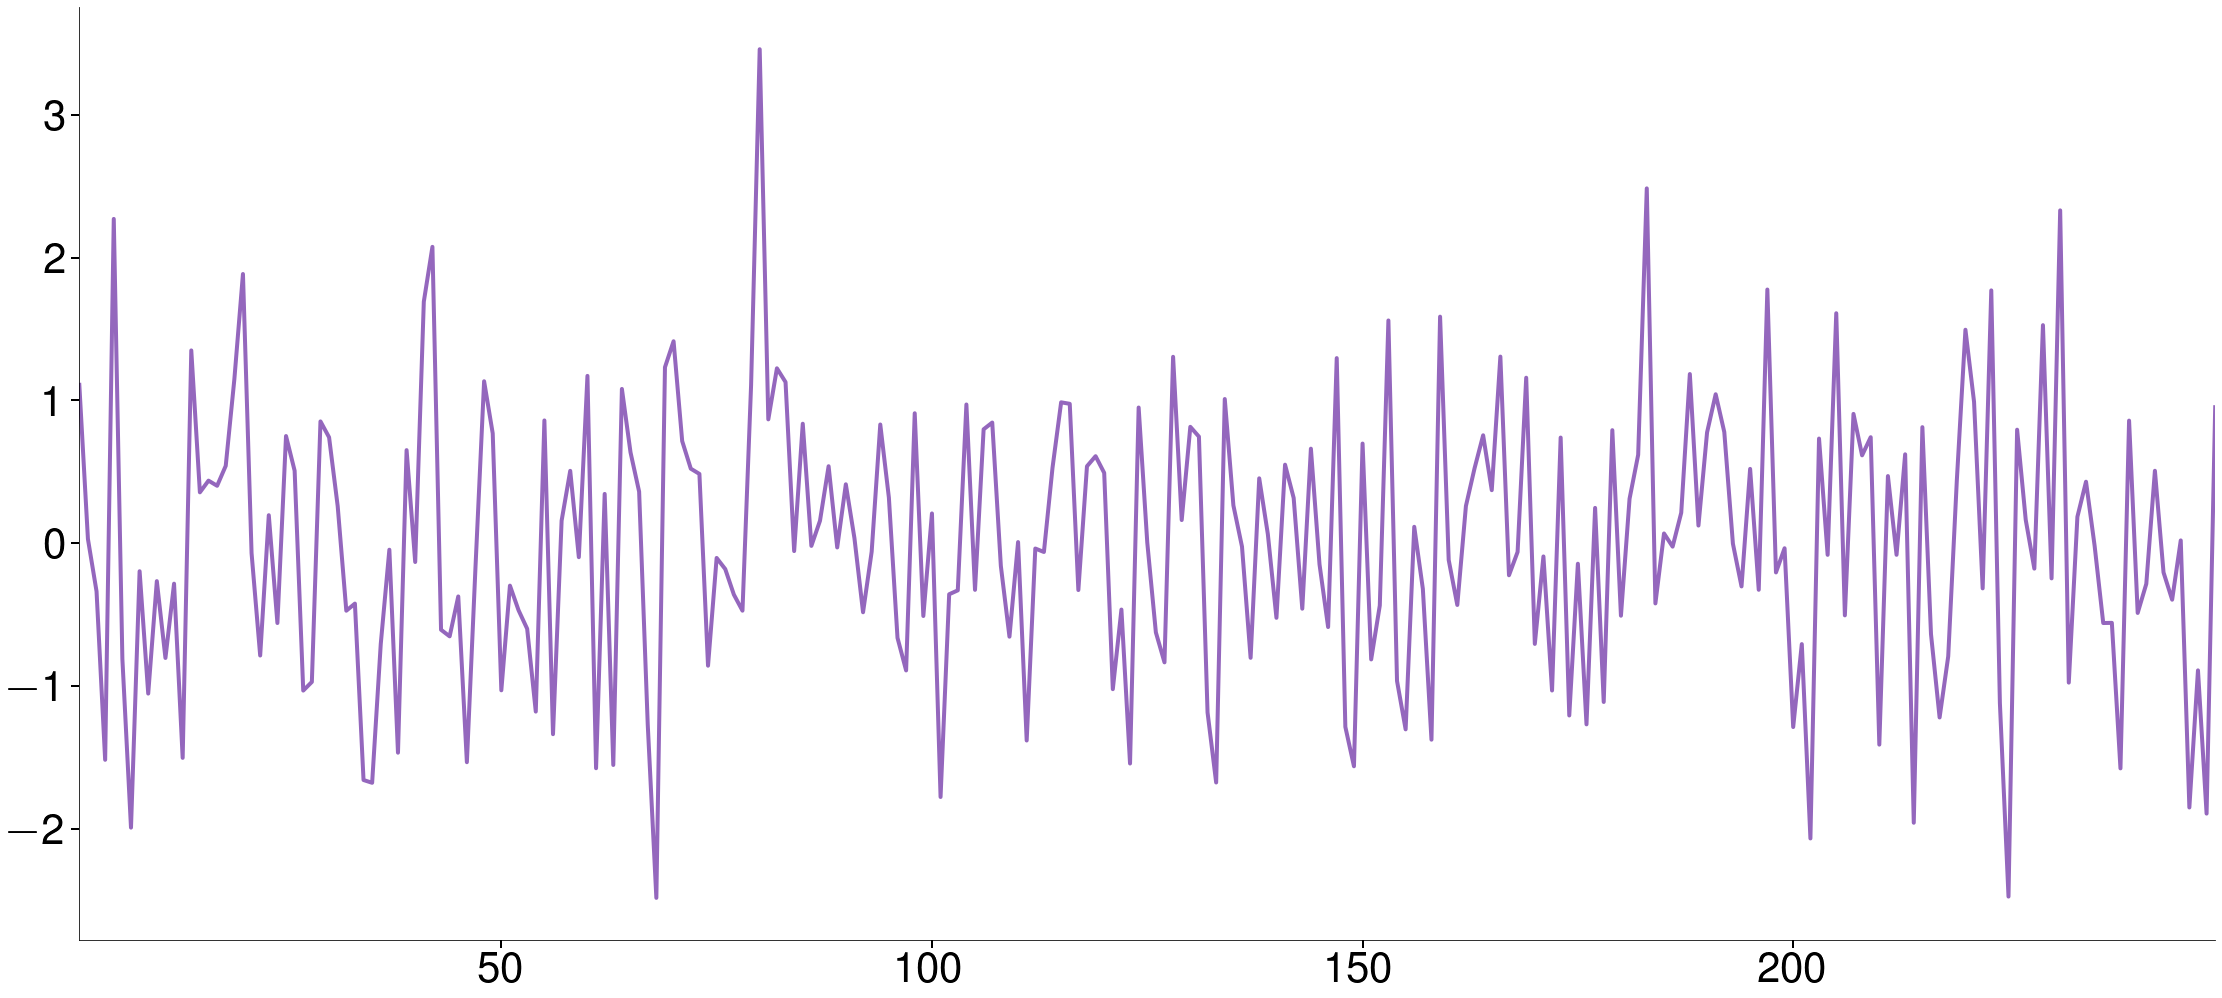

In [80]:
plot(res.resid.iloc[1:])

# Next Week

* Univariate Volatility Modeling